# 💽 Imports

---

In [1]:
# MAIN
import os
from math import pi
import ast

# DATA MANIPULATION
## Numpy
import numpy as np
## Pandas
import pandas as pd

# DATA VISUALIZATION

## Squarify
import squarify

## Pywaffle
from pywaffle import Waffle

## Plotly
import plotly as py
import plotly.graph_objs as go
import plotly.io as pio

## Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import subplots
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [2]:
import sys
# Caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../src/addons')

from etlAiAdoption import extractTransformLoad # type: ignore

# 🗃️ Load files

---

In [3]:
# Construct the path to the CSV file relative to the current notebook
current_file_path = os.path.abspath("main.ipynb")
current_dir = os.path.dirname(current_file_path)

extractTransformLoad(current_file_path)
# file is in a folder named 'data' in the same folder as the notebook
ai_adoption_survey_src_path = os.path.join(current_dir, "data", "cl_ai_adoption_2024.csv")

df_survey = pd.read_csv(
  ai_adoption_survey_src_path,
  delimiter=',',
  header=0,
  index_col=False
)

df_survey['Tools'] = df_survey['Tools'].apply(ast.literal_eval)
df_survey['Motivations'] = df_survey['Motivations'].apply(ast.literal_eval)
df_survey['Motivations'] = df_survey['Motivations'].apply(
    lambda x: {'Aucune motivation'} if not x or all(not motivation for motivation in x) else x)

remap of industry sector: 26 to 15
remap of company department: 44 to 19
Data saved to: c:\Users\109768706\Git\paris1-iae-ai_adoption_by_employees\src\data\cl_ai_adoption_2024.csv


In [4]:
stackoverflow_2023_survey_src_path = os.path.join(current_dir, "data", "raw", "stackoverflow_2023.csv")

df_stack_2023_survey = pd.read_csv(
  stackoverflow_2023_survey_src_path,
  delimiter=',',
  header=0,
  index_col=False,
)


# ResponseId
# Q120
# MainBranch
# Age
# Employment
# RemoteWork
# CodingActivities
# EdLevel
# LearnCode
# LearnCodeOnline
# LearnCodeCoursesCert
# YearsCode
# YearsCodePro
# DevType
# OrgSize
# PurchaseInfluence
# TechList
# BuyNewTool
# Country
# Currency
# CompTotal
# LanguageHaveWorkedWith
# LanguageWantToWorkWith
# DatabaseHaveWorkedWith
# DatabaseWantToWorkWith
# PlatformHaveWorkedWith
# PlatformWantToWorkWith
# WebframeHaveWorkedWith
# WebframeWantToWorkWith
# MiscTechHaveWorkedWith
# MiscTechWantToWorkWith
# ToolsTechHaveWorkedWith
# ToolsTechWantToWorkWith
# NEWCollabToolsHaveWorkedWith
# NEWCollabToolsWantToWorkWith
# OpSysPersonal use
# OpSysProfessional use
# OfficeStackAsyncHaveWorkedWith
# OfficeStackAsyncWantToWorkWith
# OfficeStackSyncHaveWorkedWith
# OfficeStackSyncWantToWorkWith
# AISearchHaveWorkedWith
# AISearchWantToWorkWith
# AIDevHaveWorkedWith
# AIDevWantToWorkWith
# NEWSOSites
# SOVisitFreq
# SOAccount
# SOPartFreq
# SOComm
# SOAI
# AISelect
# AISent
# AIAcc
# AIBen
# AIToolInterested in Using
# AIToolCurrently Using
# AIToolNot interested in Using
# AINextVery different
# AINextNeither different nor similar
# AINextSomewhat similar
# AINextVery similar
# AINextSomewhat different
# TBranch
# ICorPM
# WorkExp
# Knowledge_1
# Knowledge_2
# Knowledge_3
# Knowledge_4
# Knowledge_5
# Knowledge_6
# Knowledge_7
# Knowledge_8
# Frequency_1
# Frequency_2
# Frequency_3
# TimeSearching
# TimeAnswering
# ProfessionalTech
# Industry
# SurveyLength
# SurveyEase
# ConvertedCompYearly


In [5]:
#TODO Pas de négation dans les titres pour simplifier la lecture

# 🎨 Global Design

---

In [6]:
# Matplotlib general set of fonts
plt.rcParams["font.family"] = "Times New Roman"

# Plotly general set of fonts
pio.templates.default = "plotly"  # Commencez avec le modèle "plotly" par défaut
pio.templates["plotly"]["layout"]["font"]["family"] = "Times New Roman"


# 📊 Data function

---

In [7]:
def plot_pie(column, title):
    # check if df_survey[column] is a set if it is we need to explose first
    df = pd.DataFrame()
    if isinstance(df_survey[column].dropna().iloc[0], set):
        df = df_survey.explode(column)
    else:
        df = df_survey.copy()
    # if % is less than 1% then it will be combined into 'Others'
    graph_df = df[column].value_counts(normalize=True)
    others_sum = graph_df[graph_df <= 0.01].sum()
    graph_df = graph_df[graph_df > 0.01]
    if others_sum > 0:
        graph_df['Others'] = others_sum

    graph_df = graph_df.sort_values(ascending=False)
    plt.figure(figsize=(16, 8))
    patches, texts, autotexts = plt.pie(graph_df, autopct=lambda p: '{:.1f}%'.format(p) if p >= 1 else '',
                                         startangle=0, counterclock=False)
    plt.legend(patches, graph_df.index, loc="upper right")
    plt.title(title)
    plt.xlabel('')
    plt.ylabel('')
    plt.show()
    save_title = title.replace(" ", "_").replace("'", "-").lower()
    # we also need to drop special characters from the title
    save_title = ''.join(e for e in save_title if e.isalnum())

def plot_treemap(column, title):
    # Check if df_survey[column] is a set; if it is, we need to explode first
    df = pd.DataFrame()
    if isinstance(df_survey[column].dropna().iloc[0], set):
        df = df_survey.explode(column)
    else:
        df = df_survey.copy()

    # Get value counts normalized
    graph_df = df[column].value_counts(normalize=True)

    # Sort values in descending order
    graph_df = graph_df.sort_values(ascending=False)

    # Prepare data for treemap
    labels = [f'{value:.1%}' for value in graph_df.values]
    full_labels = [f'{index}' for index, value in graph_df.items()]
    sizes = graph_df.values * 100  # Convert to percentages
    cmap = plt.get_cmap('tab20c')  # Use a colormap

    # Generate colors from the colormap
    colors = [cmap(i / float(len(labels))) for i in range(len(labels))]

    plt.figure(figsize=(16, 8))

    # Plot treemap
    squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, text_kwargs={'fontsize':12})
    plt.title(title)
    plt.axis('off')  # No axes for treemap

    # Add legend
    patches = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
    plt.legend(patches, full_labels, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    save_title = title.replace(" ", "_").replace("'", "-").lower()
    save_title = ''.join(e for e in save_title if e.isalnum())

# 🗣️ Survey Answer

---

# ❓ Question 1: Quel est votre genre ?

- [x] 1/2 Répartition de l'age par genre
- [x] 1/3&4 Distribution des secteurs d'activité et service de l'entreprise par genre
- [ ] 1/10 RAS

---

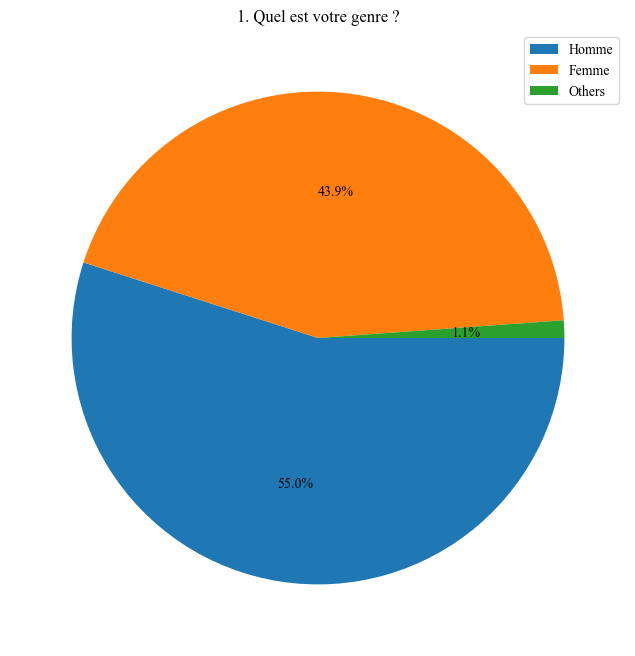

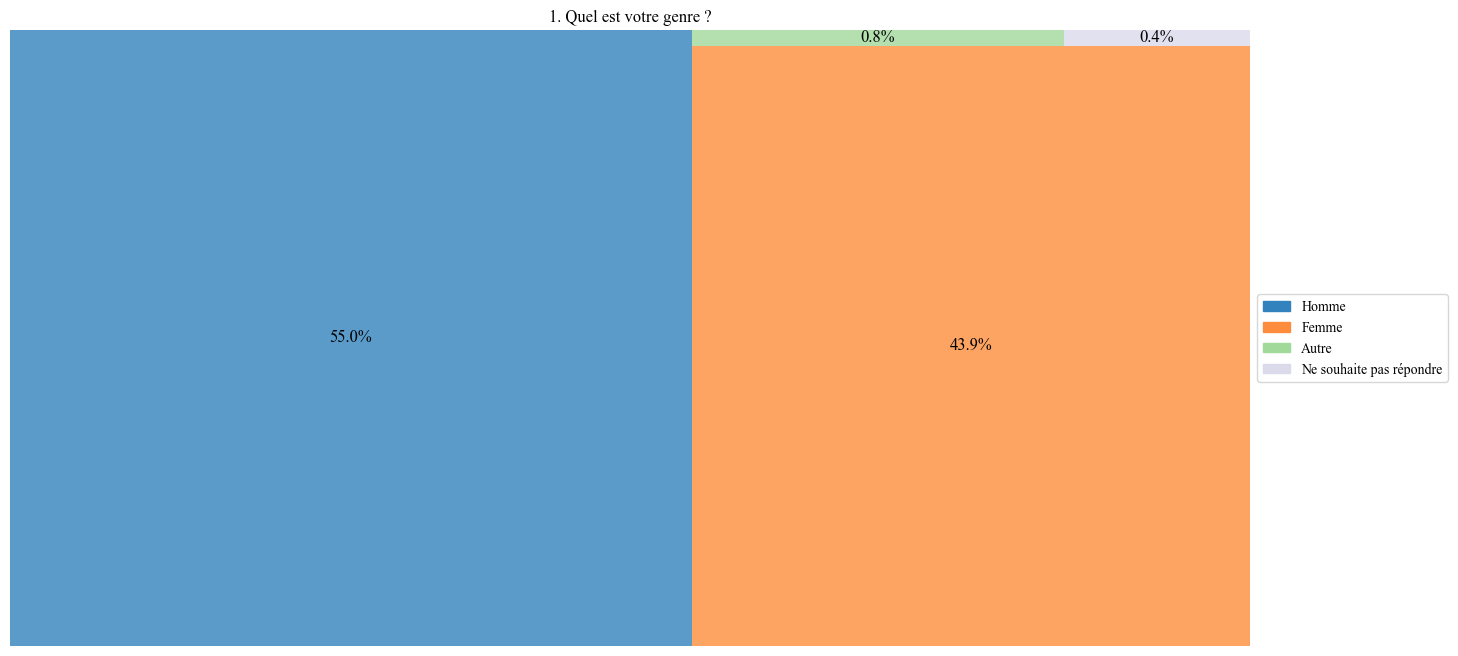

In [8]:
plot_pie('Gender', '1. Quel est votre genre ?')
plot_treemap('Gender', '1. Quel est votre genre ?')

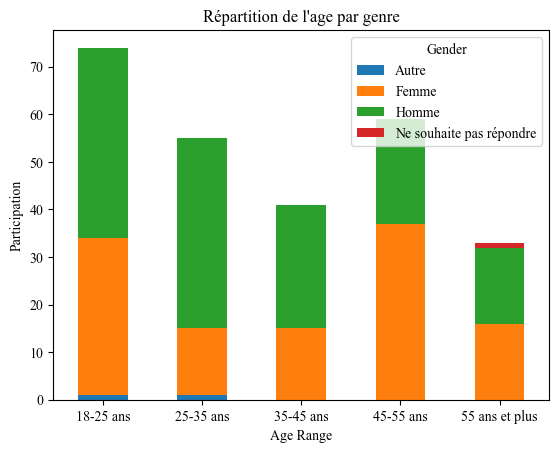

In [9]:
# 1/2 Age Distribution by Gender
age_gender = df_survey.groupby(['Age', 'Gender']).size().unstack()
age_gender.plot(kind='bar', stacked=True)
plt.title('Répartition de l\'age par genre')
plt.xlabel('Age Range')
plt.ylabel('Participation')
plt.xticks(rotation=0)
plt.legend(title='Gender')
plt.show()

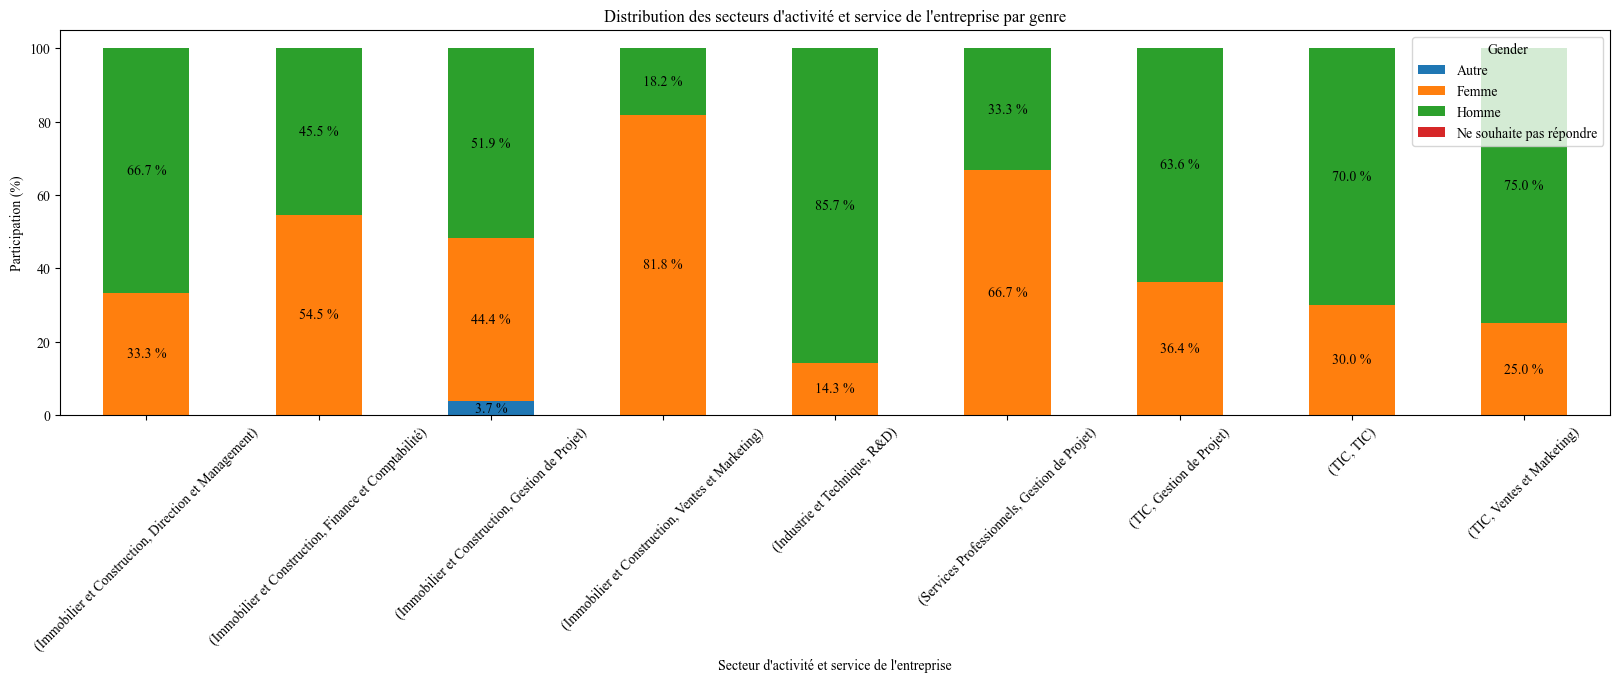

In [10]:
# 1/3&4 Sector and Departement by Gender
gender_distribution = df_survey.groupby(['Sector', 'Department', 'Gender']).size().unstack()
MIN_PARTICIPATION_FILTER = 5
total_count = gender_distribution.sum(axis=1)
valid_sectors_departments = total_count[total_count > MIN_PARTICIPATION_FILTER].index
gender_distribution_filtered = gender_distribution.loc[valid_sectors_departments]

# Calculate percentage
gender_distribution_percentage = gender_distribution_filtered.div(gender_distribution_filtered.sum(axis=1), axis=0) * 100

# Plot the data
ax = gender_distribution_percentage.plot(kind='bar', stacked=True, figsize=(20,5))
plt.title('Distribution des secteurs d\'activité et service de l\'entreprise par genre')
plt.xlabel('Secteur d\'activité et service de l\'entreprise')
plt.ylabel('Participation (%)')
plt.xticks(rotation=45)
plt.legend(title='Gender')

# Add percentage text on each bar
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:  # Only add text if percentage is greater than 0
        ax.text(x+width/2,
                y+height/2,
                '{:.1f} %'.format(height),
                horizontalalignment='center',
                verticalalignment='center')

plt.show()

# ❓ Question 2: Dans quelle tranche d’âge vous situez-vous ?

- [ ] 2/3&4 Répartition des secteurs d'activité et services par tranche d'âge
- [x] 2/5 Familiarité avec l'IA par tranche d'âge
- [ ] 2/6 Réfractarité à l’utilisation de l'IA au travail par tranche d'âge
- [x] 2/7 Ouverture à l'utilisation des outils utilisant l'IA par tranche d'âge
- [ ] 2/8&9 Utilisation des outils basés sur l'IA et types d'outils utilisés par tranche d'âge
- [ ] 2/10 Motivations pour utiliser des outils basés sur l'IA par tranche d'âge
- [ ] 2/11 Problèmes rencontrés avec les outils basés sur l'IA par tranche d'âge
- [ ] 2/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par tranche d'âge
- [x] 2/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par tranche d'âge
- [x] 2/14 Perception de la perte d'autonomie due à l'IA par tranche d'âge
- [ ] 2/15 Perception de la réduction des capacités de réflexion due à l'IA par tranche d'âge
- [ ] 2/16 Crainte de perdre son emploi à cause de l'IA par tranche d'âge
- [ ] 2/17 Autres inquiétudes face à l'arrivée de l'IA par tranche d'âge
- [ ] 2/18 Inclusion dans le développement d'outils basés sur l'IA par tranche d'âge
- [ ] 2/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par tranche d'âge
- [x] 2/20 Inclination à utiliser l'IA après consultation par tranche d'âge
- [ ] 2/21 Disposition à suivre une formation sur les technologies basées sur l'IA par tranche d'âge
- [ ] 2/22 Commentaires et suggestions sur l'arrivée de l'IA par tranche d'âge

---

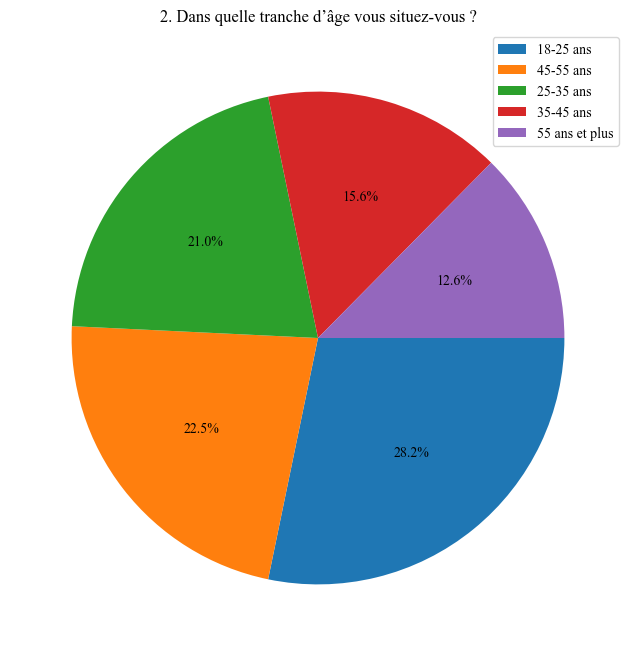

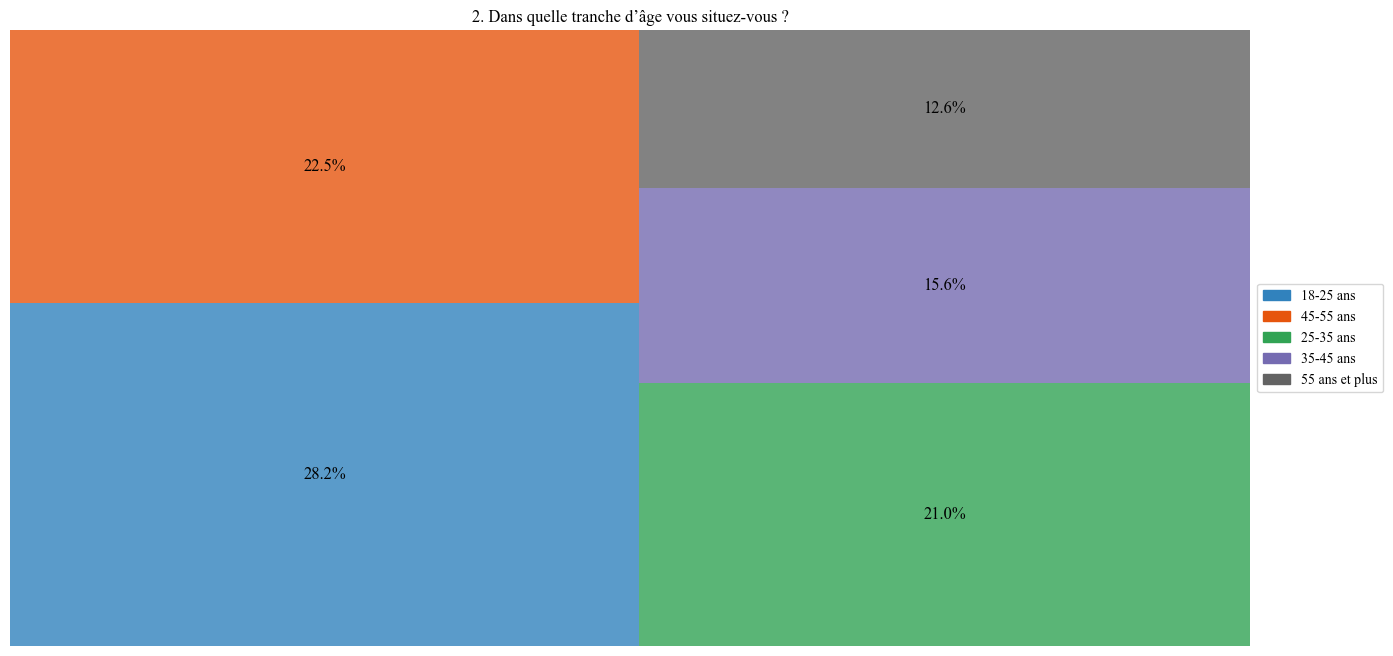

In [11]:
plot_pie('Age', '2. Dans quelle tranche d’âge vous situez-vous ?')
plot_treemap('Age', '2. Dans quelle tranche d’âge vous situez-vous ?')

## ✅ 5. Familiarité avec IA / age

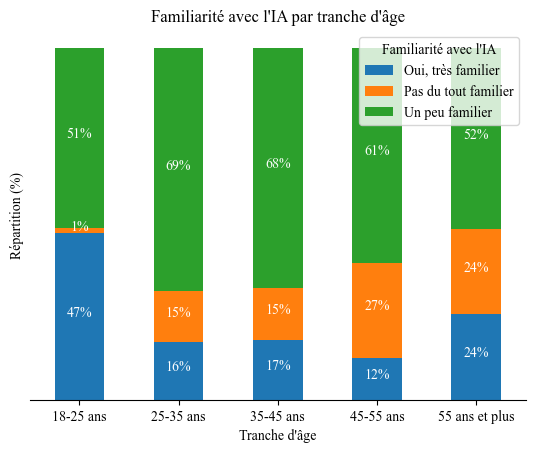

In [12]:
#TODO faire ca

# Define order of categories

# Convert Familiarity to a categorical type


# 2/5 Familiarity with AI by Age Range
familiarity_age = df_survey.groupby(['Age', 'Familiarity']).size().unstack()

# Convert counts to percentages
familiarity_age = familiarity_age.div(familiarity_age.sum(axis=1), axis=0) * 100
#TODO order the rows to be Oui, Un peu, Pas du tout
ax = familiarity_age.plot(kind='bar', stacked=True)


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('none')
ax.set_yticks([])

plt.title('Familiarité avec l\'IA par tranche d\'âge')
plt.xlabel('Tranche d\'âge')
plt.ylabel('Répartition (%)')
plt.xticks(rotation=0)
plt.legend(title='Familiarité avec l\'IA')

# Add percentages on top of each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}%', (x + width/2, y + height*0.5), ha='center', color='white')

plt.show()

## ✅ 3. Réfractaire / age

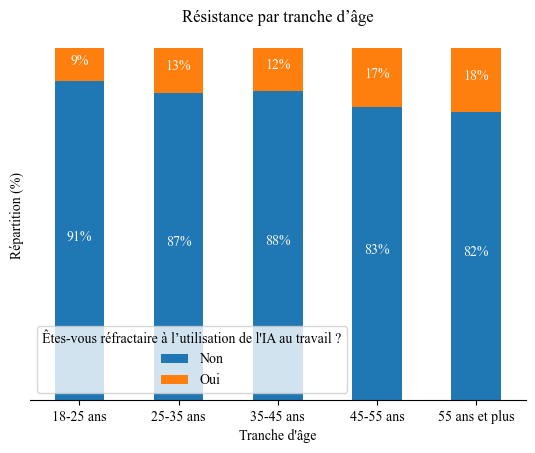

In [13]:
# 2/6 Réfractaire par tranche d'âge
familiarity_age_bar = df_survey.groupby(['Age', 'Resistance']).size().unstack()

# Convert counts to percentages
familiarity_age_percentage = familiarity_age_bar.div(familiarity_age_bar.sum(axis=1), axis=0) * 100

# Plot the data
ax = familiarity_age_percentage.plot(kind='bar', stacked=True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('none')
ax.set_yticks([])

plt.title('Résistance par tranche d’âge')
plt.xlabel('Tranche d\'âge')
plt.ylabel('Répartition (%)')
plt.xticks(rotation=0)
plt.legend(title='Êtes-vous réfractaire à l’utilisation de l\'IA au travail ?')


# Add percentages on top of each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}%', (x + width/2, y + height*0.5), ha='center', color='white')

plt.show()

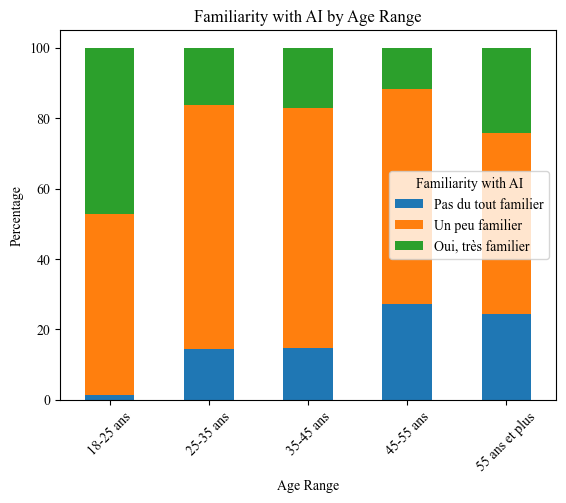

In [14]:
# 2/5 Familiarity with AI by Age Range
familiarity_age = df_survey.groupby(['Age', 'Familiarity']).size().unstack()

familiarity_order = ["Pas du tout familier", "Un peu familier", "Oui, très familier"]
familiarity_age = familiarity_age[familiarity_order]

# Convert counts to percentages
familiarity_age = familiarity_age.div(familiarity_age.sum(axis=1), axis=0) * 100

familiarity_age.plot(kind='bar', stacked=True)
plt.title('Familiarity with AI by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Familiarity with AI')
plt.show()

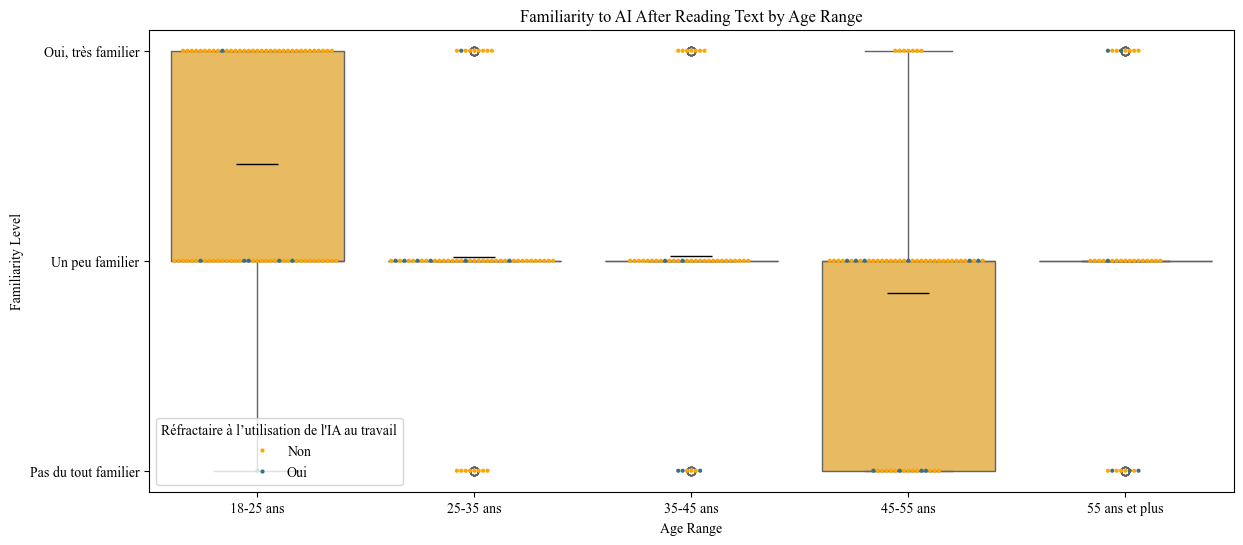

In [15]:
# 2/7 Mean Openness Level to AI After Reading Text by Age Range
df_familiarity_age_box = df_survey[['Age', '*Familiarity', 'Resistance']].copy()

#todo simplifier le graph
#todo tracer les moyennes des refractaires en proportion
#todo tracer les moyennes des familiarités en proportion

age_order = ["18-25 ans", "25-35 ans", "35-45 ans", "45-55 ans", "55 ans et plus"]
df_familiarity_age_box['Age'] = pd.Categorical(df_familiarity_age_box['Age'], categories=age_order, ordered=True)
df_familiarity_age_box = df_familiarity_age_box.sort_values('Age').reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.boxplot(x='Age', y='*Familiarity', data=df_familiarity_age_box, color="#FFC34B")
sns.swarmplot(x='Age', y='*Familiarity', data=df_familiarity_age_box, hue='Resistance', palette=['orange', '#3B7080'], size=3)
sns.pointplot(x='Age', y='*Familiarity', data=df_familiarity_age_box, errorbar=None, color="black", linestyle="none", capsize=.2, marker="_", markersize=30, markeredgewidth=1,)
plt.legend(title='Réfractaire à l’utilisation de l\'IA au travail')
plt.title('Familiarity to AI After Reading Text by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Familiarity Level')
plt.xticks(rotation=0)
familiarity_order = ["Pas du tout familier", "Un peu familier", "Oui, très familier"]
plt.yticks([0, 1, 2], familiarity_order)
plt.show()

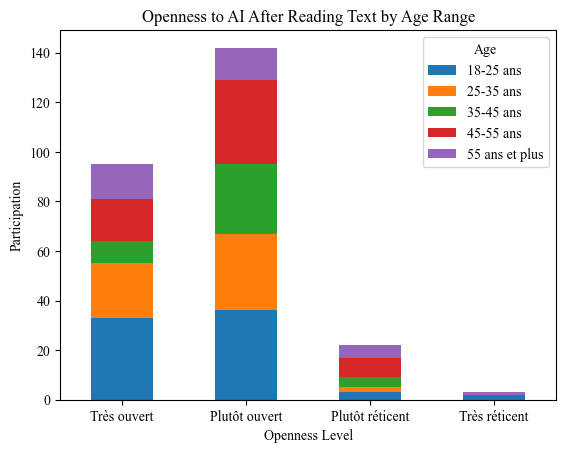

In [16]:
# 2/7 Openness to AI After Reading Text by Age Range
openness_age = df_survey.groupby([
  'Age',
  'Openness'
]).size().unstack(0).reindex([
  'Très ouvert',
  'Plutôt ouvert',
  'Plutôt réticent',
  'Très réticent'
])
openness_age.plot(kind='bar', stacked=True)
plt.title('Openness to AI After Reading Text by Age Range')
plt.xlabel('Openness Level')
plt.ylabel('Participation')
plt.xticks(rotation=0)
plt.show()

c:\Users\109768706\Git\paris1-iae-ai_adoption_by_employees\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\109768706\Git\paris1-iae-ai_adoption_by_employees\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\109768706\Git\paris1-iae-ai_adoption_by_employees\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\109768706\Git\paris1-iae-ai_adoption_by_employees\.venv\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the marker

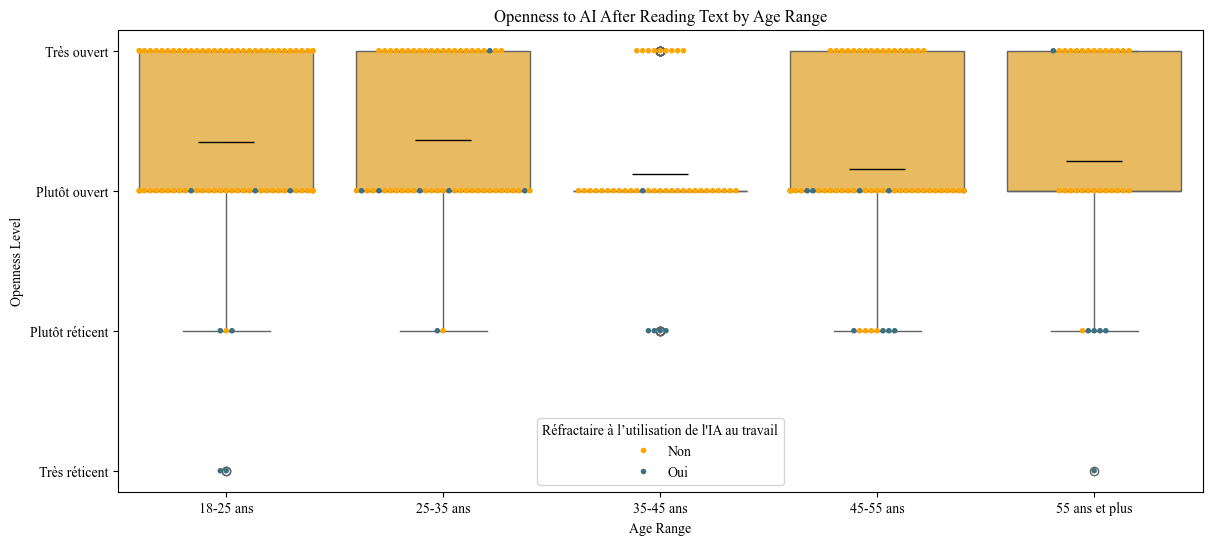

timestamp Gender        Age  \
10   06/05/2024 15:39:46  Homme  25-35 ans   
33   06/05/2024 22:22:37  Homme  18-25 ans   
138  14/05/2024 17:39:07  Femme  45-55 ans   
146  15/05/2024 15:11:45  Femme  45-55 ans   
147  15/05/2024 15:19:56  Femme  45-55 ans   
165  19/05/2024 22:29:05  Homme  18-25 ans   

                                               _Sector  \
10                                             Telecom   
33                           Santé et services sociaux   
138                                         Immobilier   
146                                         Immobilier   
147                        Construction et génie civil   
165  Technologies de l'information et de la communi...   

                            _Department           Familiarity Resistance  \
10                    Gestion de projet       Un peu familier        Non   
33                                  R&D    Oui, très familier        Non   
138             Vente/Commercialisation  Pas du tout familier        Non   
146                           Juridique       Un peu familier        Non   
147  IT (Technologies de l'Information)       Un peu familier        Non   
165                          Innovation    Oui, très familier        Non   

            Openness         Usage  \
10       Très ouvert  Très souvent   
33       Très ouvert  Très souvent   
138  Plutôt réticent        Jamais   
146      Très ouvert      Rarement   
147      Très ouvert       Parfois   
165      Très ouvert       Parfois   

                                                 Tools  ...  \
10   {Reconnaissance faciale/biometrique, Language ...  ...   
33   {Prise de decision, Reconnaissance faciale/bio...  ...   
138                                           {Autres}  ...   
146  {Reconnaissance faciale/biometrique, Language ...  ...   
147  {Reconnaissance faciale/biometrique, Autres, L...  ...   
165  {Reconnaissance faciale/biometrique, Language ...  ...   

                                           Suggestions  \
10                              On attend, on espère !   
33   Une échelle pour savoir à quel point on maîtri...   
138  curieuse de mieux connaitre pour mieux l'utili...   
146                                                NaN   
147                                                NaN   
165                                                NaN   

                         Sector           Department  SupportDepartment  \
10                          TIC    Gestion de Projet                opé   
33    Santé et Services Sociaux                  R&D                opé   
138  Immobilier et Construction  Ventes et Marketing                opé   
146  Immobilier et Construction            Juridique                sup   
147  Immobilier et Construction                  TIC                opé   
165                         TIC                  R&D                opé   

    *Familiarity *Openness *Usage *LossOfAutonomy *ReducedThinking  \
10             1         3      3               0              0.0   
33             2         3      3               0              0.0   
138            0         1      0               3              0.0   
146            1         3      1               1              1.0   
147            1         3      2               0              0.0   
165            2         3      2               1              1.0   

    *WillingnessForTraining  
10                        2  
33                        2  
138                       2  
146                       2  
147                       2  
165                       2  

[6 rows x 35 columns]

In [17]:
# 2/7 Mean Openness Level to AI After Reading Text by Age Range
df_openness = df_survey[['Age', '*Openness', 'Resistance']].copy()

age_order = ["18-25 ans", "25-35 ans", "35-45 ans", "45-55 ans", "55 ans et plus"]
df_openness['Age'] = pd.Categorical(df_openness['Age'], categories=age_order, ordered=True)
df_openness = df_openness.sort_values('Age').reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.boxplot(x='Age', y='*Openness', data=df_openness, color="#FFC34B")
sns.swarmplot(x='Age', y='*Openness', data=df_openness, hue='Resistance', palette=['orange', '#3B7080'], size=4)
sns.pointplot(x='Age', y='*Openness', data=df_openness, errorbar=None, color="black", linestyle="none", capsize=.2, marker="_", markersize=40, markeredgewidth=1,)
plt.legend(title='Réfractaire à l’utilisation de l\'IA au travail')
plt.title('Openness to AI After Reading Text by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Openness Level')
plt.xticks(rotation=0)
plt.yticks([0, 1, 2, 3], ['Très réticent', 'Plutôt réticent', 'Plutôt ouvert', 'Très ouvert'])
plt.show()

# we can now plot outliers (18-25 ans, Très réticent) & (35-45 ans, Très réticent)
df_outliers = df_survey[
  ((df_openness['Age'] == '18-25 ans')
  & (df_openness['*Openness'] == 0))
  | ((df_openness['Age'] == '35-45 ans')
  & (df_openness['*Openness'] <= 1))
]

display(df_outliers)


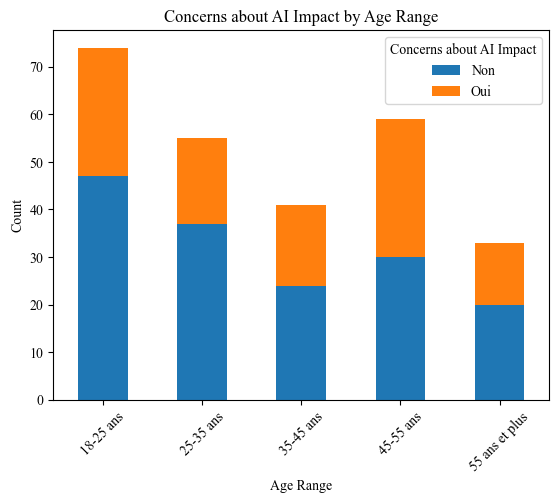

In [18]:
# 2/13 Concerns about AI Impact by Age Range
concerns_age = df_survey.groupby('Age')['Concerns'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Concerns about AI Impact by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Concerns about AI Impact')
plt.show()

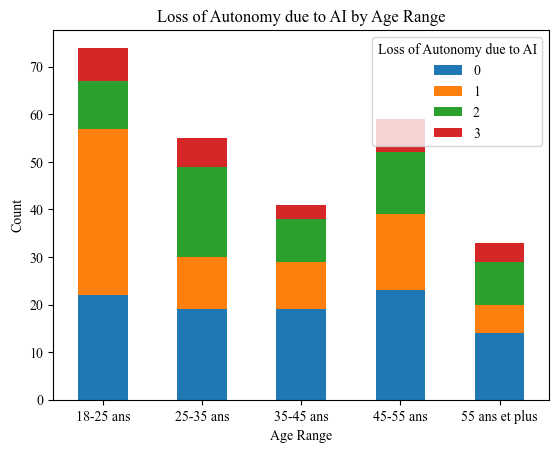

In [19]:
# 2/14 Loss of Autonomy due to AI by Age Range

loss_autonomy_gender = df_survey.groupby('Age')[
    '*LossOfAutonomy'
].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Loss of Autonomy due to AI by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Loss of Autonomy due to AI')
plt.show()

## ✅ 7. Perte de l'autonomie / age

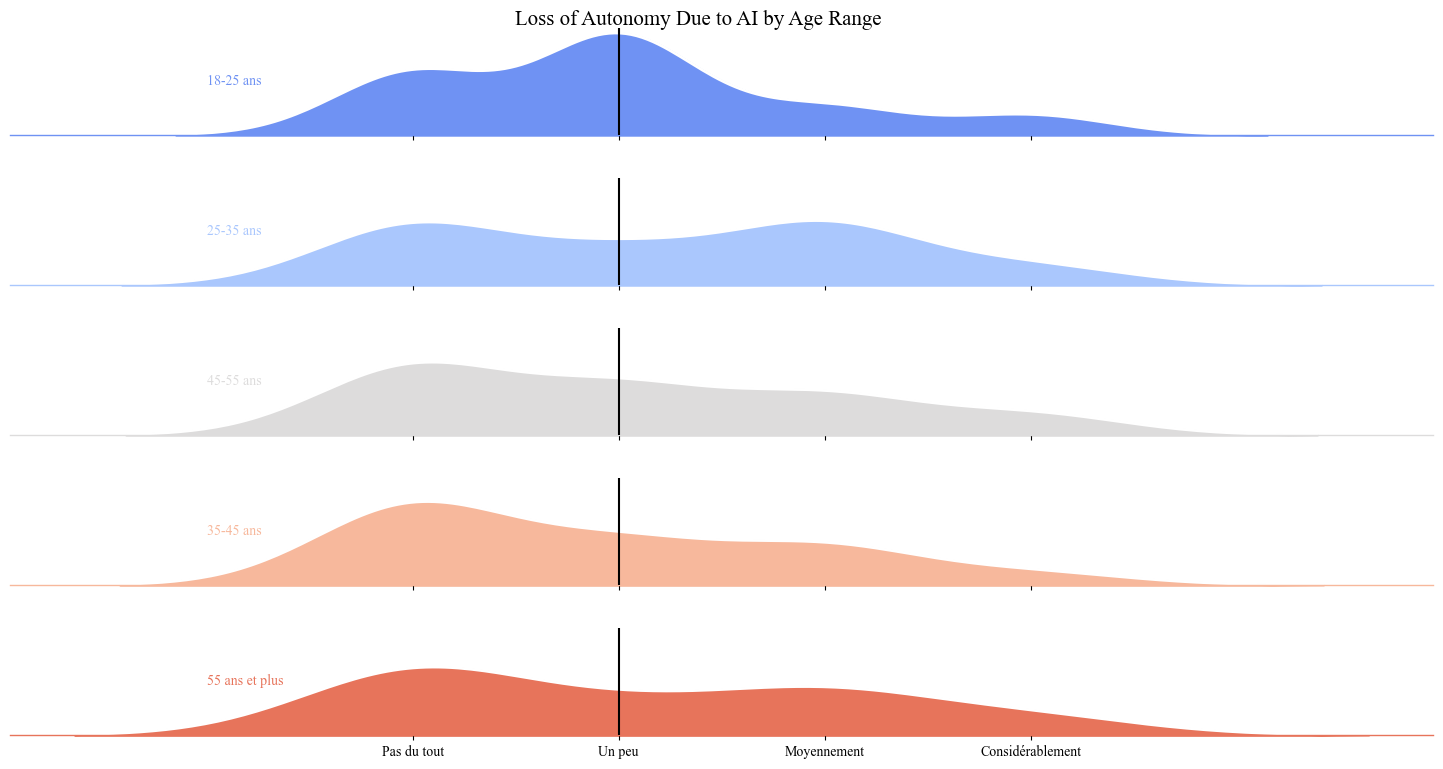

In [20]:
#TODO modifier la pallette de couleur

# Generate a color palette with Seaborn
pal = sns.color_palette(palette='coolwarm', n_colors=len(df_survey['Age'].unique()))

# Create the FacetGrid object
g = sns.FacetGrid(df_survey, row='Age', hue='Age', aspect=15, height=0.75, palette=pal)

#size the figure
g.fig.set_size_inches(15, 8)

# Add the densities kdeplots for each age range
g.map(sns.kdeplot, '*LossOfAutonomy',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# Add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, '*LossOfAutonomy',
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# Add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=1, clip_on=False)

# Add age range as text with the right color
for i, ax in enumerate(g.axes.flat):
    ax.text(-1, 0.25, df_survey['Age'].unique()[i],
            fontsize=10,
            color=ax.lines[-1].get_color())

    mean_value = df_survey[df_survey['Age'] == df_survey['Age'].unique()[i]]['*LossOfAutonomy'].median()
    ax.axvline(mean_value, color='black')

# Remove axes titles, yticks, and spines
g.set_titles("")
g.set(yticks=[])
g.set(ylabel="")  # Remove y label
g.despine(bottom=True, left=True)


g.fig.suptitle('Loss of Autonomy Due to AI by Age Range', fontsize=15)
plt.xlabel('')

labels = ['Pas du tout', 'Un peu', 'Moyennement', 'Considérablement']
g.set(xticks=range(0, 4), xticklabels=labels)

plt.show()

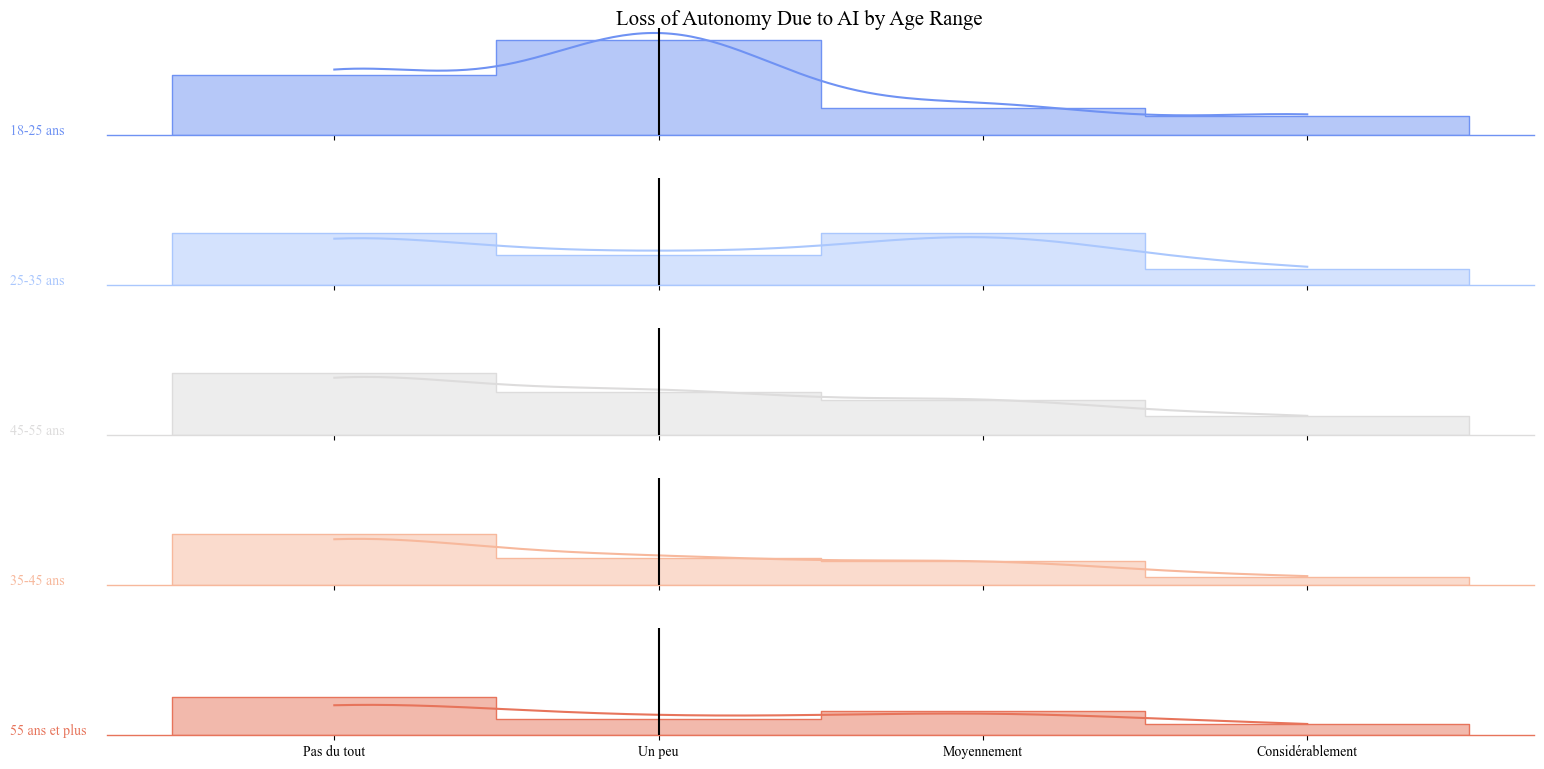

In [21]:
#TODO le faire en pourcentage
#TODO mettre dans l'ordre les tranches d'âge
pal = sns.color_palette(palette='coolwarm', n_colors=len(df_survey['Age'].unique()))

# Create the FacetGrid object
g = sns.FacetGrid(df_survey, row='Age', hue='Age', aspect=15, height=0.75, palette=pal)

#size the figure
g.fig.set_size_inches(15, 8)

# Add the histograms with kde for each age range
g.map(sns.histplot, '*LossOfAutonomy', kde=True, element="step", discrete=True)

# Add a horizontal line for each plot
g.map(plt.axhline, y=0, lw=1, clip_on=False)

# Add age range as text with the right color
for i, ax in enumerate(g.axes.flat):
    ax.text(-1, 0.25, df_survey['Age'].unique()[i], fontsize=10, color=ax.lines[-1].get_color())
    mean_value = df_survey[df_survey['Age'] == df_survey['Age'].unique()[i]]['*LossOfAutonomy'].median()
    ax.axvline(mean_value, color='black')
    ax.grid(False)  # Remove grid lines

# Remove axes titles, yticks, and spines
g.set_titles("")
g.set(yticks=[])
g.set(ylabel="")  # Remove y label
g.despine(bottom=True, left=True)

g.fig.suptitle('Loss of Autonomy Due to AI by Age Range', fontsize=15)
plt.xlabel('')

labels = ['Pas du tout', 'Un peu', 'Moyennement', 'Considérablement']
g.set(xticks=range(0, 4), xticklabels=labels)

plt.show()

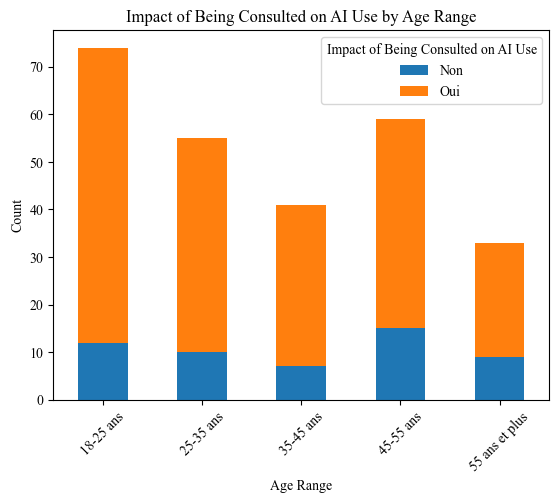

In [22]:
# 2/20 Impact of Being Consulted on AI Use by Age Range
impact_consulted_age = df_survey.groupby('Age')['ImpactOfBeingInvolved'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Impact of Being Consulted on AI Use by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Impact of Being Consulted on AI Use')
plt.show()

## 👀 Peur de perdre son emploi par tranche d'âge

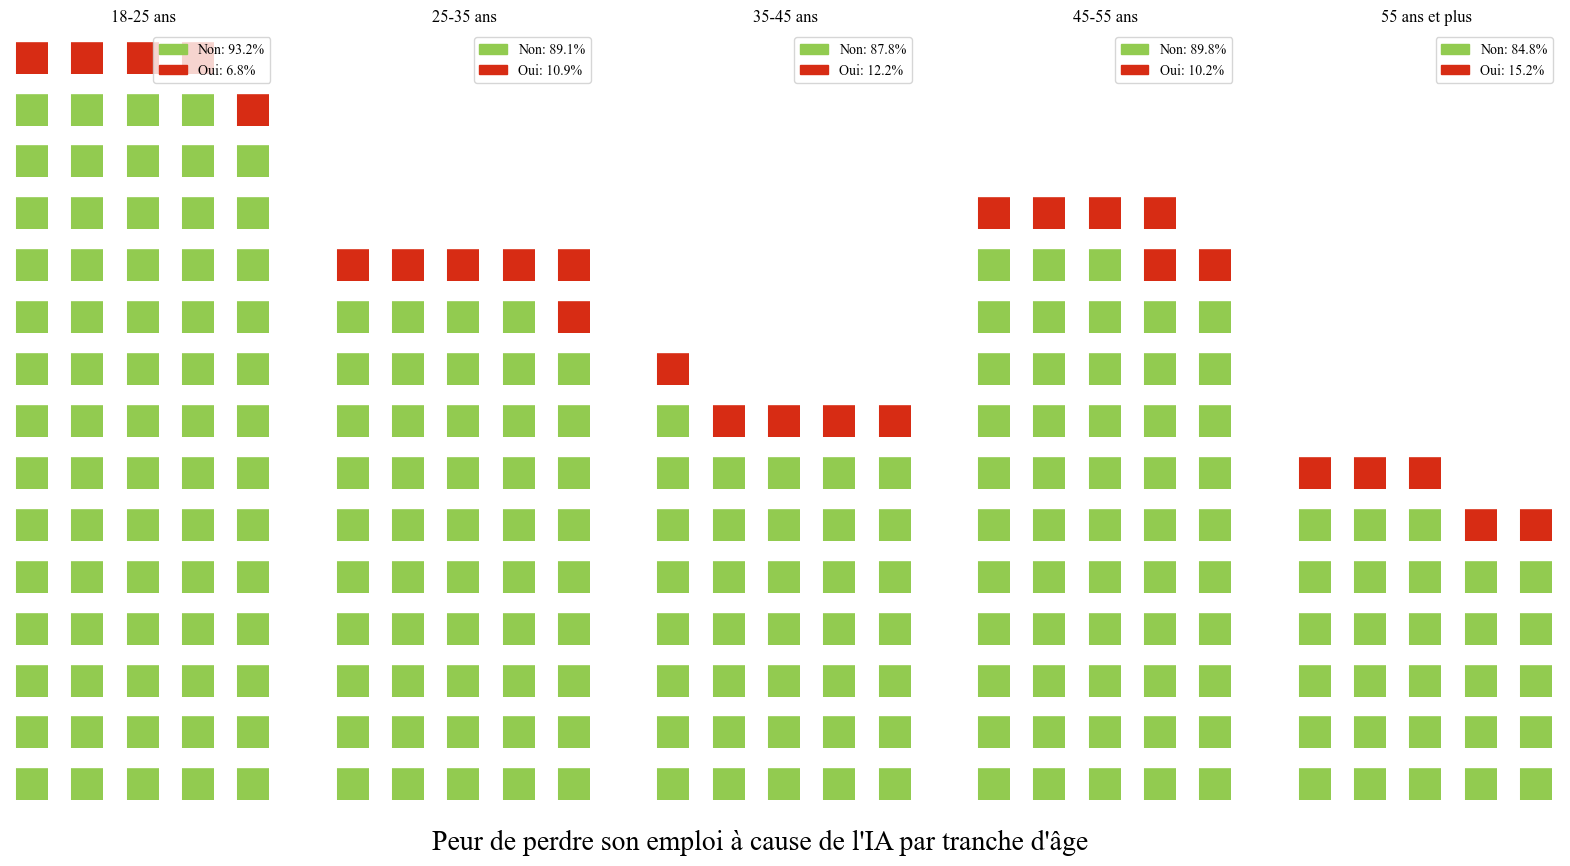

In [23]:
NUMBER_OF_COLUMNS = 5

# Get the max count of each age group
max_count = df_survey['Age'].value_counts().max()
# Get the closer multiple of NUMBER_OF_COLUMNS to the max count
TOTAL_VALUES = max_count + (NUMBER_OF_COLUMNS - max_count % NUMBER_OF_COLUMNS)

# Grouping the data
fear_lose_job_age = df_survey.groupby('Age')['FearOfJobLoss'].value_counts().unstack()

number_of_bars = len(fear_lose_job_age.index) # One bar per age range
colors = ['#92CB50', '#d72c14', "#ffffff"]

# Calculate the percentages for each age range
fear_lose_job_age_percentage = fear_lose_job_age.div(fear_lose_job_age.sum(axis=1), axis=0) * 100

# Init the whole figure and axes
fig, axs = plt.subplots(nrows=1, ncols=number_of_bars, figsize=(20, 10))

# We need to fill every bar with the same number of values until TOTAL_VALUES
DEFAULT_VALUE = 'empty'
for i, row in fear_lose_job_age.iterrows():
    if row.sum() < TOTAL_VALUES:
        fear_lose_job_age.loc[i, DEFAULT_VALUE] = TOTAL_VALUES - row.sum()
        fear_lose_job_age_percentage.loc[i, DEFAULT_VALUE] = 0

# Iterate over each bar and create it
for i, ax in enumerate(axs):
    row_name = fear_lose_job_age.index[i]
    values = fear_lose_job_age.loc[row_name].dropna()  # Values from the i-th row, dropping NaN values
    percentages = fear_lose_job_age_percentage.loc[row_name].dropna()  # Percentages from the i-th row, dropping NaN values

    Waffle.make_waffle(
        ax=ax,
        columns=NUMBER_OF_COLUMNS,
        colors=colors,
        values=values.to_dict(),
        characters = '■',
        font_size=50,
        vertical=True,
    )
    ax.set_title(row_name)

    # Create the legend with percentages for this subplot
    legend_elements = [mpatches.Patch(color=colors[j], 
                                      label=f"{k}: {percentages[k]:.1f}%") 
                       for j, k in enumerate(values.index) if k != DEFAULT_VALUE]

    ax.legend(handles=legend_elements, loc='upper right')

plt.figtext(0.5, 0.06, 'Peur de perdre son emploi à cause de l\'IA par tranche d\'âge', ha='center', fontsize=20)

plt.show()

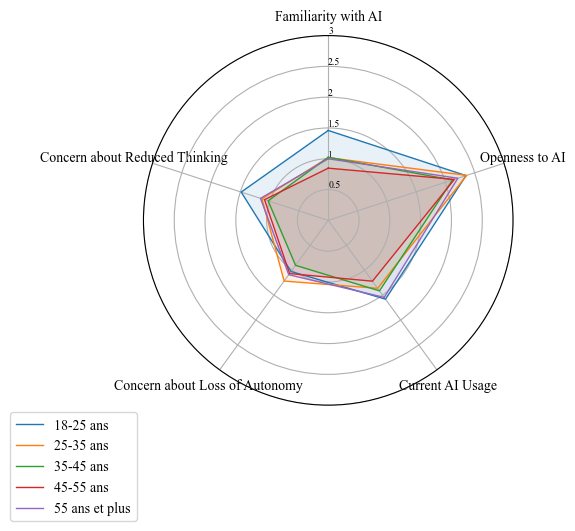

In [24]:
# Group by age range and calculate mean
age_general_data = df_survey.groupby('Age')[[
    '*Familiarity',
    '*Openness',
    '*Usage',
    '*LossOfAutonomy',
    '*ReducedThinking'
]].mean()

age_general_data.rename(columns={
    '*Familiarity': 'Familiarity with AI',
    '*Openness': 'Openness to AI',
    '*Usage': 'Current AI Usage',
    '*LossOfAutonomy': 'Concern about Loss of Autonomy',
    '*ReducedThinking': 'Concern about Reduced Thinking'
}, inplace=True)

# Reset index to make 'Age' a column again
age_general_data.reset_index(inplace=True)

# Rename 'Age' to 'age_group' to match the previous example
age_general_data.rename(columns={'Age': 'age_group'}, inplace=True)

# number of variable
survey_categories = list(age_general_data)[1:]
num_categories = len(survey_categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
axis_angles = [n / float(num_categories) * 2 * pi for n in range(num_categories)]
axis_angles += axis_angles[:1]

# Initialise the spider plot
spider_plot = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
spider_plot.set_theta_offset(pi / 2)
spider_plot.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(axis_angles[:-1], survey_categories)

# Draw ylabels
spider_plot.set_rlabel_position(0)
plt.yticks([0.5, 1, 1.5, 2, 2.5, 3], ["0.5", "1", "1.5", "2", "2.5", "3"], color="black", size=7)
plt.ylim(0,3)

# Plot each individual = each line of the data
for i, row in age_general_data.iterrows():
    category_values = row.drop('age_group').values.flatten().tolist()
    category_values += category_values[:1]
    spider_plot.plot(axis_angles, category_values, linewidth=1, linestyle='solid', label=str(row['age_group']))
    spider_plot.fill(axis_angles, category_values, alpha=0.1)

plt.legend(loc='upper right', bbox_to_anchor=(0, 0))
plt.show()

## ✅ 9. Réduction de capacité / age

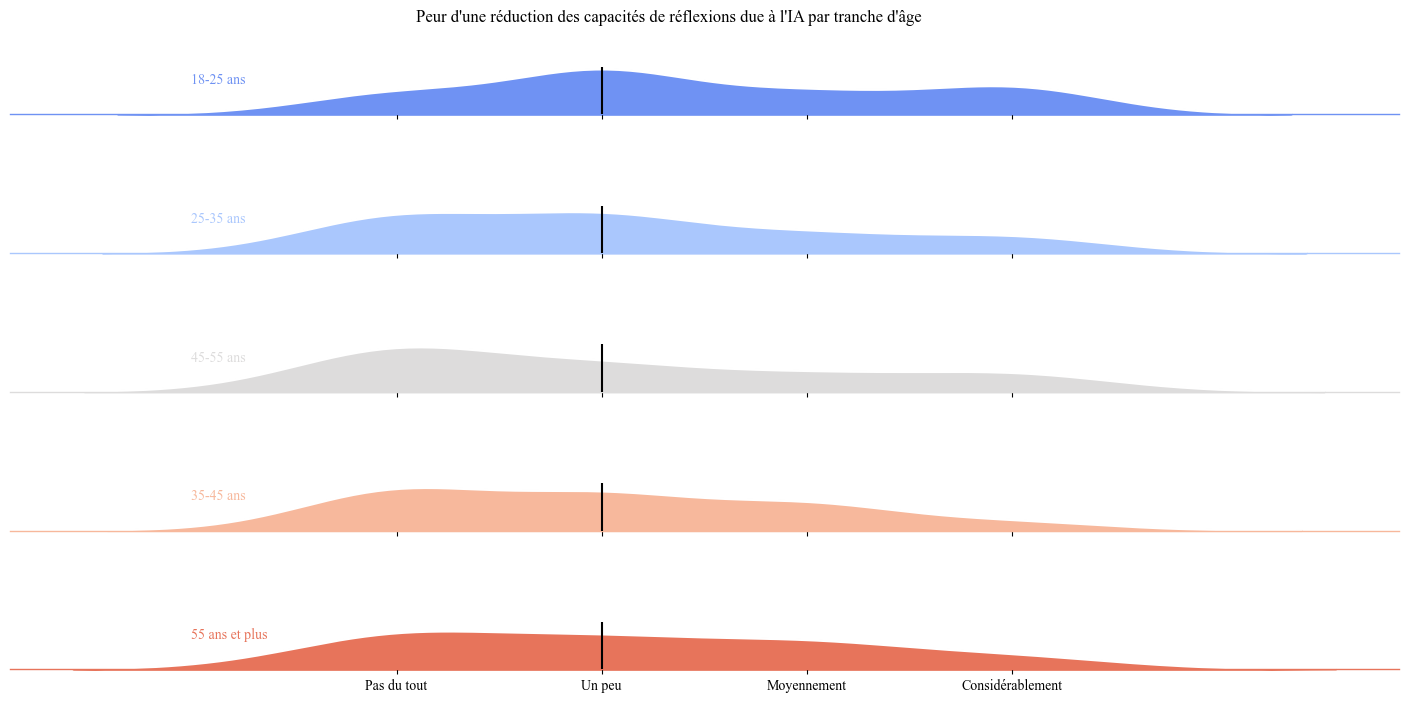

In [25]:
# Generate a color palette with Seaborn
pal = sns.color_palette(palette='coolwarm', n_colors=len(df_survey['Age'].unique()))

# Create the FacetGrid object
g = sns.FacetGrid(df_survey, row='Age', hue='Age', aspect=15, height=0.75, palette=pal)

# Add the densities kdeplots for each age range
g.map(sns.kdeplot, '*ReducedThinking',
      bw_adjust=1, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

# Add a white line that represents the contour of each kdeplot
g.map(sns.kdeplot, '*ReducedThinking',
      bw_adjust=1, clip_on=False, 
      color="w", lw=2)

# Add a horizontal line for each plot
g.map(plt.axhline, y=0,
      lw=1, clip_on=False)

#size the figure
g.fig.set_size_inches(15, 8)

# Add age range as text with the right color
for i, ax in enumerate(g.axes.flat):
    ax.text(-1, 0.25, df_survey['Age'].unique()[i],
            fontsize=10,
            color=ax.lines[-1].get_color())

    mean_value = df_survey[df_survey['Age'] == df_survey['Age'].unique()[i]]['*ReducedThinking'].median()
    ax.axvline(mean_value, color='black')

# Remove axes titles, yticks, and spines
g.set_titles("")
g.set(yticks=[])
g.set(ylabel="")  # Remove y label
g.despine(bottom=True, left=True)


g.fig.suptitle('Peur d\'une réduction des capacités de réflexions due à l\'IA par tranche d\'âge')
plt.xlabel('')

labels = ['Pas du tout', 'Un peu', 'Moyennement', 'Considérablement']
g.set(xticks=range(0, 4), xticklabels=labels)

plt.show()

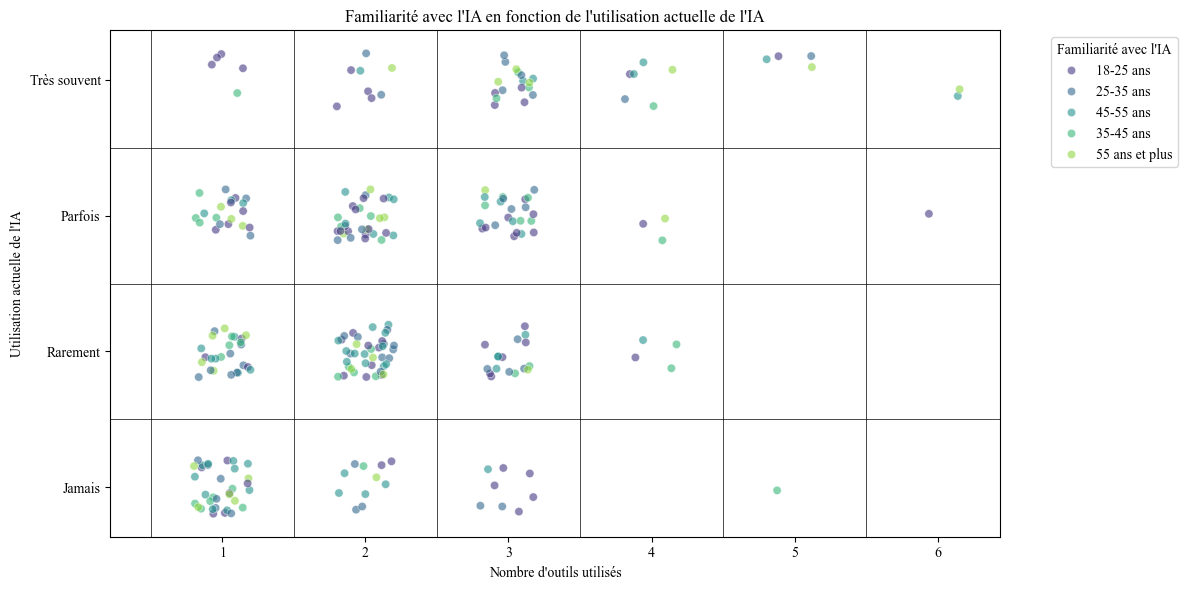

In [26]:
# 5/12 Familiarity with AI by Trust in AI Decisions
df_age_tools_usage = df_survey[['Age', '*Usage', 'Tools']].copy()

df_age_tools_usage['sum_tools'] = df_age_tools_usage['Tools'].apply(len)

jitter_strength = 0.2
df_age_tools_usage['*Usage'] = df_age_tools_usage['*Usage'].apply(lambda x: x + np.random.uniform(-jitter_strength, jitter_strength))
df_age_tools_usage['sum_tools'] = df_age_tools_usage['sum_tools'].apply(lambda x: x + np.random.uniform(-jitter_strength, jitter_strength))

# Visualisation avec seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_age_tools_usage, x='sum_tools', y='*Usage',
  sizes=(20, 200), hue='Age', palette='viridis', alpha=0.6)

for x in range(6):
    plt.axvline(x+0.5, color='black', linewidth=0.5)
for y in range(3):
    plt.axhline(y+0.5, color='black', linewidth=0.5)

plt.title('Familiarité avec l\'IA en fonction de l\'utilisation actuelle de l\'IA')
plt.xlabel('Nombre d\'outils utilisés')
plt.ylabel('Utilisation actuelle de l\'IA')
plt.yticks([0, 1, 2, 3], ['Jamais', 'Rarement', 'Parfois', 'Très souvent'])
plt.legend(title='Familiarité avec l\'IA', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



# ❓ 3&4. Dans quel secteur d'activité êtes vous ?

- [x] 3&4/5 Familiarité avec l'IA par secteur d'activité et service
- [ ] 3&4/6 Réfractarité à l’utilisation de l'IA au travail par secteur d'activité et service
- [ ] 3&4/7 Ouverture à l'utilisation des outils utilisant l'IA par secteur d'activité et service
- [x] 3&4/8&9 Utilisation des outils basés sur l'IA et types d'outils utilisés par secteur d'activité et service
- [x] 3&4/10 Motivations pour utiliser des outils basés sur l'IA par secteur d'activité et service
- [ ] 3&4/11 Problèmes rencontrés avec les outils basés sur l'IA par secteur d'activité et service
- [ ] 3&4/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par secteur d'activité et service
- [ ] 3&4/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par secteur d'activité et service
- [ ] 3&4/14 Perception de la perte d'autonomie due à l'IA par secteur d'activité et service
- [ ] 3&4/15 Perception de la réduction des capacités de réflexion due à l'IA par secteur d'activité et service
- [ ] 3&4/16 Crainte de perdre son emploi à cause de l'IA par secteur d'activité et service
- [ ] 3&4/17 Autres inquiétudes face à l'arrivée de l'IA par secteur d'activité et service
- [ ] 3&4/18 Inclusion dans le développement d'outils basés sur l'IA par secteur d'activité et service
- [ ] 3&4/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par secteur d'activité et service
- [ ] 3&4/20 Inclination à utiliser l'IA après consultation par secteur d'activité et service
- [ ] 3&4/21 Disposition à suivre une formation sur les technologies basées sur l'IA par secteur d'activité et service
- [ ] 3&4/22 Commentaires et suggestions sur l'arrivée de l'IA par secteur d'activité et service

---

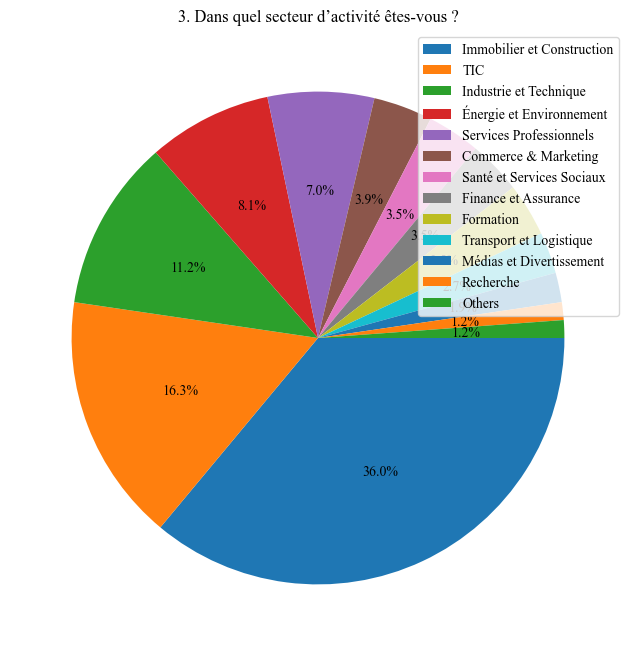

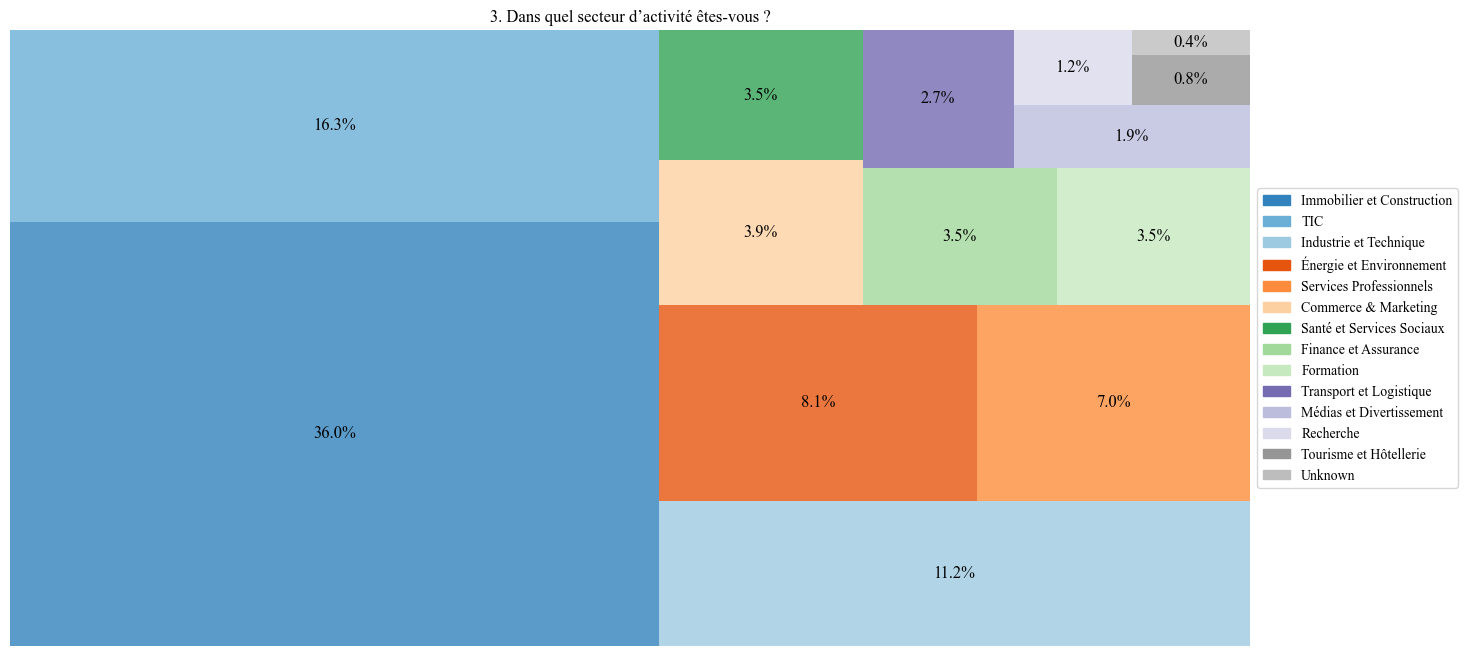

In [27]:
plot_pie('Sector', '3. Dans quel secteur d’activité êtes-vous ?')
plot_treemap('Sector', '3. Dans quel secteur d’activité êtes-vous ?')

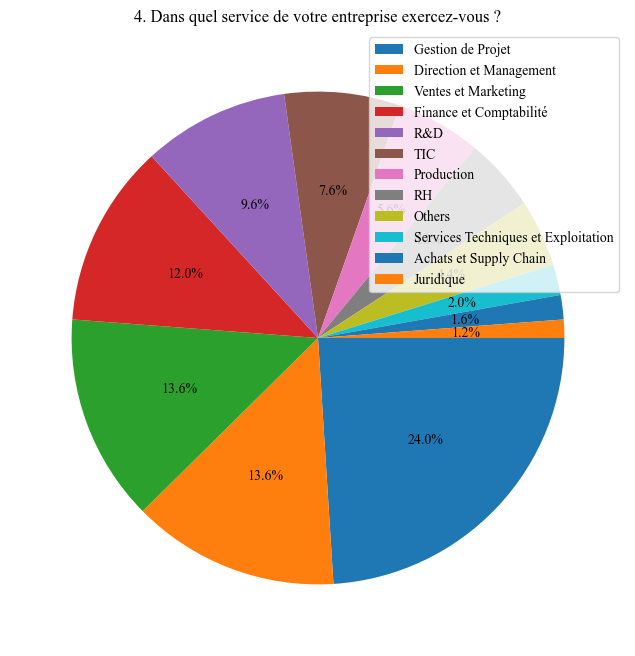

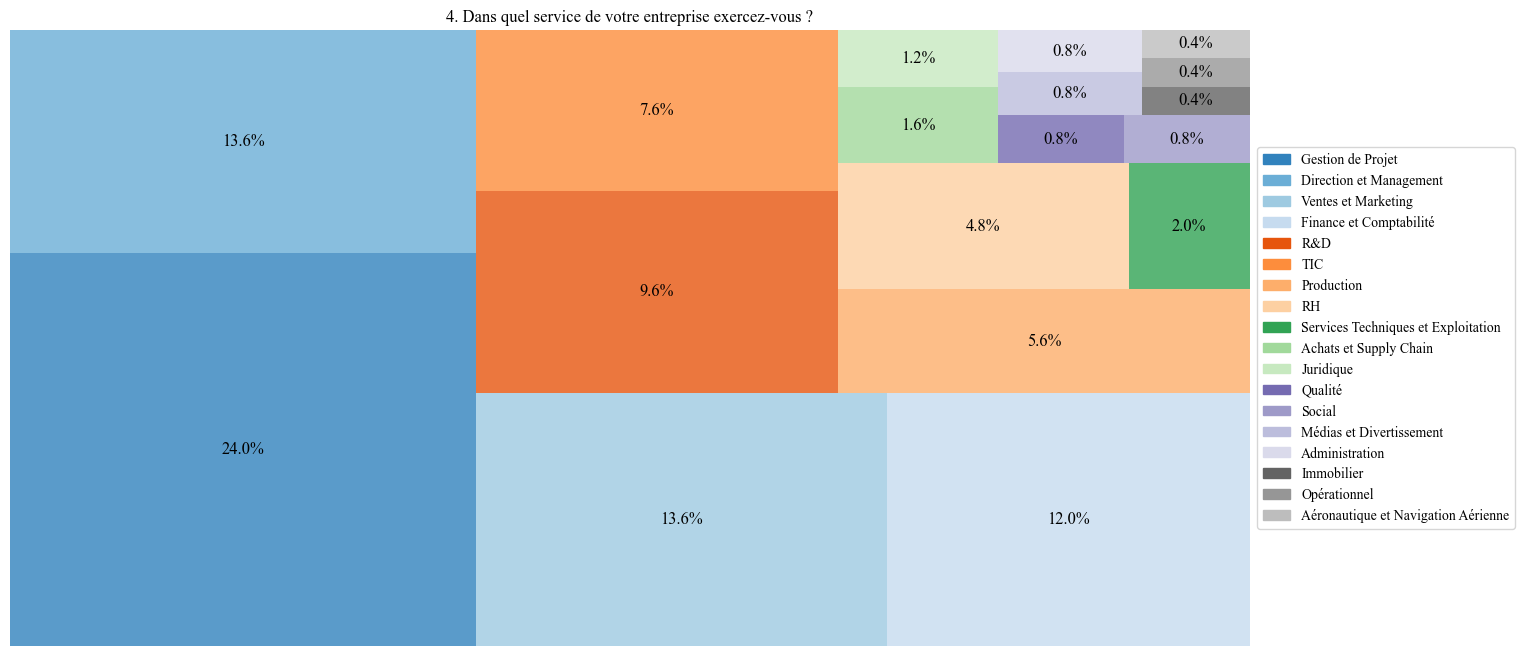

In [28]:
plot_pie('Department', '4. Dans quel service de votre entreprise exercez-vous ?')
plot_treemap('Department', '4. Dans quel service de votre entreprise exercez-vous ?')

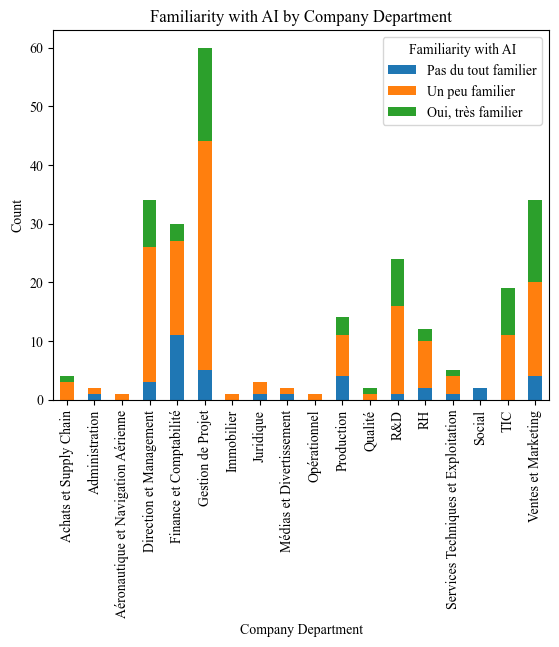

In [29]:
# 3&4/5 Familiarity with AI by Company Department
# faire le 3
familiarity_department = df_survey.groupby('Department')[
    'Familiarity'
].value_counts().unstack().reindex(columns=[
    'Pas du tout familier',
    'Un peu familier',
    'Oui, très familier'
]).plot(kind='bar', stacked=True)
plt.title('Familiarity with AI by Company Department')
plt.xlabel('Company Department')
plt.ylabel('Count')
plt.legend(title='Familiarity with AI')
plt.show()

## ✅ 2. Réfractaire / secteur & service

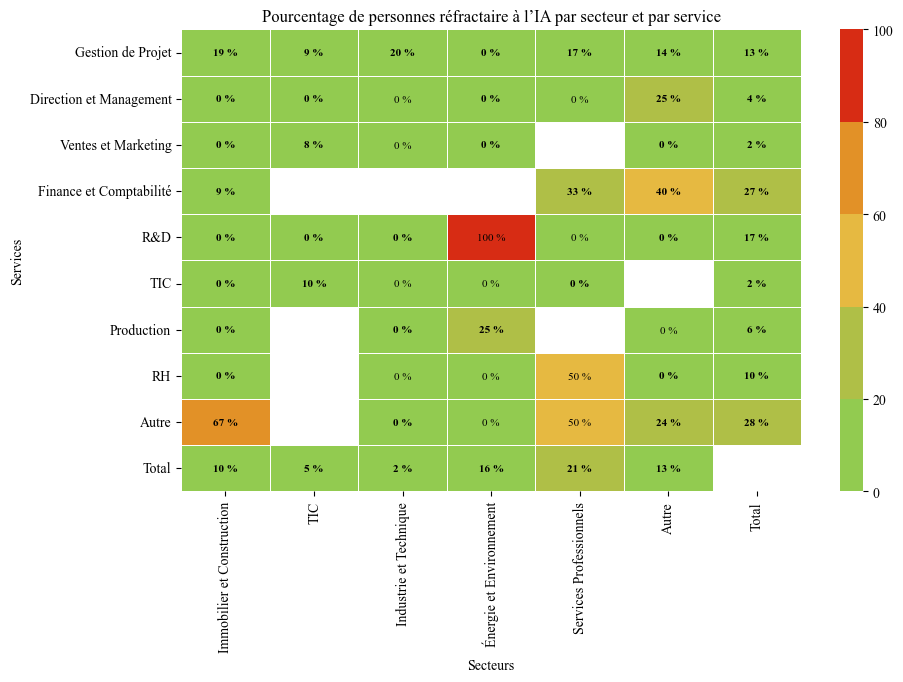

In [30]:
#TODO on peut ordonner l'affichage en fonction des %
#TODO faire des types
# 3&4/6 Resistance to AI by Sector and Department

DEPARTMENT_THRESHOLD = 10
SECTOR_THRESHOLD = 10

MIN_COUNT_THRESHOLD = 3

OTHER_LABEL = 'Autre'
TOT_LABEL = 'Total'

# Filter departments and sectors with more than threshold responses
valid_departments = df_survey['Department'].value_counts()[lambda x: x > DEPARTMENT_THRESHOLD].index
valid_sectors = df_survey['Sector'].value_counts()[lambda x: x > SECTOR_THRESHOLD].index

# Filter dataframe based on valid departments and sectors
filtered_df = df_survey[df_survey['Department'].isin(valid_departments) & df_survey['Sector'].isin(valid_sectors)]
filtered_df = filtered_df[['Department', 'Sector', 'Resistance']]

# Add OTHERS
for index, row in df_survey.iterrows():
    new_rows = []
    if row['Department'] in valid_departments:
        if row['Sector'] not in valid_sectors:
            new_rows.append({'Department': row['Department'], 'Sector': OTHER_LABEL, 'Resistance': row['Resistance']})
    if row['Sector'] in valid_sectors:
        if row['Department'] not in valid_departments:
            new_rows.append({'Department': OTHER_LABEL, 'Sector': row['Sector'], 'Resistance': row['Resistance']})
    else:
        new_rows.append({'Department': OTHER_LABEL, 'Sector': OTHER_LABEL, 'Resistance': row['Resistance']})

    filtered_df = pd.concat([filtered_df, pd.DataFrame(new_rows)], ignore_index=True)

all_sectors = list(valid_sectors) + [OTHER_LABEL]
all_departments = list(valid_departments) + [OTHER_LABEL]

# Calculate percentage of 'Non' for each valid sector and department
table_data = pd.DataFrame(index=all_departments, columns=all_sectors, dtype=float)
table_data_count = pd.DataFrame(index=all_departments, columns=all_sectors, dtype=int)

department_totals = {department: 0 for department in all_departments}
sector_totals = {sector: 0 for sector in all_sectors}

for department in all_departments:
    for sector in all_sectors:
        subset = filtered_df[(filtered_df['Department'] == department) & (filtered_df['Sector'] == sector)]
        count = len(subset)
        if len(subset) > 0:
            percentage = (1-(subset['Resistance'].value_counts(normalize=True).get('Non', 0))) * 100
            table_data.loc[department, sector] = percentage
            department_totals[department] += percentage
            sector_totals[sector] += percentage
        table_data_count.loc[department, sector] = count

# Calculate average totals
for department in department_totals:
    department_totals[department] /= table_data.loc[department].count()
for sector in sector_totals:
    sector_totals[sector] /= table_data[sector].count()

# Add totals to the table
for department in all_departments:
    table_data.loc[department, TOT_LABEL] = department_totals[department]
    table_data_count.loc[department, TOT_LABEL] = sum(table_data_count.loc[department, all_sectors])
for sector in all_sectors:
    table_data.loc[TOT_LABEL, sector] = sector_totals[sector]
    table_data_count.loc[TOT_LABEL, sector] = sum(table_data_count.loc[all_departments, sector])

colors = ["#92CB50", "#AFBF47", "#e6b941", "#e29127", "#d72c14"]
cmap = mcolors.ListedColormap(colors)

# Plot heatmap with red background
plt.figure(figsize=(10, 6))
ax = sns.heatmap(table_data, cmap=cmap, cbar=True, linewidths=.5)

# Add annotations manually
for i in range(table_data_count.shape[0]):
    for j in range(table_data_count.shape[1]):
        if not pd.isna(table_data.iloc[i, j]):
            if table_data_count.iloc[i, j] >= MIN_COUNT_THRESHOLD:
                ax.text(j+0.5, i+0.5, f"{table_data.iloc[i, j]:.0f} %",
                        color='black', ha='center', va='center',
                        fontweight='bold', fontsize=8)
            else:
                ax.text(j+0.5, i+0.5, f"{table_data.iloc[i, j]:.0f} %",
                        color='black', ha='center', va='center',
                        fontsize=8)

plt.title('Pourcentage de personnes réfractaire à l’IA par secteur et par service')
plt.xlabel('Secteurs')
plt.ylabel('Services')
plt.show()

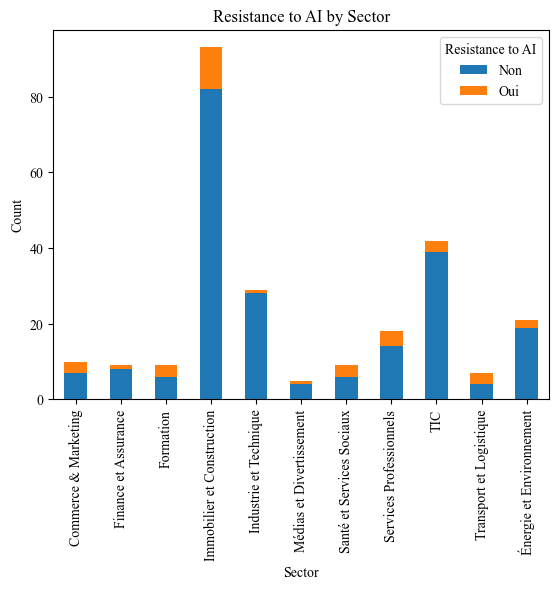

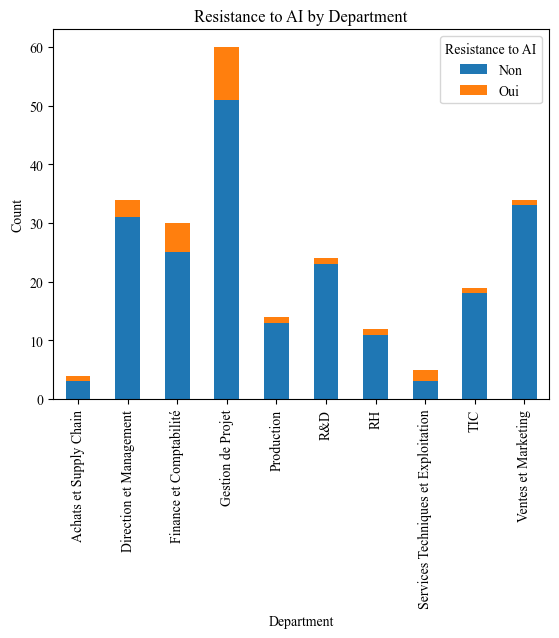

In [31]:
# Resistance to AI by sector
resistance_sector = df_survey.groupby('Sector')['Resistance'].value_counts().unstack()
# Drop sectors where less than 4 people voted
total_votes_per_sector = resistance_sector.sum(axis=1)
resistance_sector = resistance_sector[total_votes_per_sector >= 4]
resistance_sector.plot(kind='bar', stacked=True)
plt.title('Resistance to AI by Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.legend(title='Resistance to AI')
plt.show()

# Resistance to AI by Department
resistance_department = df_survey.groupby('Department')['Resistance'].value_counts().unstack()
# Drop sectors where less than 4 people voted
total_votes_per_department = resistance_department.sum(axis=1)
resistance_department = resistance_department[total_votes_per_department >= 4]
resistance_department.plot(kind='bar', stacked=True)
plt.title('Resistance to AI by Department')
plt.xlabel('Department')
plt.ylabel('Count')
plt.legend(title='Resistance to AI')
plt.show()

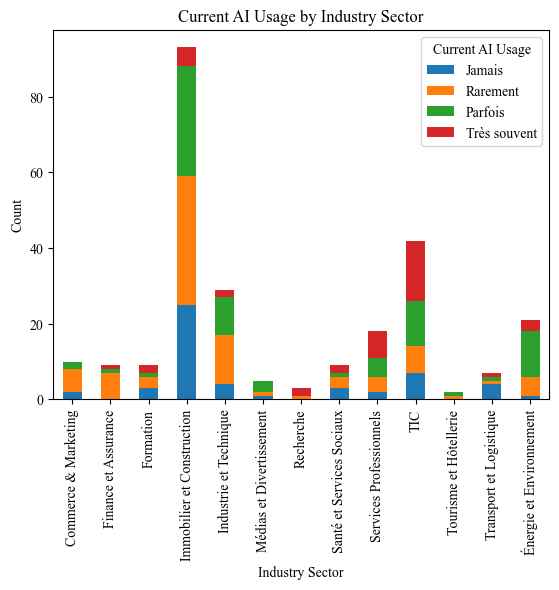

In [32]:
# 3&4/8 Current AI Usage by Industry Sector
# a revoir y'a que 3
# rajouter les tools ?
current_usage_sector = df_survey.groupby('Sector')['Usage'].value_counts().unstack().reindex(columns=[
  'Jamais',
  'Rarement',
  'Parfois',
  'Très souvent'
])
current_usage_sector.drop('Unknown', inplace=True, axis=0)
current_usage_sector.plot(kind='bar', stacked=True)
plt.title('Current AI Usage by Industry Sector')
plt.xlabel('Industry Sector')
plt.ylabel('Count')
plt.legend(title='Current AI Usage')
plt.show()

## ✅ 10. Utilisation / Age

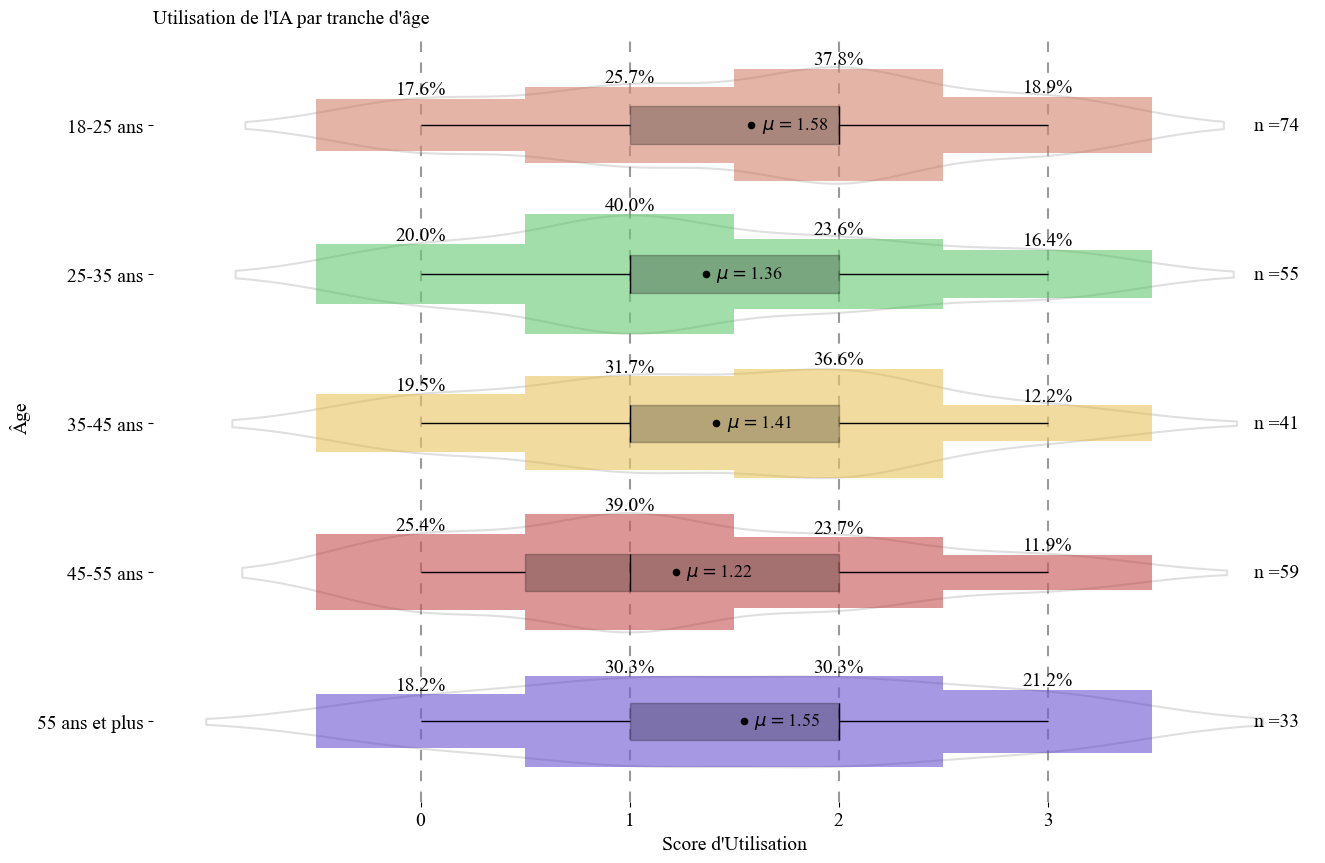

In [157]:
COLORS = ['#cb6d50', '#47bf57', '#e6b941', '#bc2f2f', '#4f33c9']

# Trier df_survey par 'Age'
df_survey_sorted = df_survey.sort_values('Age')

# afficher le n
fig, ax = plt.subplots(figsize=(15, 10))  # Ajustement de la taille pour mieux s'adapter à l'inversion des axes

usage_by_age = df_survey_sorted.groupby('Age')['*Usage'].value_counts(normalize=True).unstack().fillna(0)

# Configuration de l'arrière-plan
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Ajout de lignes verticales comme référence d'échelle
for h in [0, 1, 2, 3]:
    ax.axvline(h, color='grey', ls=(0, (5, 5)), alpha=0.8, zorder=0)

# Ajout des violons inversés
violins = sns.violinplot(y='Age', x='*Usage', data=df_survey_sorted, ax=ax, inner=None, color='lightgrey', orient='h')

# Personnalisation des violons
for pc in violins.collections:
    pc.set_edgecolor('grey')
    pc.set_facecolor('white')
    pc.set_linewidth(1.5)
    pc.set_alpha(0.25)

# Ajout des moyennes, ajustées pour l'inversion des axes
means = df_survey_sorted.groupby('Age')['*Usage'].mean().values
ages = sorted(df_survey_sorted['Age'].unique())

for i, mean in enumerate(means):
    ax.scatter(mean, i, s=20, color='black', zorder=3)
    ax.text(mean + 0.05, i, r"${\mu} = $" + str(round(mean, 2)), fontsize=13, ha='left', va='center')

# Ajout d'un boxplot inversé
sns.boxplot(y='Age', x='*Usage', data=df_survey_sorted, ax=ax, boxprops=dict(alpha=.25), width=0.25, orient='h', color='black', showcaps=False)

total_users_by_age = df_survey_sorted.groupby('Age').size()

for i, age in enumerate(ages):
  total = total_users_by_age[age]
  for usage in range(4):
    percentage = usage_by_age.loc[age, usage] * 100
    ax.text(usage, i - usage_by_age.loc[age, usage], f'{percentage:.1f}%', ha='center', va='bottom', color='black', fontsize=14)
    ax.barh(i, 1, left=usage-0.5, height=usage_by_age.loc[age, usage]*2, color=COLORS[i % len(COLORS)], alpha=0.5)
  # add total
  ax.text(4.2, i, f'n ={total}', ha='right', va='center', color='black', fontsize=14)

# Configuration des axes et du titre
ax.set_title('Utilisation de l\'IA par tranche d\'âge', loc='left', fontsize=14)
ax.set_ylabel('Âge', fontsize=14)
ax.set_xlabel('Score d\'Utilisation', fontsize=14)

plt.yticks(rotation=0, ha='right', fontsize=14)
plt.xticks(fontsize=14)

# Suppression des bordures
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Afficher uniquement les valeurs de 0 à 3 sur l'axe des x
ax.set_xticks(range(4))

plt.show()

## ✅ 8. Perte d'emploi / secteur & service

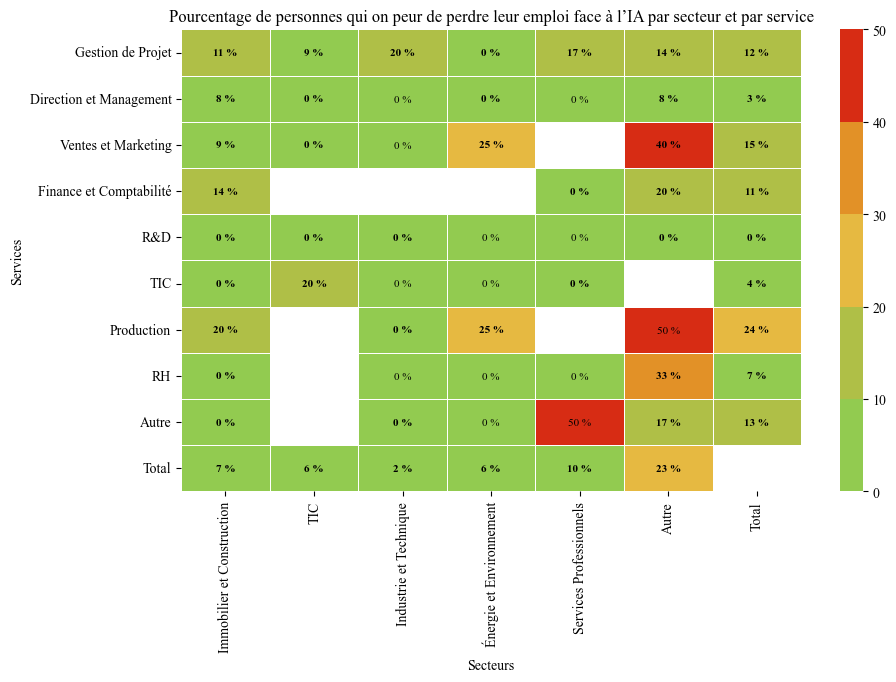

In [37]:
#TODO on peut ordonner l'affichage en fonction des %
# 3&4/6 FearOfJobLoss to AI by Sector and Department

DEPARTMENT_THRESHOLD = 10
SECTOR_THRESHOLD = 10

MIN_COUNT_THRESHOLD = 3

OTHER_LABEL = 'Autre'
TOT_LABEL = 'Total'

# Filter departments and sectors with more than threshold responses
valid_departments = df_survey['Department'].value_counts()[lambda x: x > DEPARTMENT_THRESHOLD].index
valid_sectors = df_survey['Sector'].value_counts()[lambda x: x > SECTOR_THRESHOLD].index

# Filter dataframe based on valid departments and sectors
filtered_df = df_survey[df_survey['Department'].isin(valid_departments) & df_survey['Sector'].isin(valid_sectors)]
filtered_df = filtered_df[['Department', 'Sector', 'FearOfJobLoss']]

for index, row in df_survey.iterrows():
    new_rows = []
    if row['Department'] in valid_departments:
        if row['Sector'] not in valid_sectors:
            new_rows.append({'Department': row['Department'], 'Sector': OTHER_LABEL, 'FearOfJobLoss': row['FearOfJobLoss']})
    if row['Sector'] in valid_sectors:
        if row['Department'] not in valid_departments:
            new_rows.append({'Department': OTHER_LABEL, 'Sector': row['Sector'], 'FearOfJobLoss': row['FearOfJobLoss']})
    else:
        new_rows.append({'Department': OTHER_LABEL, 'Sector': OTHER_LABEL, 'FearOfJobLoss': row['FearOfJobLoss']})

    filtered_df = pd.concat([filtered_df, pd.DataFrame(new_rows)], ignore_index=True)

all_sectors = list(valid_sectors) + [OTHER_LABEL]
all_departments = list(valid_departments) + [OTHER_LABEL]

# Calculate percentage of 'Non' for each valid sector and department
table_data = pd.DataFrame(index=all_departments, columns=all_sectors, dtype=float)
table_data_count = pd.DataFrame(index=all_departments, columns=all_sectors, dtype=int)

department_totals = {department: 0 for department in all_departments}
sector_totals = {sector: 0 for sector in all_sectors}

for department in all_departments:
    for sector in all_sectors:
        subset = filtered_df[(filtered_df['Department'] == department) & (filtered_df['Sector'] == sector)]
        count = len(subset)
        if len(subset) > 0:
            percentage = (1-(subset['FearOfJobLoss'].value_counts(normalize=True).get('Non', 0))) * 100
            table_data.loc[department, sector] = percentage
            department_totals[department] += percentage
            sector_totals[sector] += percentage
        table_data_count.loc[department, sector] = count

# Calculate average totals
for department in department_totals:
    department_totals[department] /= table_data.loc[department].count()
for sector in sector_totals:
    sector_totals[sector] /= table_data[sector].count()

# Add totals to the table
for department in all_departments:
    table_data.loc[department, TOT_LABEL] = department_totals[department]
    table_data_count.loc[department, TOT_LABEL] = sum(table_data_count.loc[department, all_sectors])
for sector in all_sectors:
    table_data.loc[TOT_LABEL, sector] = sector_totals[sector]
    table_data_count.loc[TOT_LABEL, sector] = sum(table_data_count.loc[all_departments, sector])

colors = ["#92CB50", "#AFBF47", "#e6b941", "#e29127", "#d72c14"]
cmap = mcolors.ListedColormap(colors)

# Plot heatmap with red background
plt.figure(figsize=(10, 6))
ax = sns.heatmap(table_data, cmap=cmap, cbar=True, linewidths=.5)

# Add annotations manually
for i in range(table_data_count.shape[0]):
    for j in range(table_data_count.shape[1]):
        if not pd.isna(table_data.iloc[i, j]):
            if table_data_count.iloc[i, j] >= MIN_COUNT_THRESHOLD:
                ax.text(j+0.5, i+0.5, f"{table_data.iloc[i, j]:.0f} %",
                        color='black', ha='center', va='center',
                        fontweight='bold', fontsize=8)
            else:
                ax.text(j+0.5, i+0.5, f"{table_data.iloc[i, j]:.0f} %",
                        color='black', ha='center', va='center',
                        fontsize=8)

plt.title('Pourcentage de personnes qui on peur de perdre leur emploi face à l’IA par secteur et par service')
plt.xlabel('Secteurs')
plt.ylabel('Services')
plt.show()

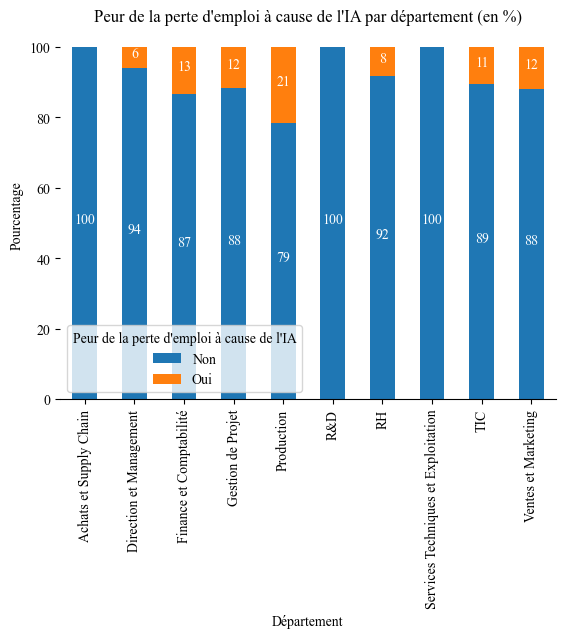

In [38]:
# Filtrer df_survey pour inclure uniquement les départements avec au moins 4 votes
votes_per_department = df_survey['Department'].value_counts()
departments_with_enough_votes = votes_per_department[votes_per_department >= 4].index
df_filtered = df_survey[df_survey['Department'].isin(departments_with_enough_votes)]

# Recalculer fear_jobloss_department après filtration
fear_jobloss_department = df_filtered.groupby('Department')['FearOfJobLoss'].value_counts().unstack()
total_votes_per_department = fear_jobloss_department.sum(axis=1)
fear_jobloss_department_percentage = fear_jobloss_department.div(total_votes_per_department, axis=0) * 100

# Tracer le graphique en barres empilées en pourcentage
ax = fear_jobloss_department_percentage.plot(kind='bar', stacked=True)

# Masquer les bordures droite, supérieure et gauche
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('Peur de la perte d\'emploi à cause de l\'IA par département (en %)')
plt.xlabel('Département')
plt.ylabel('Pourcentage')
plt.legend(title='Peur de la perte d\'emploi à cause de l\'IA')

# Ajouter des pourcentages sur chaque barre
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Afficher le pourcentage seulement si la hauteur est supérieure à 0
        ax.annotate(f'{height:.0f}', (x + width/2, y + height*0.5), ha='center', color='white')

plt.show()

# ❓ 5. Êtes-vous familier avec l'IA ?
- [ ] 5/6 Réfractarité à l’utilisation de l'IA au travail par familiarité avec l'IA
- [ ] 5/7 Ouverture à l'utilisation des outils utilisant l'IA par familiarité avec l'IA
- [x] 5/8&9 Utilisation des outils basés sur l'IA et types d'outils utilisés par familiarité avec l'IA
- [ ] 5/10 Motivations pour utiliser des outils basés sur l'IA par familiarité avec l'IA
- [x] 5/11 Problèmes rencontrés avec les outils basés sur l'IA par familiarité avec l'IA
- [x] 5/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par familiarité avec l'IA
- [ ] 5/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par familiarité avec l'IA
- [ ] 5/14 Perception de la perte d'autonomie due à l'IA par familiarité avec l'IA
- [ ] 5/15 Perception de la réduction des capacités de réflexion due à l'IA par familiarité avec l'IA
- [x] 5/16 Crainte de perdre son emploi à cause de l'IA par familiarité avec l'IA
- [ ] 5/17 Autres inquiétudes face à l'arrivée de l'IA par familiarité avec l'IA
- [ ] 5/18 Inclusion dans le développement d'outils basés sur l'IA par familiarité avec l'IA
- [ ] 5/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par familiarité avec l'IA
- [ ] 5/20 Inclination à utiliser l'IA après consultation par familiarité avec l'IA
- [ ] 5/21 Disposition à suivre une formation sur les technologies basées sur l'IA par familiarité avec l'IA
- [ ] 5/22 Commentaires et suggestions sur l'arrivée de l'IA par familiarité avec l'IA

---

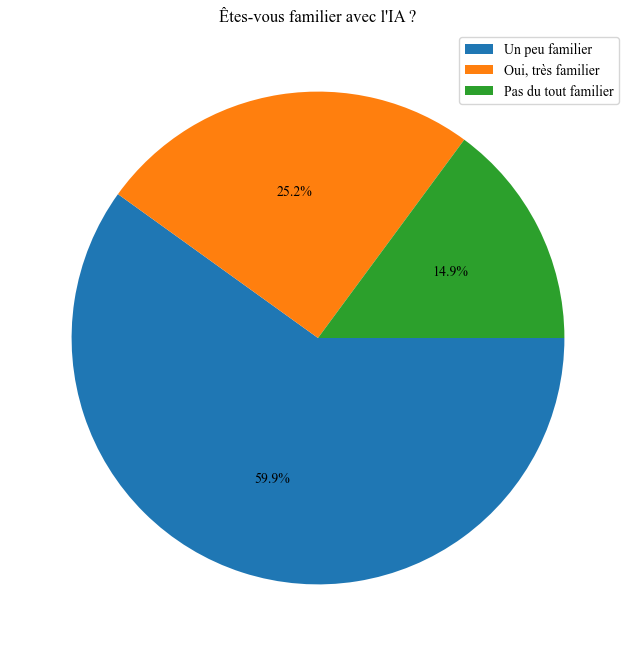

In [39]:
plot_pie('Familiarity', 'Êtes-vous familier avec l\'IA ?')

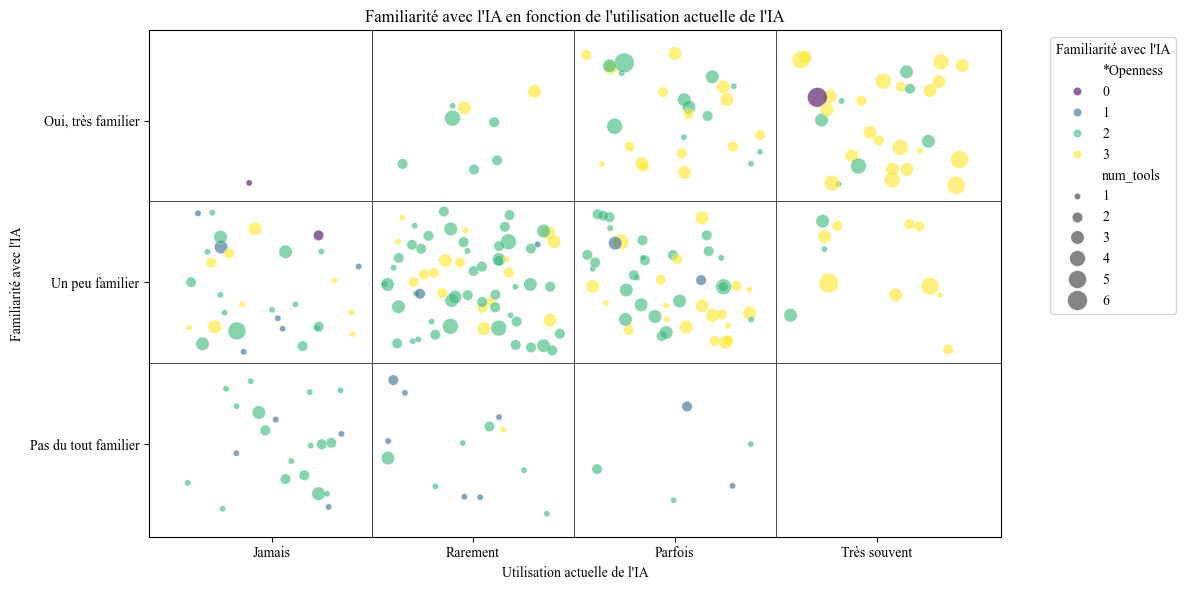

In [40]:
# 5/8&9 Check familiarity with AI avec "Usage" et "Tools"
## later we will maybe link it to the type of work
df_familiarity_tools = df_survey[['*Familiarity', '*Usage', 'Tools', '*Openness']].copy()

df_familiarity_tools['num_tools'] = df_familiarity_tools['Tools'].apply(len)

jitter_strength = 0.44
df_familiarity_tools['*Familiarity'] = df_familiarity_tools['*Familiarity'].apply(lambda x: x + np.random.uniform(-jitter_strength, jitter_strength))
df_familiarity_tools['*Usage'] = df_familiarity_tools['*Usage'].apply(lambda x: x + np.random.uniform(-jitter_strength, jitter_strength))

# Visualisation avec seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_familiarity_tools, x='*Usage', y='*Familiarity', size='num_tools',
  sizes=(20, 200), hue='*Openness', palette='viridis', alpha=0.6)

for x in range(3):
    plt.axvline(x+0.5, color='black', linewidth=0.5)
for y in range(2):
    plt.axhline(y+0.5, color='black', linewidth=0.5)

plt.title('Familiarité avec l\'IA en fonction de l\'utilisation actuelle de l\'IA')
plt.xlabel('Utilisation actuelle de l\'IA')
plt.xticks([0, 1, 2, 3], ['Jamais', 'Rarement', 'Parfois', 'Très souvent'])
plt.ylabel('Familiarité avec l\'IA')
plt.yticks([0, 1, 2], ['Pas du tout familier', 'Un peu familier', 'Oui, très familier'])
plt.legend(title='Familiarité avec l\'IA', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

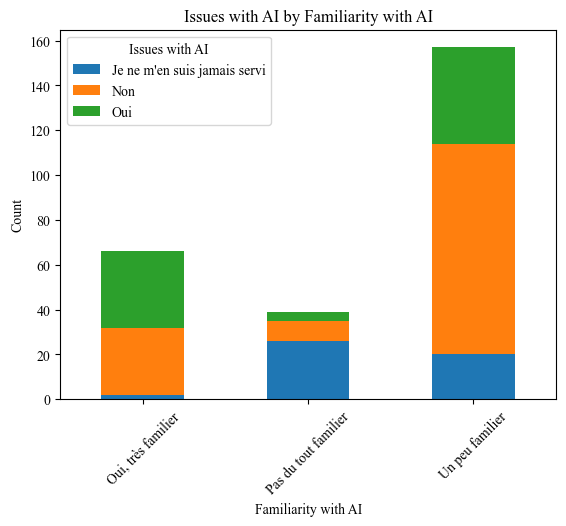

In [41]:
# 5/11 Issues with AI by Familiarity with AI
# faire les details en plus dans le graph
issues_familiarity = df_survey.groupby('Familiarity')['Issues'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Issues with AI by Familiarity with AI')
plt.xlabel('Familiarity with AI')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Issues with AI')
plt.show()

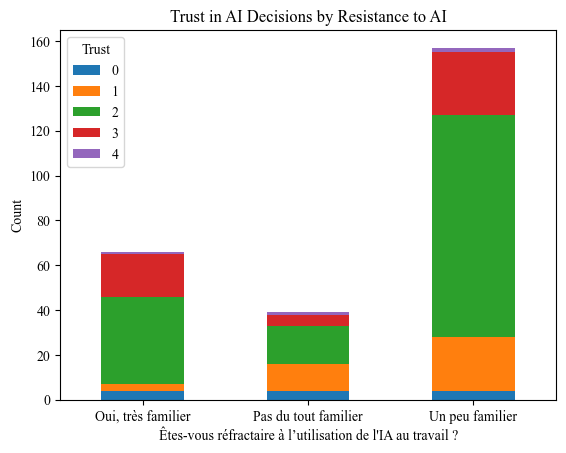

In [42]:
# 5/12 Trust in AI Decisions by Familiarity with AI
# Les gens qui trust connaissent bien la techno : on peut vérifier ça aussi avec "Usage" et "Tools" mais attention c'est lié au taff
trust_resistance = df_survey.groupby('Familiarity')['Trust'].value_counts().unstack()
trust_resistance.plot(kind='bar', stacked=True)
plt.title('Trust in AI Decisions by Resistance to AI')
plt.xlabel('Êtes-vous réfractaire à l’utilisation de l\'IA au travail ?')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

<Figure size 4000x600 with 0 Axes>

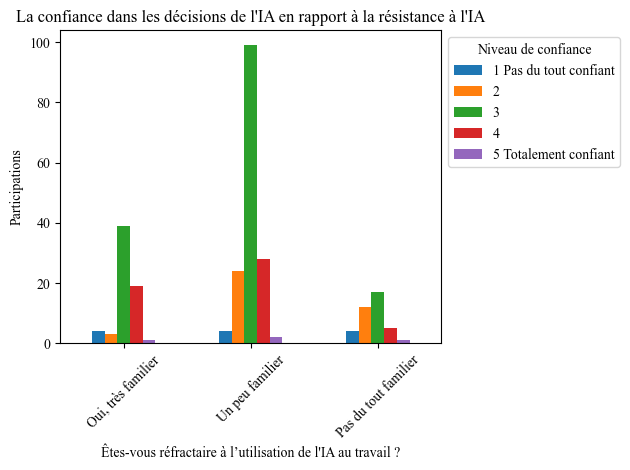

In [43]:
trust_resistance = df_survey.groupby('Familiarity')['Trust'].value_counts().unstack()

# Définir l'ordre souhaité pour l'axe des x
order = ["Oui, très familier", "Un peu familier", "Pas du tout familier"]

# Réindexer 'trust_resistance' selon l'ordre défini
trust_resistance = trust_resistance.reindex(order)

plt.figure(figsize=(40, 6))  # Définir une nouvelle taille de figure
trust_resistance.plot(kind='bar', stacked=False)

plt.title('La confiance dans les décisions de l\'IA en rapport à la résistance à l\'IA')
plt.xlabel('Êtes-vous réfractaire à l’utilisation de l\'IA au travail ?')
plt.ylabel('Participations')
plt.xticks(rotation=45)

# Ajuster la position de la légende
plt.legend(title='Niveau de confiance', labels=['1 Pas du tout confiant', '2', '3', '4', '5 Totalement confiant'], bbox_to_anchor=(1.0, 1), loc='upper left')

plt.tight_layout()  # Ajuster la mise en page pour éviter le chevauchement
plt.show()

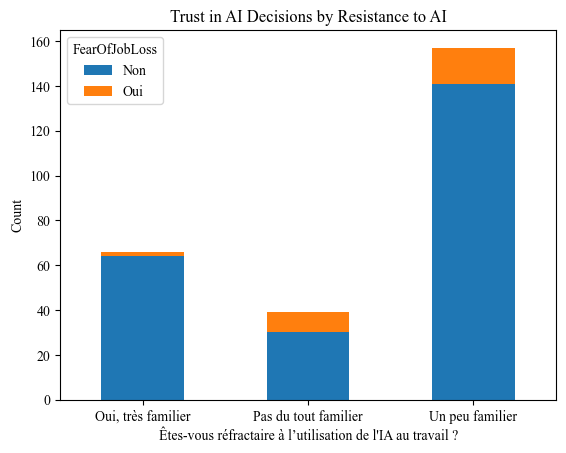

In [44]:
# 5/16 Familiarity by FearOfJobLoss
#? Les gens ont peur quand ils ne connaissent pas : on peut vérifier ça aussi avec "Usage" et "Tools" mais attention c'est lié au taff
trust_resistance = df_survey.groupby('Familiarity')['FearOfJobLoss'].value_counts().unstack()
trust_resistance.plot(kind='bar', stacked=True)
plt.title('Trust in AI Decisions by Resistance to AI')
plt.xlabel('Êtes-vous réfractaire à l’utilisation de l\'IA au travail ?')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 👀 TODO Familiarité avec le niveau de confiance

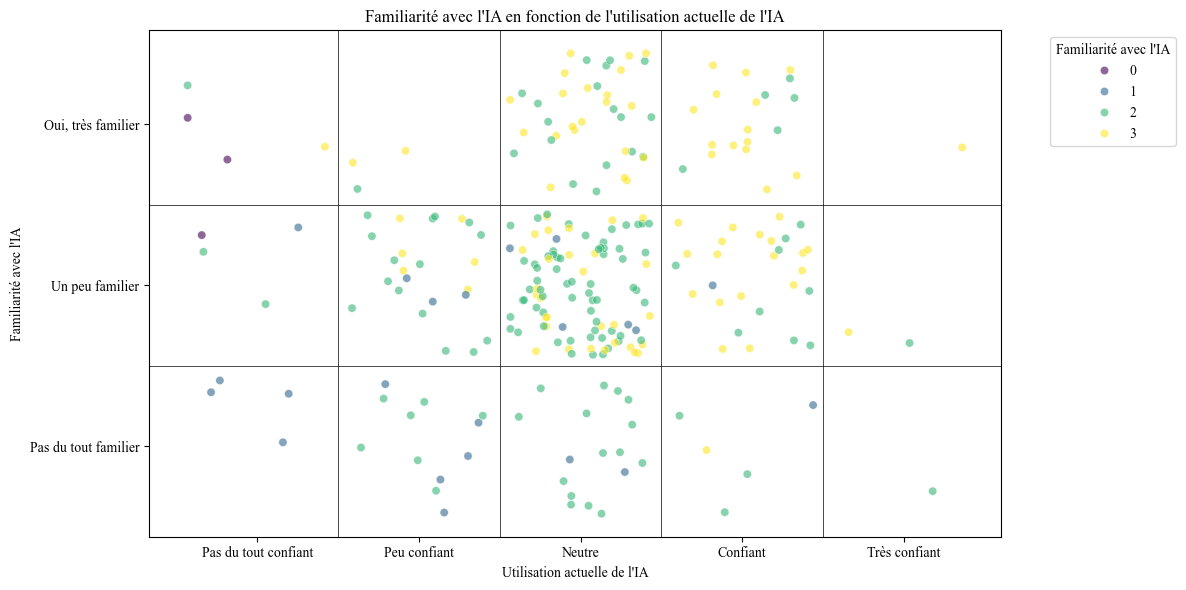

In [45]:
##TODO à faire
# 5/12 Familiarity with AI by Trust in AI Decisions
df_familiarity_tools = df_survey[['*Familiarity', 'Trust', '*Openness']].copy()

jitter_strength = 0.44
df_familiarity_tools['*Familiarity'] = df_familiarity_tools['*Familiarity'].apply(lambda x: x + np.random.uniform(-jitter_strength, jitter_strength))
df_familiarity_tools['Trust'] = df_familiarity_tools['Trust'].apply(lambda x: x + np.random.uniform(-jitter_strength, jitter_strength))

# Visualisation avec seaborn
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_familiarity_tools, x='Trust', y='*Familiarity',
  sizes=(20, 200), hue='*Openness', palette='viridis', alpha=0.6)

for x in range(4):
    plt.axvline(x+0.5, color='black', linewidth=0.5)
for y in range(2):
    plt.axhline(y+0.5, color='black', linewidth=0.5)

plt.title('Familiarité avec l\'IA en fonction de l\'utilisation actuelle de l\'IA')
plt.xlabel('Utilisation actuelle de l\'IA')
plt.xticks([0, 1, 2, 3, 4], ['Pas du tout confiant', 'Peu confiant', 'Neutre', 'Confiant', 'Très confiant'])
plt.ylabel('Familiarité avec l\'IA')
plt.yticks([0, 1, 2], ['Pas du tout familier', 'Un peu familier', 'Oui, très familier'])
plt.legend(title='Familiarité avec l\'IA', bbox_to_anchor=(1.05, 1), loc=2)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



Coefficients de régression : [0.04313142 0.48344211 0.85046081]


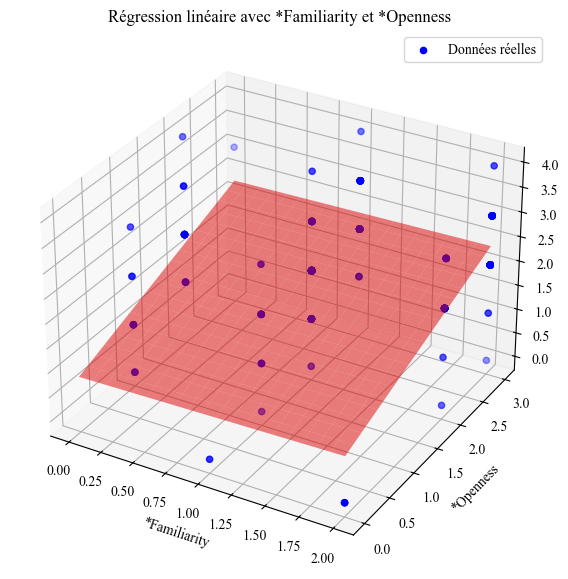

In [46]:
df_familiarity_tools = df_survey[['*Familiarity', 'Trust', '*Openness']].copy()

# Ajouter une colonne de biais (intercept) à nos données
X = df_familiarity_tools[['*Familiarity', '*Openness']]
X['Intercept'] = 1

y = df_familiarity_tools['Trust']

# Calculer les coefficients de régression
# np.linalg.inv pour l'inverse d'une matrice, np.dot pour le produit matriciel
# β=(X^{T}X)^{−1}X^{T}y 
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

# Afficher les coefficients
print("Coefficients de régression :", beta)

from mpl_toolkits.mplot3d import Axes3D

# Coefficients de régression obtenus précédemment
beta_familiarity = beta[0]
beta_openness = beta[1]
beta_intercept = beta[2]

# Préparer les données pour la visualisation
x_familiarity = df_familiarity_tools['*Familiarity']
x_openness = df_familiarity_tools['*Openness']
y = df_familiarity_tools['Trust']

# Créer une grille de valeurs pour *Familiarity et *Openness
x_familiarity_grid, x_openness_grid = np.meshgrid(np.linspace(x_familiarity.min(), x_familiarity.max(), 20),
                                                   np.linspace(x_openness.min(), x_openness.max(), 20))

# Calculer les valeurs prédites sur la grille
y_pred_grid = beta_familiarity * x_familiarity_grid + beta_openness * x_openness_grid + beta_intercept

# Créer le graphique 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Nuage de points avec les données réelles
ax.scatter(x_familiarity, x_openness, y, color='blue', label='Données réelles')

# Surface de régression
ax.plot_surface(x_familiarity_grid, x_openness_grid, y_pred_grid, color='red', alpha=0.5)

ax.set_xlabel('*Familiarity')
ax.set_ylabel('*Openness')
ax.set_zlabel('Trust')
ax.set_title('Régression linéaire avec *Familiarity et *Openness')
plt.legend()
plt.show()

# ❓ 6. Êtes-vous réfractaire à l’utilisation de l'IA au travail ?
- [ ] 6/7 Ouverture à l'utilisation des outils utilisant l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/8&9 Utilisation des outils basés sur l'IA et types d'outils utilisés par réfractarité à l’utilisation de l'IA
- [ ] 6/10 Motivations pour utiliser des outils basés sur l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/11 Problèmes rencontrés avec les outils basés sur l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par réfractarité à l’utilisation de l'IA
- [ ] 6/14 Perception de la perte d'autonomie due à l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/15 Perception de la réduction des capacités de réflexion due à l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/16 Crainte de perdre son emploi à cause de l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/17 Autres inquiétudes face à l'arrivée de l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/18 Inclusion dans le développement d'outils basés sur l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/20 Inclination à utiliser l'IA après consultation par réfractarité à l’utilisation de l'IA
- [ ] 6/21 Disposition à suivre une formation sur les technologies basées sur l'IA par réfractarité à l’utilisation de l'IA
- [ ] 6/22 Commentaires et suggestions sur l'arrivée de l'IA par réfractarité à l’utilisation de l'IA

---

## ✅ 1. Réfractaire oui / non

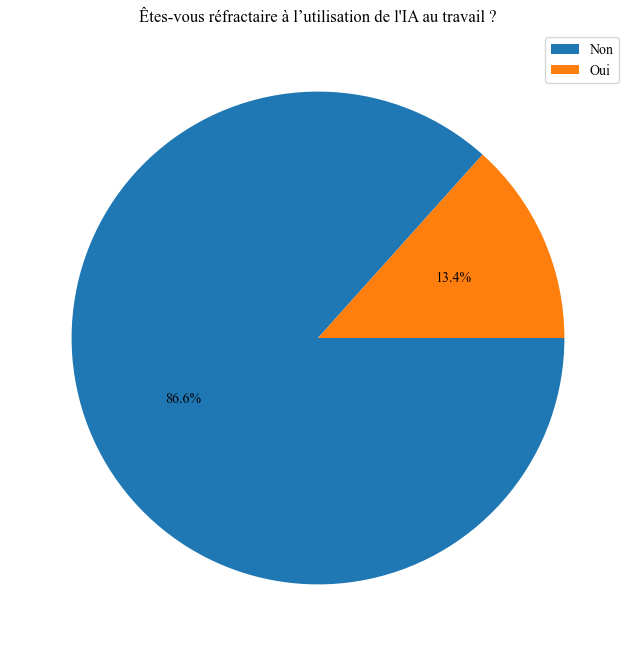

In [47]:
plot_pie('Resistance', 'Êtes-vous réfractaire à l’utilisation de l\'IA au travail ?')

✅ ON GARDE :  les deux vars sont décorélés 

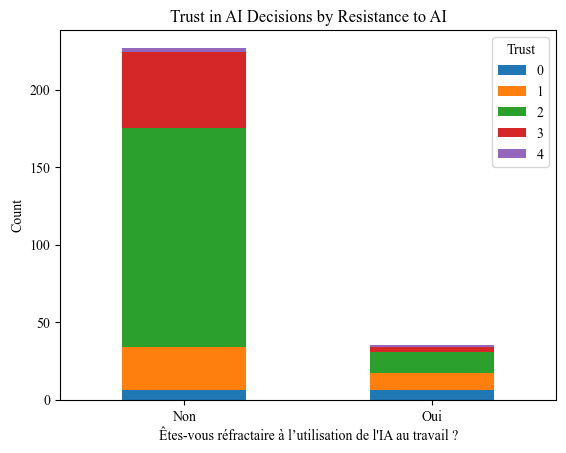

timestamp Gender             Age  \
0    06/05/2024 14:13:42  Autre       18-25 ans   
19   06/05/2024 17:40:10  Homme       25-35 ans   
20   06/05/2024 17:54:40  Homme  55 ans et plus   
37   07/05/2024 08:25:51  Homme       35-45 ans   
41   07/05/2024 09:29:43  Femme       18-25 ans   
46   07/05/2024 11:25:10  Homme       18-25 ans   
52   07/05/2024 11:59:14  Homme       35-45 ans   
56   07/05/2024 12:27:20  Homme  55 ans et plus   
65   07/05/2024 16:06:52  Homme       45-55 ans   
88   08/05/2024 23:02:56  Homme  55 ans et plus   
96   10/05/2024 19:21:21  Femme       18-25 ans   
105  13/05/2024 13:37:00  Homme       45-55 ans   
124  14/05/2024 10:03:55  Femme       25-35 ans   
136  14/05/2024 16:21:38  Homme       35-45 ans   
138  14/05/2024 17:39:07  Femme       45-55 ans   
139  14/05/2024 17:41:10  Homme       35-45 ans   
153  16/05/2024 16:30:10  Homme       25-35 ans   
167  20/05/2024 09:31:21  Homme       18-25 ans   
179  21/05/2024 22:45:12  Homme       18-25 ans   
184  22/05/2024 12:20:20  Femme       45-55 ans   
203  27/05/2024 10:01:37  Femme       18-25 ans   
209  29/05/2024 17:33:47  Homme       25-35 ans   
227  31/05/2024 14:52:44  Femme       45-55 ans   
229  01/06/2024 11:53:55  Femme       18-25 ans   
236  09/06/2024 23:13:18  Femme  55 ans et plus   
237  09/06/2024 23:29:16  Homme  55 ans et plus   
245  10/06/2024 11:29:35  Homme       35-45 ans   
246  10/06/2024 11:30:26  Homme  55 ans et plus   

                                               _Sector  \
0    Technologies de l'information et de la communi...   
19                                          Immobilier   
20                           Santé et services sociaux   
37   Technologies de l'information et de la communi...   
41                                  Commerce de détail   
46   Services professionnels (consulting, juridique...   
52   Technologies de l'information et de la communi...   
56                              Technique automatismes   
65                                          Immobilier   
88                                           Industrie   
96                         Construction et génie civil   
105                        Construction et génie civil   
124                             Tourisme et hôtellerie   
136                                          Industrie   
138                                         Immobilier   
139                                          Industrie   
153  Services professionnels (consulting, juridique...   
167  Services professionnels (consulting, juridique...   
179                                          Industrie   
184                           Énergie et environnement   
203                          Santé et services sociaux   
209                                         Immobilier   
227                                         Immobilier   
229                                         Immobilier   
236                        Construction et génie civil   
237                             Éducation et formation   
245  Technologies de l'information et de la communi...   
246  Technologies de l'information et de la communi...   

                            _Department           Familiarity Resistance  \
0                                   R&D       Un peu familier        Non   
19                       Investissement  Pas du tout familier        Non   
20                            Direction       Un peu familier        Non   
37   IT (Technologies de l'Information)       Un peu familier        Non   
41              Marketing/Communication       Un peu familier        Non   
46                    Gestion de projet    Oui, très familier        Non   
52                    Gestion de projet  Pas du tout familier        Non   
56                  Services techniques  Pas du tout familier        Non   
65                            Direction       Un peu familier        Non   
88                              Qualité       Un peu familier        Non   
96              

In [48]:
# 6/12 Trust in AI Decisions by Resistance to AI
trust_resistance = df_survey.groupby('Resistance')['Trust'].value_counts().unstack()
trust_resistance.plot(kind='bar', stacked=True)
plt.title('Trust in AI Decisions by Resistance to AI')
plt.xlabel('Êtes-vous réfractaire à l’utilisation de l\'IA au travail ?')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Certains réponde Non et ont un Trust in AI de 1 ? wtf
condition = (df_survey['Trust'] == 1) & (df_survey['Resistance'] == 'Non')
filtered_df = df_survey[condition]
display(filtered_df)

## ✅ 4. Réfractaire avant / après le texte explicatif

In [49]:
# compare Yes, No from Resistance with openess_to_ai_after_text

df_before_after = df_survey[['Resistance', 'Openness']].copy()

# Count the occurrences of each flow
flow_counts = df_before_after.groupby(['Resistance', 'Openness']).size().reset_index(name='count')

# Define the nodes and links for the Sankey diagram
labels = list(pd.concat([df_before_after['Resistance'], df_before_after['Openness']]).unique())

source = flow_counts['Resistance'].apply(lambda x: labels.index(x)).tolist()
target = flow_counts['Openness'].apply(lambda x: labels.index(x)).tolist()
value = flow_counts['count'].tolist()

# Define colors for each label based on specific criteria
colors = [
    '#60CA6F' if label == 'Très ouvert' else
    '#FFED65' if label == 'Plutôt ouvert' else
    '#ECA948' if label == 'Plutôt réticent' else
    '#D84637' if label == 'Très réticent' else
    '#AA0E10' if 'Oui' in label else
    '#538D69' for label in labels
]

# Create a dictionary to map labels to colors with added transparency
label_to_color_rgba = {
    label: f"rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.5)"
    for label, color in zip(labels, colors)
}

# Generate a color scale for the links based on the target node's color with transparency
link_colors_rgba = [label_to_color_rgba[labels[t]] for t in target]

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=colors
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color=link_colors_rgba,
        arrowlen=15
    )
)], layout=go.Layout(
    height=500,
    font=dict(size=10),
    title='Ouverture à l\'IA avant et après la lecture du texte',
))

# Add annotations for the question names
fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=-0.1,
            xref='paper',
            yref='paper',
            text="Êtes-vous réfractaire à l’utilisation de l'IA au travail ?",
            showarrow=False,
            font=dict(size=12)
        ),
        dict(
            x=1,
            y=-0.1,
            xref='paper',
            yref='paper',
            text="Après avoir lu ce texte, à quel point êtes-vous ouvert à l'idée d'utiliser des outils utilisant l'IA ?",
            showarrow=False,
            font=dict(size=12)
        )
    ]
)


fig.show()


## ✅ 10. Implication dans le développement

In [50]:
df_before_after = df_survey[['Involved', 'WantToBeInvolved', 'ImpactOfBeingInvolved']].copy()

sankey_dict_ids = {}
sankey_dict_count = {}

for index, row in df_before_after.iterrows():
    key1 = f"1{row['Involved']}"
    key2 = f"2{row['WantToBeInvolved']}"
    key3 = f"3{row['ImpactOfBeingInvolved']}"
    if key1 not in sankey_dict_ids:
        sankey_dict_ids[key1] = len(sankey_dict_ids)
    if key2 not in sankey_dict_ids:
        sankey_dict_ids[key2] = len(sankey_dict_ids)
    if key3 not in sankey_dict_ids:
        sankey_dict_ids[key3] = len(sankey_dict_ids)
    sankey_dict_count[key1+','+key2] = sankey_dict_count.get(key1+','+key2, 0) + 1
    sankey_dict_count[key2+','+key3] = sankey_dict_count.get(key2+','+key3, 0) + 1

# Construct DataFrame for Sankey diagram
data = [{'source': sankey_dict_ids[key.split(',')[0]],
         'target': sankey_dict_ids[key.split(',')[1]],
         'value': value}
        for key, value in sankey_dict_count.items()]

df_sankey = pd.DataFrame(data)

labels = [label[1:] for label in sankey_dict_ids.keys()]
# Define colors for each label based on specific criteria
colors = [
    '#60CA6F' if 'Oui' in label else
    '#D84637' if 'Non' in label else
    '#ECA948' for label in labels
]

# Create a dictionary to map labels to colors with added transparency
label_to_color_rgba = {
    label: f"rgba({int(color[1:3], 16)}, {int(color[3:5], 16)}, {int(color[5:7], 16)}, 0.5)"
    for label, color in zip(labels, colors)
}
# Generate a color scale for the links based on the target node's color with transparency
link_colors_rgba = [label_to_color_rgba[labels[source]] for source in df_sankey['source']]

fig = go.Figure(data=[go.Sankey(
  node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = labels,
    color = colors  # Use the colors list here
  ),
  link = dict(
    source = df_sankey['source'],
    target = df_sankey['target'],
    value = df_sankey['value'],
    color = link_colors_rgba,
    arrowlen=15,
  )
)], layout=go.Layout(
    height=500,
    font=dict(size=10),
    title='Implication dans l\'IA et impact sur le travail',
))

# Add annotations for the question names
fig.update_layout(
    annotations=[
        dict(
            x=0,
            y=-0.2,
            xref='paper',
            yref='paper',
            text="Avez-vous été inclus dans l’une des<br>phases de développement d’outils basés<br>sur l’IA dans votre entreprise ?",
            showarrow=False,
            font=dict(size=12)
        ),
        dict(
            x=0.5,
            y=-0.2,
            xref='paper',
            yref='paper',
            text="Dans le futur, aimeriez-vous être<br>consulté pour l’élaboration d’un outil basé<br>sur l’IA qui sera intégré dans votre entreprise ?",
            showarrow=False,
            font=dict(size=12)
        ),
        dict(
            x=1,
            y=-0.2,
            xref='paper',
            yref='paper',
            text="Si vous étiez consulté, seriez-vous<br>plus enclin à vous servir de<br>l’IA dans votre travail ?",
            showarrow=False,
            font=dict(size=12)
        )
    ]
)

fig.show()


# ❓ 7. Après avoir lu ce texte, à quel point êtes-vous ouvert à l'idée d'utiliser des outils utilisant l'IA ?
- [ ] 7/8&9 Utilisation des outils basés sur l'IA et types d'outils utilisés par ouverture à l'utilisation de l'IA
- [ ] 7/10 Motivations pour utiliser des outils basés sur l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/11 Problèmes rencontrés avec les outils basés sur l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par ouverture à l'utilisation de l'IA
- [ ] 7/14 Perception de la perte d'autonomie due à l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/15 Perception de la réduction des capacités de réflexion due à l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/16 Crainte de perdre son emploi à cause de l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/17 Autres inquiétudes face à l'arrivée de l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/18 Inclusion dans le développement d'outils basés sur l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/20 Inclination à utiliser l'IA après consultation par ouverture à l'utilisation de l'IA
- [ ] 7/21 Disposition à suivre une formation sur les technologies basées sur l'IA par ouverture à l'utilisation de l'IA
- [ ] 7/22 Commentaires et suggestions sur l'arrivée de l'IA par ouverture à l'utilisation de l'IA

---

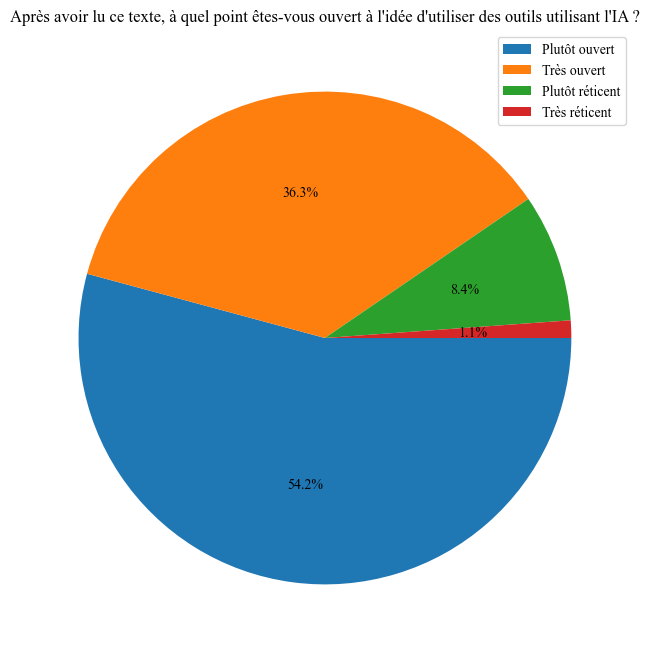

In [51]:
plot_pie('Openness', 'Après avoir lu ce texte, à quel point êtes-vous ouvert à l\'idée d\'utiliser des outils utilisant l\'IA ?')

# ❓ 8&9. Dans le cadre de votre travail, dans quelle mesure utilisez-vous des outils basés sur l'IA ? Utilisez-vous les outils suivants ?
- [x] 8/9 Utilisation des outils basés sur le type d'outils
- [ ] 8&9/10 Motivations pour utiliser des outils basés sur l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/11 Problèmes rencontrés avec les outils basés sur l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par utilisation des outils IA et types d'outils
- [ ] 8&9/14 Perception de la perte d'autonomie due à l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/15 Perception de la réduction des capacités de réflexion due à l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/16 Crainte de perdre son emploi à cause de l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/17 Autres inquiétudes face à l'arrivée de l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/18 Inclusion dans le développement d'outils basés sur l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/20 Inclination à utiliser l'IA après consultation par utilisation des outils IA et types d'outils
- [ ] 8&9/21 Disposition à suivre une formation sur les technologies basées sur l'IA par utilisation des outils IA et types d'outils
- [ ] 8&9/22 Commentaires et suggestions sur l'arrivée de l'IA par utilisation des outils IA et types d'outils

---

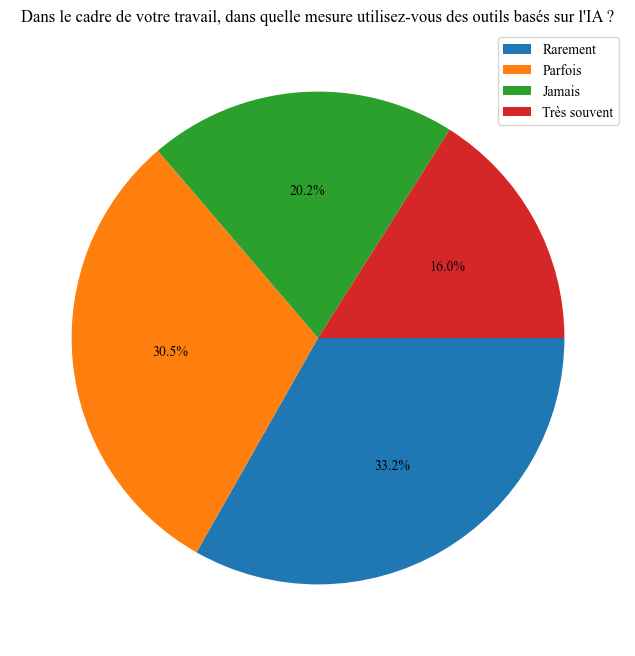

In [52]:
plot_pie('Usage', 'Dans le cadre de votre travail, dans quelle mesure utilisez-vous des outils basés sur l\'IA ?')

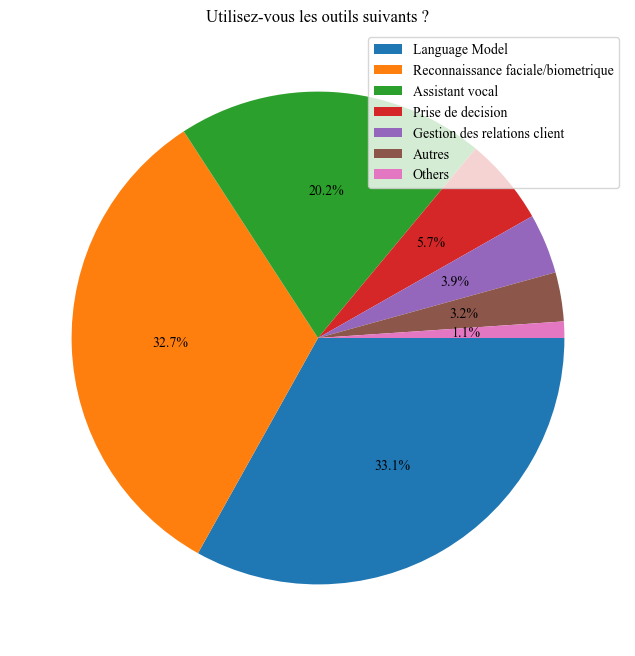

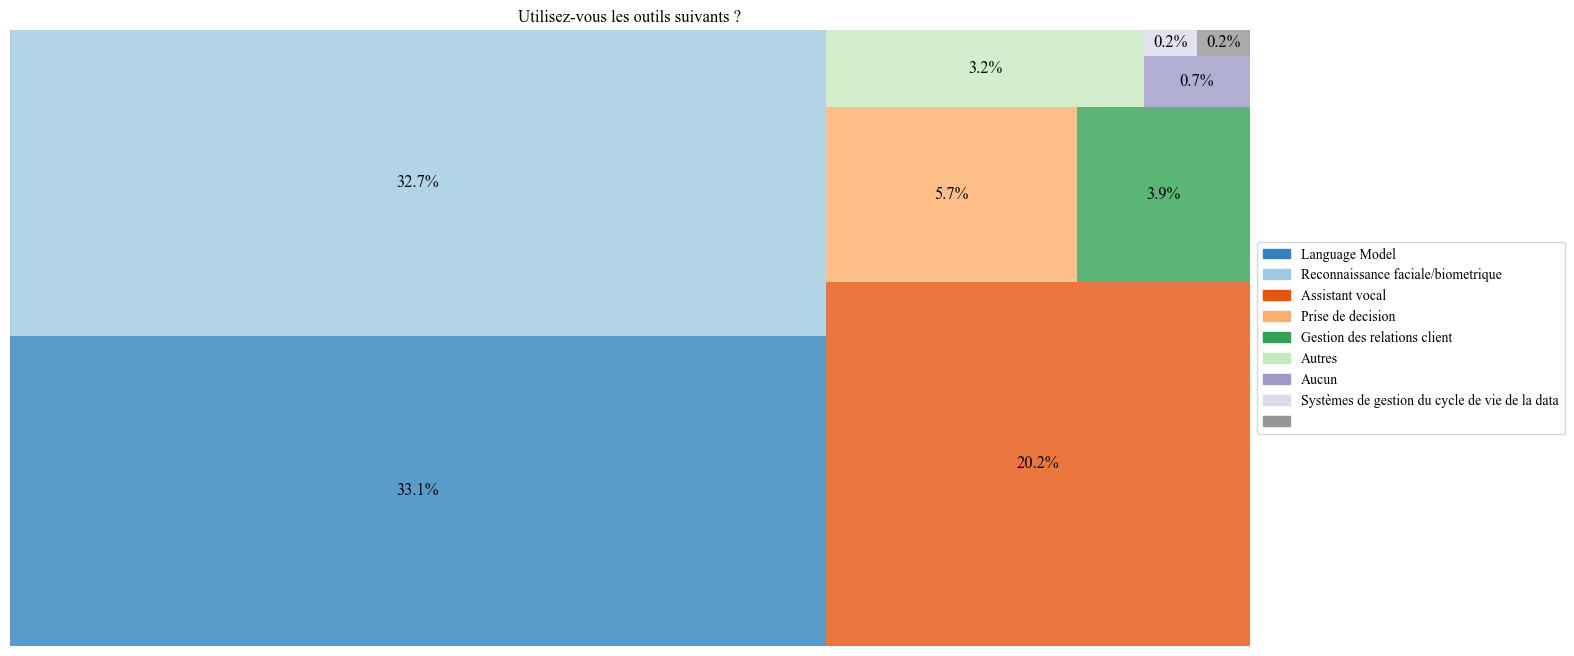

In [53]:
plot_pie('Tools', 'Utilisez-vous les outils suivants ?')
plot_treemap('Tools', 'Utilisez-vous les outils suivants ?')

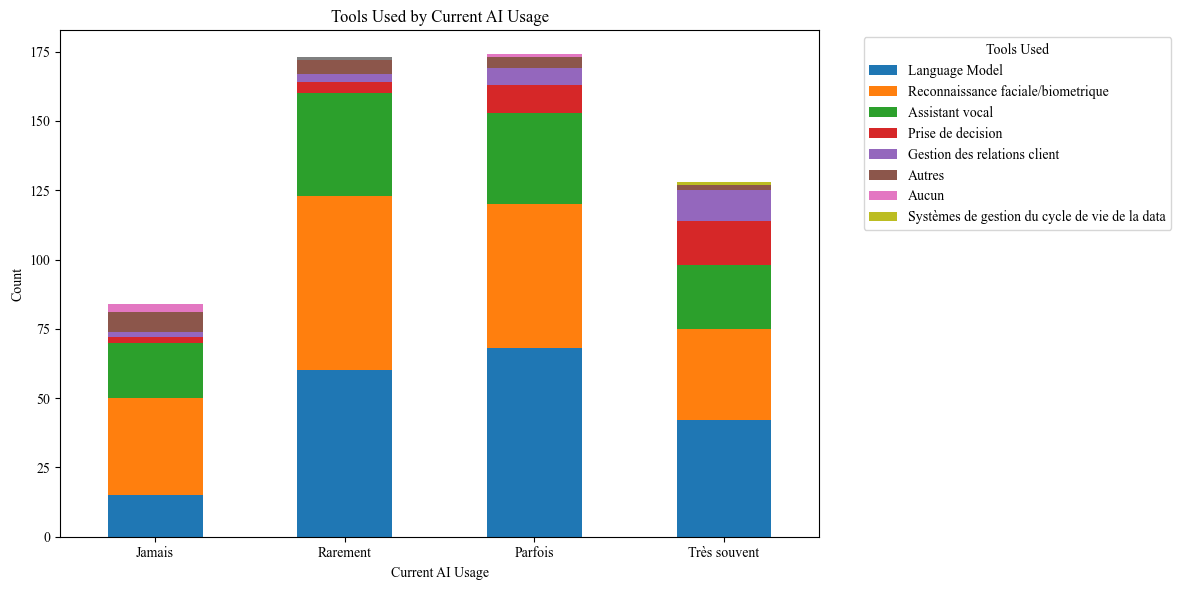

In [54]:
# 8/9 Tools Used by Current AI Usage
df_exploded = df_survey.explode('Tools')
df_grouped = df_exploded.groupby(['*Usage', 'Tools']).size().unstack().fillna(0)

# Sum the values for each tool and sort them
tool_order = df_grouped.sum().sort_values(ascending=False).index

# Sort the DataFrame according to the tool order
df_grouped = df_grouped[tool_order]

# Plot stacked bar chart
df_grouped.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Tools Used by Current AI Usage')
plt.xlabel('Current AI Usage')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['Jamais', 'Rarement', 'Parfois', 'Très souvent'], rotation=0)
plt.legend(title='Tools Used', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

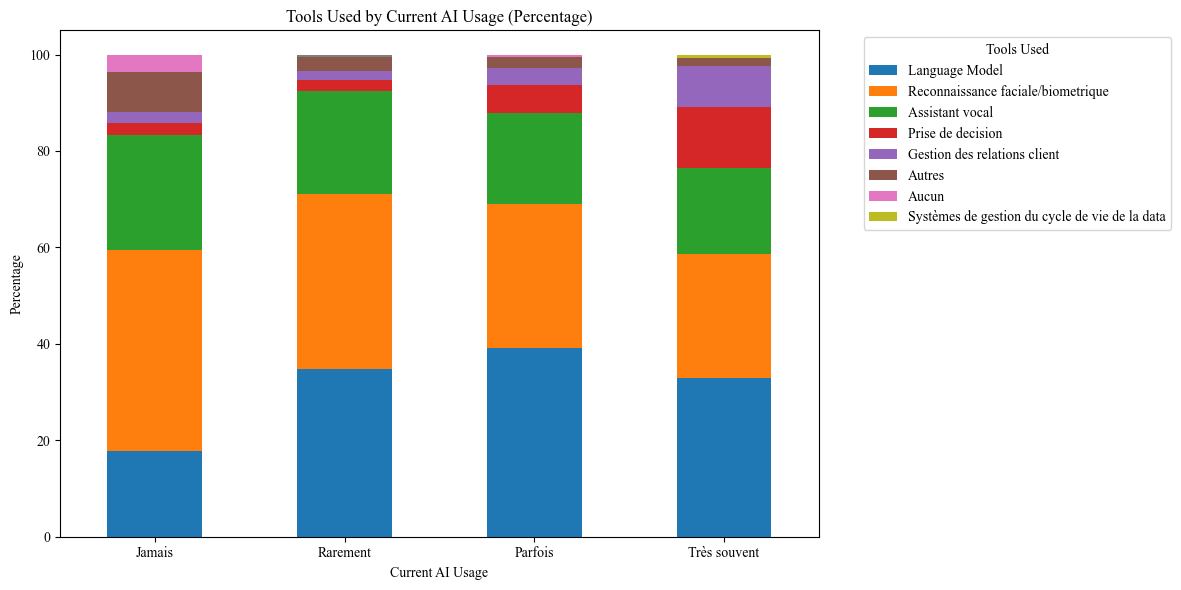

In [55]:
# Convert the values to percentages
df_grouped_percentage = df_grouped.divide(df_grouped.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
df_grouped_percentage.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Tools Used by Current AI Usage (Percentage)')
plt.xlabel('Current AI Usage')
plt.ylabel('Percentage')
plt.xticks([0, 1, 2, 3], ['Jamais', 'Rarement', 'Parfois', 'Très souvent'], rotation=0)
plt.legend(title='Tools Used', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()

## 👀 Usage par secteur / departement
#### ceux qui utilisent jamais d'IA, ils ont peur ou pas ?


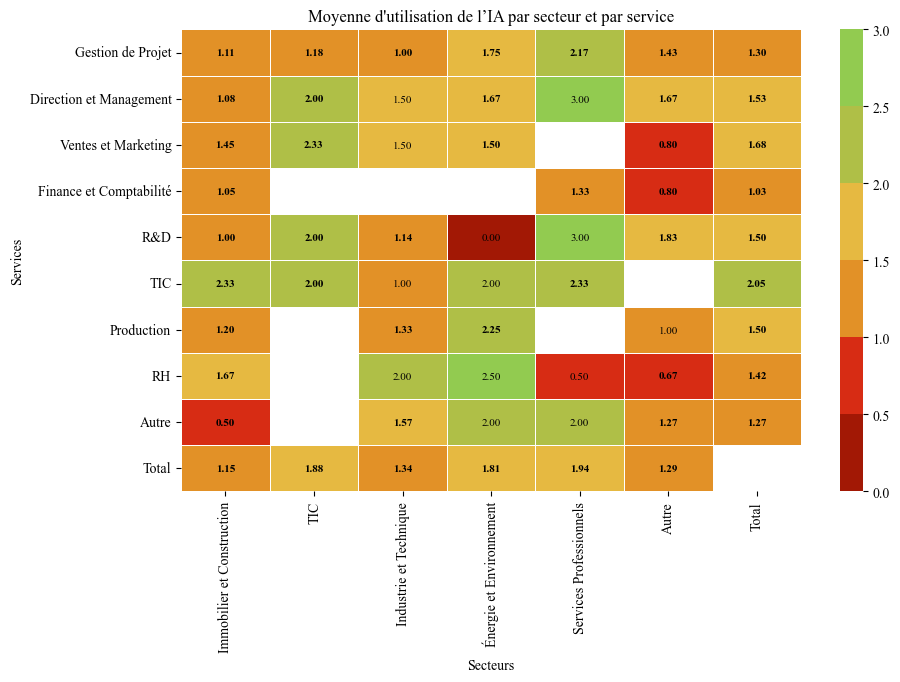

In [56]:
#TODO on peut ordonner l'affichage en fonction des means
# 3&4/6 *Usage to AI by Sector and Department

DEPARTMENT_THRESHOLD = 10
SECTOR_THRESHOLD = 10

MIN_COUNT_THRESHOLD = 3

OTHER_LABEL = 'Autre'
TOT_LABEL = 'Total'

# Filter departments and sectors with more than threshold responses
valid_departments = df_survey['Department'].value_counts()[lambda x: x > DEPARTMENT_THRESHOLD].index
valid_sectors = df_survey['Sector'].value_counts()[lambda x: x > SECTOR_THRESHOLD].index

# Filter dataframe based on valid departments and sectors
filtered_df = df_survey[df_survey['Department'].isin(valid_departments) & df_survey['Sector'].isin(valid_sectors)]
filtered_df = filtered_df[['Department', 'Sector', '*Usage']]

for index, row in df_survey.iterrows():
    new_rows = []
    if row['Department'] in valid_departments:
        if row['Sector'] not in valid_sectors:
            new_rows.append({'Department': row['Department'], 'Sector': OTHER_LABEL, '*Usage': row['*Usage']})
    if row['Sector'] in valid_sectors:
        if row['Department'] not in valid_departments:
            new_rows.append({'Department': OTHER_LABEL, 'Sector': row['Sector'], '*Usage': row['*Usage']})
    else:
        new_rows.append({'Department': OTHER_LABEL, 'Sector': OTHER_LABEL, '*Usage': row['*Usage']})

    filtered_df = pd.concat([filtered_df, pd.DataFrame(new_rows)], ignore_index=True)

all_sectors = list(valid_sectors) + [OTHER_LABEL]
all_departments = list(valid_departments) + [OTHER_LABEL]

# Calculate percentage of 'Non' for each valid sector and department
table_data = pd.DataFrame(index=all_departments, columns=all_sectors, dtype=float)
table_data_count = pd.DataFrame(index=all_departments, columns=all_sectors, dtype=int)

department_totals = {department: 0 for department in all_departments}
sector_totals = {sector: 0 for sector in all_sectors}

for department in all_departments:
    for sector in all_sectors:
        subset = filtered_df[(filtered_df['Department'] == department) & (filtered_df['Sector'] == sector)]
        count = len(subset)
        if len(subset) > 0:
            mean = subset['*Usage'].mean()
            table_data.loc[department, sector] = mean
            department_totals[department] += mean*count
            sector_totals[sector] += mean*count
        table_data_count.loc[department, sector] = count

# Total mean of lines and columns
for department in department_totals.keys():
    if department in table_data_count.index:  # Vérifiez si le département existe
        department_sum = table_data_count.loc[department].sum()
        if department_sum > 0:
            department_totals[department] /= department_sum
    else:
        department_totals[department] = 0  # Attribuez une valeur par défaut si le département n'existe pas

for sector in sector_totals.keys():
    if sector in table_data_count.columns:  # Vérifiez si le secteur existe
        sector_sum = table_data_count[sector].sum()
        if sector_sum > 0:
            sector_totals[sector] /= sector_sum
    else:
        sector_totals[sector] = 0  # Attribuez une valeur par défaut si le secteur n'existe pas

# Add totals to the table
for department in all_departments:
    table_data.loc[department, TOT_LABEL] = department_totals[department]
    table_data_count.loc[department, TOT_LABEL] = sum(table_data_count.loc[department, all_sectors])
for sector in all_sectors:
    table_data.loc[TOT_LABEL, sector] = sector_totals[sector]
    table_data_count.loc[TOT_LABEL, sector] = sum(table_data_count.loc[all_departments, sector])

colors = ["#A21805", "#d72c14", "#e29127", "#e6b941", "#AFBF47", "#92CB50"]
cmap = mcolors.ListedColormap(colors)

# Plot heatmap with red background
plt.figure(figsize=(10, 6))
ax = sns.heatmap(table_data, cmap=cmap, cbar=True, linewidths=.5)

# Add annotations manually
for i in range(table_data_count.shape[0]):
    for j in range(table_data_count.shape[1]):
        if not pd.isna(table_data.iloc[i, j]):
            if table_data_count.iloc[i, j] >= MIN_COUNT_THRESHOLD:
                ax.text(j+0.5, i+0.5, f"{table_data.iloc[i, j]:.2f}",
                        color='black', ha='center', va='center',
                        fontweight='bold', fontsize=8)
            else:
                ax.text(j+0.5, i+0.5, f"{table_data.iloc[i, j]:.2f}",
                        color='black', ha='center', va='center',
                        fontsize=8)

plt.title('Moyenne d\'utilisation de l’IA par secteur et par service')
plt.xlabel('Secteurs')
plt.ylabel('Services')
plt.show()

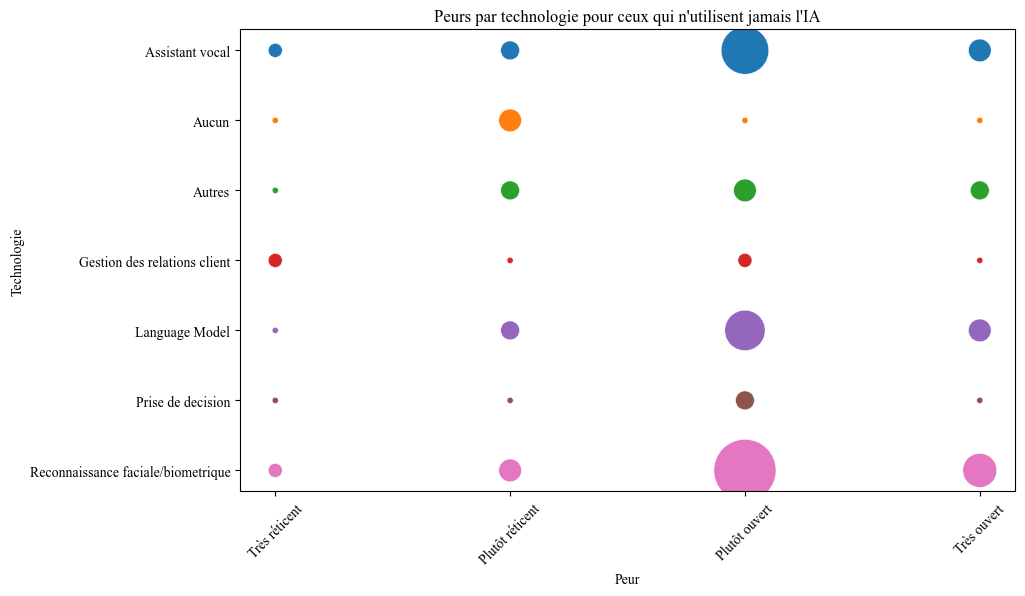

In [57]:
# 8/9 Tools Used by Current AI Usage
df_exploded = df_survey.explode('Tools')
df_never_use_ai = df_exploded[df_exploded['*Usage'] == 0]

# Group by technology and fear, and count the number of responses
fears_by_tech = df_never_use_ai.groupby(['Tools', '*Openness']).size().unstack().fillna(0)

# Calculate total responses for each technology
fears_by_tech['total'] = fears_by_tech.sum(axis=1)

# Reset index to convert index to columns
df_plot = fears_by_tech.reset_index()

# Melt the DataFrame to have one row per technology and fear
df_melted = df_plot.melt(id_vars=['Tools', 'total'], var_name='fear', value_name='count')

# Create scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_melted, x='fear', y='Tools', size='count', hue='Tools', sizes=(20, 2000), legend=False,)

plt.title('Peurs par technologie pour ceux qui n\'utilisent jamais l\'IA')
plt.xlabel('Peur')
plt.xticks([0, 1, 2, 3], ['Très réticent', 'Plutôt réticent', 'Plutôt ouvert', 'Très ouvert'])
plt.ylabel('Technologie')
plt.xticks(rotation=45)
plt.show()


# ❓ 10. Quelles sont vos principales motivations pour utiliser au travail des outils basés sur l'IA ?
- [ ] 10/11 Problèmes rencontrés avec les outils basés sur l'IA par motivations
- [ ] 10/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par motivations
- [ ] 10/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par motivations
- [ ] 10/14 Perception de la perte d'autonomie due à l'IA par motivations
- [ ] 10/15 Perception de la réduction des capacités de réflexion due à l'IA par motivations
- [ ] 10/16 Crainte de perdre son emploi à cause de l'IA par motivations
- [ ] 10/17 Autres inquiétudes face à l'arrivée de l'IA par motivations
- [ ] 10/18 Inclusion dans le développement d'outils basés sur l'IA par motivations
- [ ] 10/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par motivations
- [ ] 10/20 Inclination à utiliser l'IA après consultation par motivations
- [ ] 10/21 Disposition à suivre une formation sur les technologies basées sur l'IA par motivations
- [ ] 10/22 Commentaires et suggestions sur l'arrivée de l'IA par motivations

---

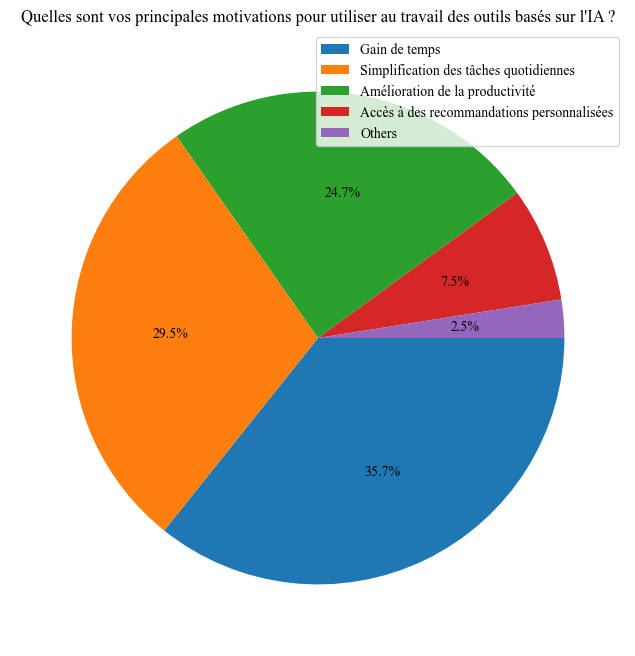

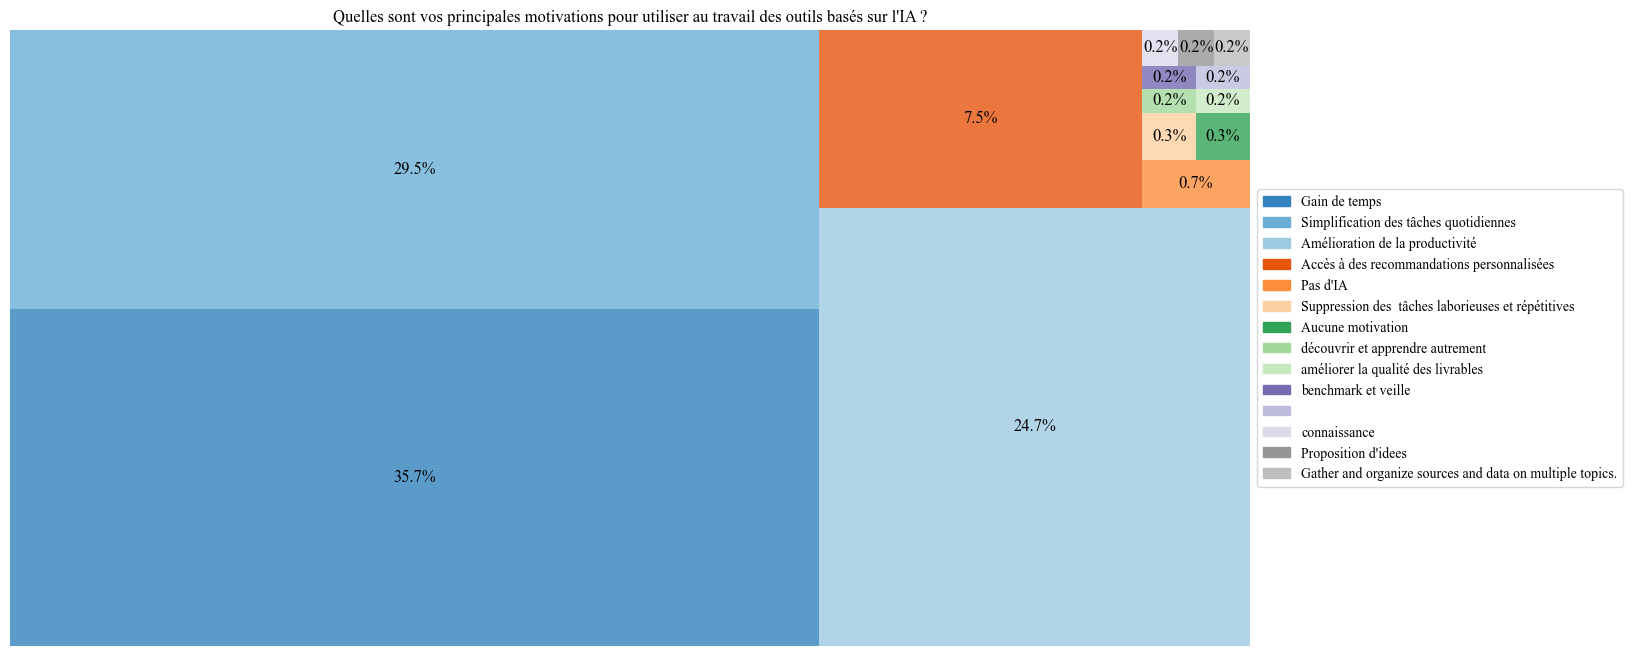

In [58]:
plot_pie('Motivations', 'Quelles sont vos principales motivations pour utiliser au travail des outils basés sur l\'IA ?')
plot_treemap('Motivations', 'Quelles sont vos principales motivations pour utiliser au travail des outils basés sur l\'IA ?')

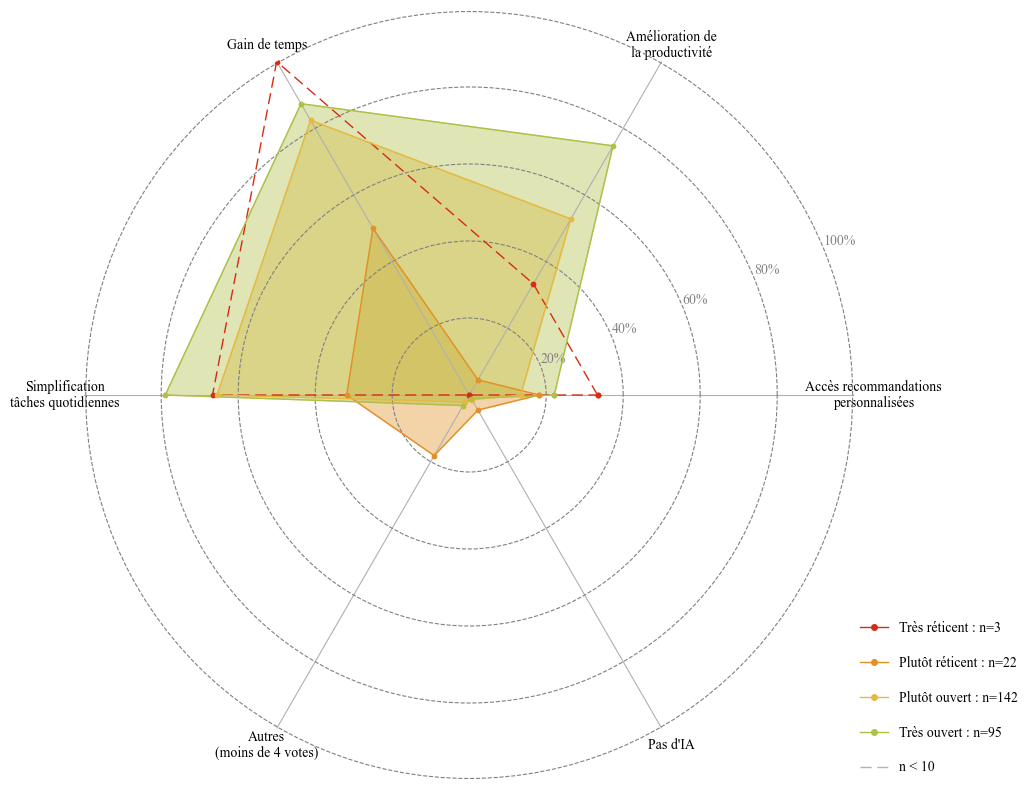

In [59]:
MIN_PARTICIPATION_FILTER = 4

BG_WHITE = "#fbf9f4"
BLUE = "#2a475e"
GREY70 = "#b3b3b3"
GREY_LIGHT = "#f2efe8"
COLORS = ["#d72c14", "#e29127", "#e6b941", "#AFBF47"]

openness_labels = {
    3: 'Très ouvert',
    2: 'Plutôt ouvert',
    1: 'Plutôt réticent',
    0: 'Très réticent'
}

# Filtrage initial
df_filtered = df_survey.loc[~df_survey['Motivations'].str.contains('Pas d\'IA', na=False)].copy()
df_filtered['Motivations'] = df_filtered['Motivations'].apply(lambda m_set: [m for m in m_set if m])

# Comptage de l'ouverture
openness_counts = df_filtered['*Openness'].value_counts()

# Gestion des motivations 'Autres'
motivations_counts = df_filtered.explode('Motivations')['Motivations'].value_counts()
other_motivations = motivations_counts[motivations_counts < MIN_PARTICIPATION_FILTER].index
df_filtered['Motivations'] = df_filtered['Motivations'].apply(lambda m_set: [m if m not in other_motivations else 'Autres' for m in m_set])

# Transformation en DataFrame long
df_motivations = df_filtered.explode('Motivations')

# Calcul des comptes et pourcentages
df_counts = df_motivations.groupby(['*Openness', 'Motivations']).size().reset_index(name='counts')
df_counts['percentage'] = df_counts.apply(lambda x: (x['counts'] / openness_counts[x['*Openness']]) * 100, axis=1)

# Ajout des lignes manquantes pour chaque combinaison d'ouverture et de motivation
all_combinations = pd.MultiIndex.from_product([df_counts['*Openness'].unique(), df_counts['Motivations'].unique()], names=['*Openness', 'Motivations'])
df_counts = df_counts.set_index(['*Openness', 'Motivations']).reindex(all_combinations, fill_value=0).reset_index()
df_counts['percentage'] = (df_counts['counts'] / df_counts['*Openness'].map(openness_counts)) * 100

# Préparation des données pour le tracé
motivations = df_counts['Motivations'].unique()
num_motivations = len(motivations)
axis_angles = np.linspace(0, 2 * np.pi, num_motivations, endpoint=False).tolist()
axis_angles += axis_angles[:1]

# Convertir les motivations en Series pour utiliser la méthode replace
motivations_series = pd.Series(df_counts['Motivations'].unique())
motivations_series = motivations_series.replace('Autres', 'Autres\n(moins de 4 votes)')
motivations_series = motivations_series.replace('Simplification des tâches quotidiennes', 'Simplification\ntâches quotidiennes')
motivations_series = motivations_series.replace('Accès à des recommandations personnalisées', 'Accès recommandations\npersonnalisées')
motivations_series = motivations_series.replace('Amélioration de la productivité', 'Amélioration de\nla productivité')
motivations_rename = motivations_series.tolist()

# Tracé
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Suppression des bordures
ax.spines["start"].set_color("none")
ax.spines["polar"].set_color("none")

plt.xticks(axis_angles[:-1], motivations_rename)
plt.yticks([20, 40, 60, 80, 99.6], ["20%", "40%", "60%", "80%", "100%"], color="grey", size=10)
plt.ylim(0, 100)
ax.yaxis.grid(True, linestyle='--', color='grey', linewidth=0.8, dash_capstyle='butt')

for idx, openness in enumerate(sorted(openness_labels.keys())):
    filtered_data = df_counts[df_counts['*Openness'] == openness]
    values = filtered_data.set_index('Motivations').reindex(motivations)['percentage'].fillna(0).tolist()
    values += values[:1]
    if openness != 0:
      ax.fill(axis_angles, values, c=COLORS[idx], alpha=0.4)
      ax.plot(axis_angles, values, c=COLORS[idx], linewidth=1, linestyle='solid', label=openness_labels[openness])
    else :
      ax.plot(axis_angles, values, c=COLORS[idx], linewidth=1, linestyle='--', dashes=[8, 4], label=openness_labels[openness])
    ax.scatter(axis_angles, values, s=10, c=COLORS[idx], zorder=10)

# Ajout de la légende au graphique avec les handles personnalisés
handles = [
    Line2D([], [], c=color, lw=1, marker="o", markersize=4, label=f"{openness_labels[openness]} : n={openness_counts[openness]}")
    for openness, color in zip(sorted(openness_labels.keys()), COLORS)
]
handles.append(Line2D([], [], c=GREY70, lw=1, linestyle='--', dashes=[8, 4], label='n < 10'))
legend = ax.legend(handles=handles, loc=(1, 0), labelspacing=1.5, frameon=False)

plt.show()

# ❓ 11. Dans le cas où vous auriez utilisé un outil avec de l’IA, avez-vous déjà rencontré des problèmes ou des désagréments liés à son utilisation ?
- [ ] 11/12 Confiance dans les décisions prises par les systèmes basés sur l'IA par problèmes rencontrés
- [ ] 11/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par problèmes rencontrés
- [ ] 11/14 Perception de la perte d'autonomie due à l'IA par problèmes rencontrés
- [ ] 11/15 Perception de la réduction des capacités de réflexion due à l'IA par problèmes rencontrés
- [ ] 11/16 Crainte de perdre son emploi à cause de l'IA par problèmes rencontrés
- [ ] 11/17 Autres inquiétudes face à l'arrivée de l'IA par problèmes rencontrés
- [ ] 11/18 Inclusion dans le développement d'outils basés sur l'IA par problèmes rencontrés
- [ ] 11/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par problèmes rencontrés
- [ ] 11/20 Inclination à utiliser l'IA après consultation par problèmes rencontrés
- [ ] 11/21 Disposition à suivre une formation sur les technologies basées sur l'IA par problèmes rencontrés
- [ ] 11/22 Commentaires et suggestions sur l'arrivée de l'IA par problèmes rencontrés

---

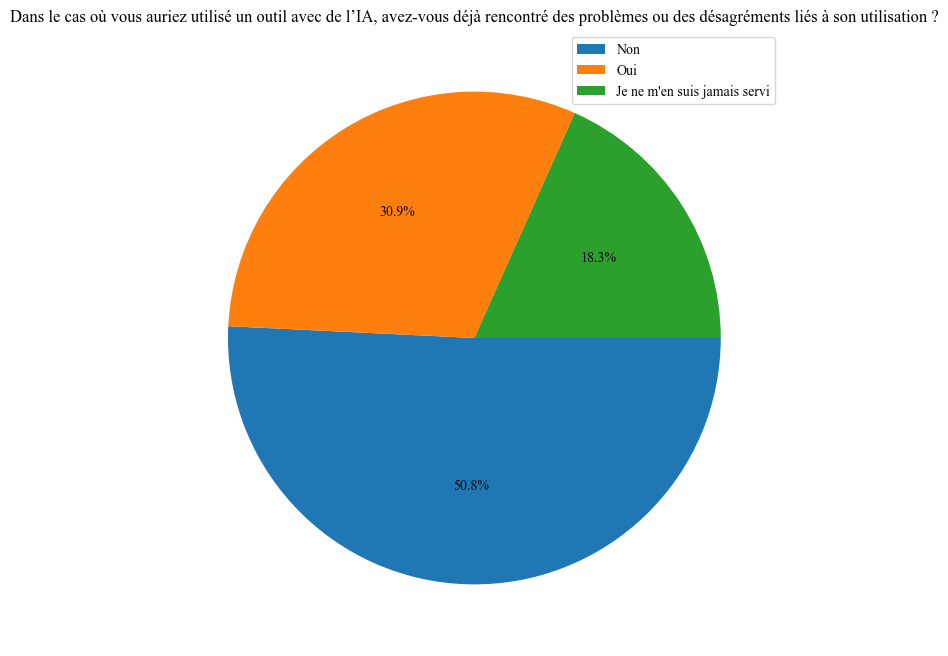

In [60]:
plot_pie('Issues', 'Dans le cas où vous auriez utilisé un outil avec de l’IA, avez-vous déjà rencontré des problèmes ou des désagréments liés à son utilisation ?')

# ❓ 12. Comment évaluez-vous votre confiance dans les décisions prises par les systèmes basés sur l'IA ?
- [ ] 12/13 Inquiétudes quant à l'impact de l'IA sur la vie professionnelle par confiance dans l'IA
- [ ] 12/14 Perception de la perte d'autonomie due à l'IA par confiance dans l'IA
- [ ] 12/15 Perception de la réduction des capacités de réflexion due à l'IA par confiance dans l'IA
- [ ] 12/16 Crainte de perdre son emploi à cause de l'IA par confiance dans l'IA
- [ ] 12/17 Autres inquiétudes face à l'arrivée de l'IA par confiance dans l'IA
- [ ] 12/18 Inclusion dans le développement d'outils basés sur l'IA par confiance dans l'IA
- [ ] 12/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par confiance dans l'IA
- [ ] 12/20 Inclination à utiliser l'IA après consultation par confiance dans l'IA
- [x] 12/21 Disposition à suivre une formation sur les technologies basées sur l'IA par confiance dans l'IA
- [ ] 12/22 Commentaires et suggestions sur l'arrivée de l'IA par confiance dans l'IA

---

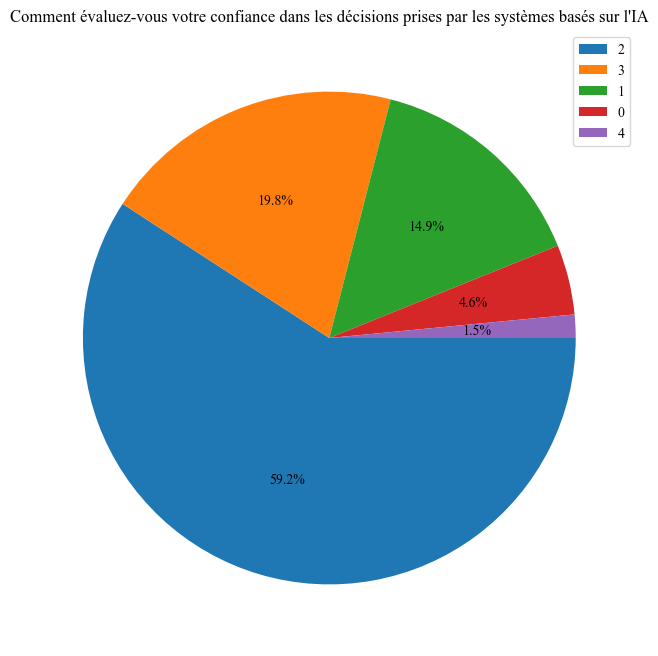

In [61]:
plot_pie('Trust', 'Comment évaluez-vous votre confiance dans les décisions prises par les systèmes basés sur l\'IA')

## ✅ 6. Confiance IA

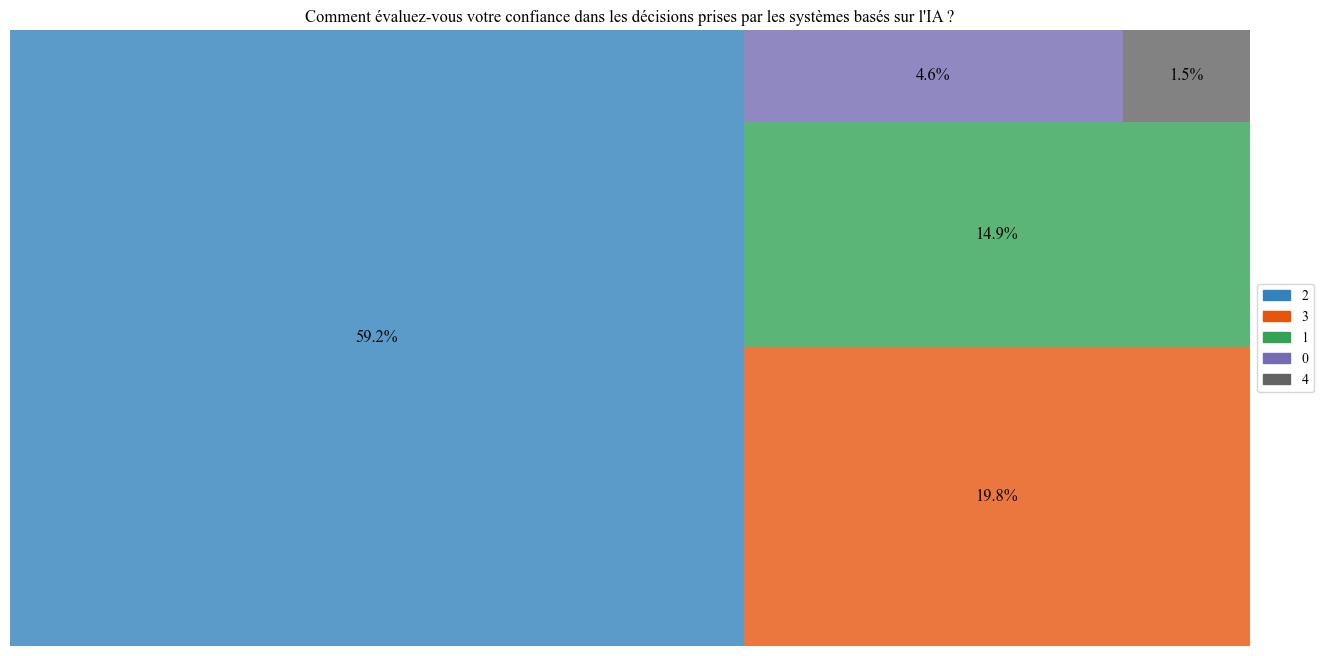

In [62]:
# Check if df_survey['Trust'] is a set; if it is, we need to explode first
df = pd.DataFrame()
if isinstance(df_survey['Trust'].dropna().iloc[0], set):
    df = df_survey.explode('Trust')
else:
    df = df_survey.copy()

# Get value counts normalized
graph_df = df['Trust'].value_counts(normalize=True)

# Sort values in descending order
graph_df = graph_df.sort_values(ascending=False)

# Prepare data for treemap
labels = [f'{value:.1%}' for value in graph_df.values]
full_labels = [f'{index}' for index, value in graph_df.items()]
sizes = graph_df.values * 100  # Convert to percentages
cmap = plt.get_cmap('tab20c')  # Use a colormap

# Generate colors from the colormap
colors = [cmap(i / float(len(labels))) for i in range(len(labels))]

plt.figure(figsize=(16, 8))

# Plot treemap
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8, text_kwargs={'fontsize':12})
plt.title('Comment évaluez-vous votre confiance dans les décisions prises par les systèmes basés sur l\'IA ?')
plt.axis('off')  # No axes for treemap
plt.xticks([]) #TODO remap pour ajouter le 1 et le 5

# Add legend
patches = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(patches, full_labels, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

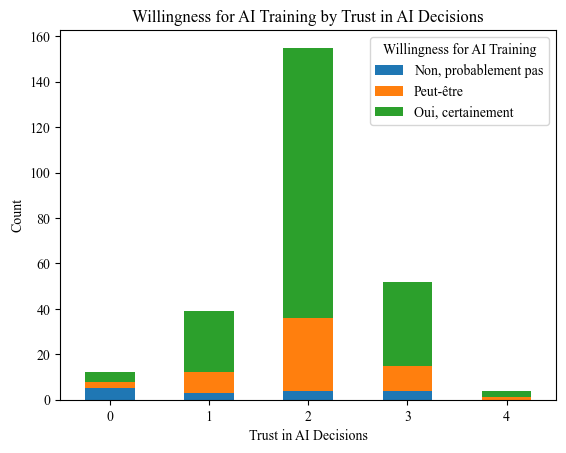

In [63]:
# 12/21 Willingness for AI Training by Trust in AI Decisions
training_trust = df_survey.groupby('Trust')[
  'WillingnessForTraining'
].value_counts().unstack().reindex(columns=[
    'Non, probablement pas',
    'Peut-être',
    'Oui, certainement'
]).plot(kind='bar', stacked=True)
plt.title('Willingness for AI Training by Trust in AI Decisions')
plt.xlabel('Trust in AI Decisions')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Willingness for AI Training')
plt.show()

# ❓ 13. Avez-vous des inquiétudes quant à la manière dont l’IA peut affecter votre vie professionnelle ?
- [ ] 13/14 Perception de la perte d'autonomie due à l'IA par inquiétudes
- [ ] 13/15 Perception de la réduction des capacités de réflexion due à l'IA par inquiétudes
- [ ] 13/16 Crainte de perdre son emploi à cause de l'IA par inquiétudes
- [ ] 13/17 Autres inquiétudes face à l'arrivée de l'IA par inquiétudes
- [ ] 13/18 Inclusion dans le développement d'outils basés sur l'IA par inquiétudes
- [ ] 13/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par inquiétudes
- [ ] 13/20 Inclination à utiliser l'IA après consultation par inquiétudes
- [ ] 13/21 Disposition à suivre une formation sur les technologies basées sur l'IA par inquiétudes
- [ ] 13/22 Commentaires et suggestions sur l'arrivée de l'IA par inquiétudes

---

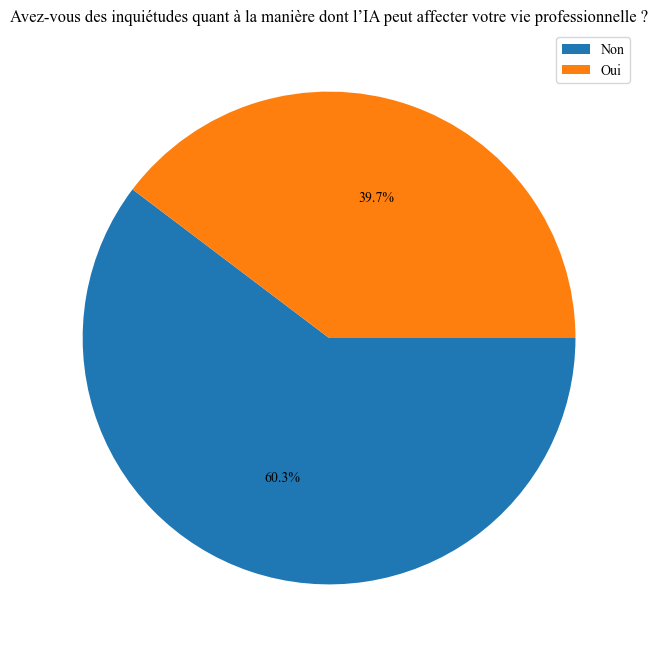

In [64]:
plot_pie('Concerns', 'Avez-vous des inquiétudes quant à la manière dont l’IA peut affecter votre vie professionnelle ?')

In [65]:
# Resistance > Issues > Concerns > FearOfJobLoss >
# > Involved > want_to_be_consulted_on_ai_development > ImpactOfBeingInvolved
binary_columns = [
  "Resistance",
  "Issues",
  "Concerns",
  "FearOfJobLoss",
  "Involved",
  "WantToBeInvolved",
  "ImpactOfBeingInvolved"
]
df_bin_tree = df_survey[binary_columns]
df_bin_tree = df_bin_tree[df_bin_tree["Issues"] != "Je ne m'en suis jamais servi"]
df_bin_tree = df_bin_tree[df_bin_tree["Involved"] != "Mon entreprise n'utilise pas l’IA"]
df_bin_tree = df_bin_tree.dropna(subset=binary_columns)

# Convert binary responses to numeric values
for column in df_bin_tree.columns:
  df_bin_tree[column] = df_bin_tree[column].map({
    'Oui': 1,
    'Non': 0
  })

df_bin_tree = df_bin_tree.reset_index()  # make sure indexes pair with number of rows

sankey_dict = {}

for index, row in df_bin_tree.iterrows():
  key = ""
  for depth in range(len(binary_columns) - 1):
    key = key + str(row[binary_columns[depth]])
    if key not in sankey_dict:
      sankey_dict[key] = 1
    else:
      sankey_dict[key] += 1

# Create a DataFrame for the Sankey diagram
df_sankey = pd.DataFrame(columns=['source', 'target', 'value'])

sankey_dict_ids = {
  'root': 0
}
for key in sankey_dict.keys():
  sankey_dict_ids[key] = len(sankey_dict_ids)

labels = []

for key, value in sankey_dict.items():
  if len(key) <= 1:
    source = 'root'
  else:
    source = key[:-1]
  df_sankey.loc[len(df_sankey)] = {
      'source': sankey_dict_ids[source],
      'target': sankey_dict_ids[key],
      'value': value
    }
  if len(key) < len(binary_columns) - 1:
    labels.append(binary_columns[len(key)-1] + ' = ' + key[-1].replace('0', 'Non').replace('1', 'Oui'))
  else:
    labels.append('end')


x_positions = [(i + .01) / (len(binary_columns) - 1) for i in range(len(binary_columns))]
y_positions = [i / (len(labels) - 1) for i in range(len(labels))]

fig = go.Figure(data=[go.Sankey(
  node = dict(
    line = dict(color = "black", width = 0.5),
    label = labels,
    x = x_positions,
    y = y_positions,
  ),
  link = dict(
    source = df_sankey['source'],
    target = df_sankey['target'],
    value = df_sankey['value']
  )
)], layout=go.Layout(height=800))

fig.show()

In [66]:

#todo mettre en rapport les questions 13 14 15 16

# ❓ 14. Dans quelle mesure pensez-vous que l'IA pourrait vous faire perdre votre autonomie ?
- [ ] 14/15 Perception de la réduction des capacités de réflexion due à l'IA par perception de la perte d'autonomie
- [ ] 14/16 Crainte de perdre son emploi à cause de l'IA par perception de la perte d'autonomie
- [ ] 14/17 Autres inquiétudes face à l'arrivée de l'IA par perception de la perte d'autonomie
- [ ] 14/18 Inclusion dans le développement d'outils basés sur l'IA par perception de la perte d'autonomie
- [ ] 14/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par perception de la perte d'autonomie
- [ ] 14/20 Inclination à utiliser l'IA après consultation par perception de la perte d'autonomie
- [ ] 14/21 Disposition à suivre une formation sur les technologies basées sur l'IA par perception de la perte d'autonomie
- [ ] 14/22 Commentaires et suggestions sur l'arrivée de l'IA par perception de la perte d'autonomie

---

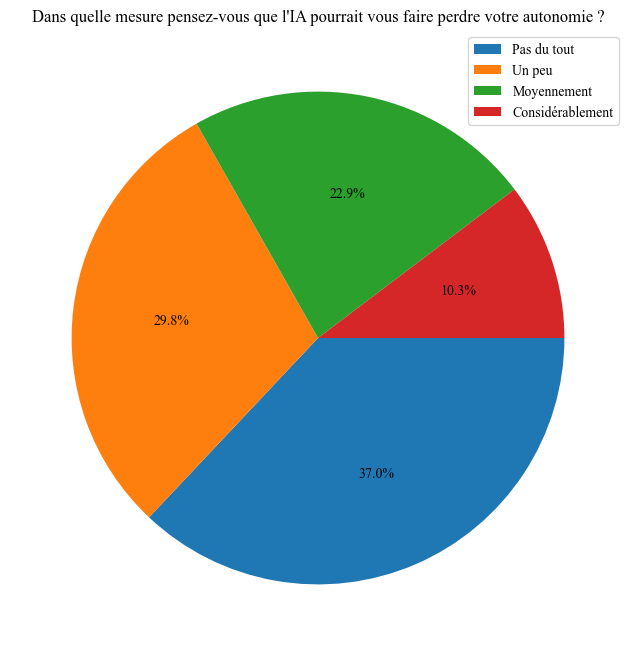

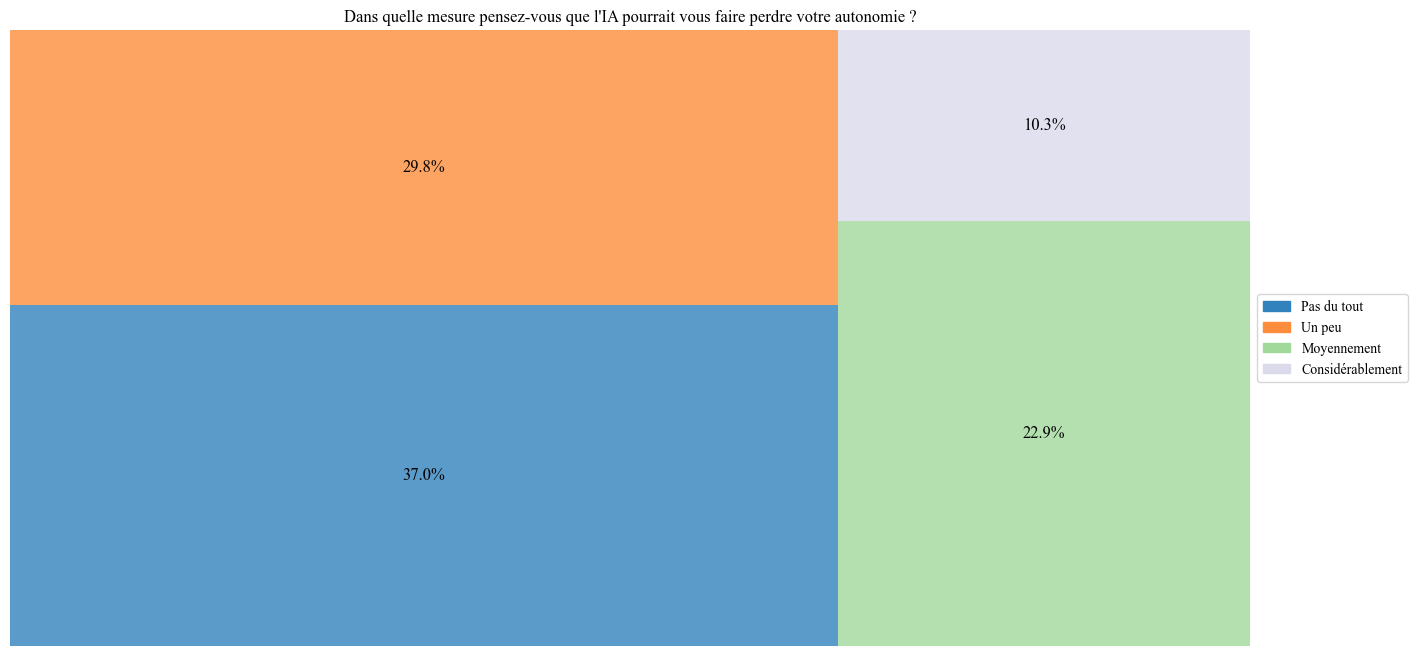

In [67]:
plot_pie('LossOfAutonomy', 'Dans quelle mesure pensez-vous que l\'IA pourrait vous faire perdre votre autonomie ?')
plot_treemap('LossOfAutonomy', 'Dans quelle mesure pensez-vous que l\'IA pourrait vous faire perdre votre autonomie ?')

# ❓ 15. Dans quelle mesure pensez-vous que l'IA pourrait réduire vos capacités de réflexions ?
- [ ] 15/16 Crainte de perdre son emploi à cause de l'IA par perception de la réduction des capacités de réflexion
- [ ] 15/17 Autres inquiétudes face à l'arrivée de l'IA par perception de la réduction des capacités de réflexion
- [ ] 15/18 Inclusion dans le développement d'outils basés sur l'IA par perception de la réduction des capacités de réflexion
- [ ] 15/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par perception de la réduction des capacités de réflexion
- [ ] 15/20 Inclination à utiliser l'IA après consultation par perception de la réduction des capacités de réflexion
- [ ] 15/21 Disposition à suivre une formation sur les technologies basées sur l'IA par perception de la réduction des capacités de réflexion
- [ ] 15/22 Commentaires et suggestions sur l'arrivée de l'IA par perception de la réduction des capacités de réflexion

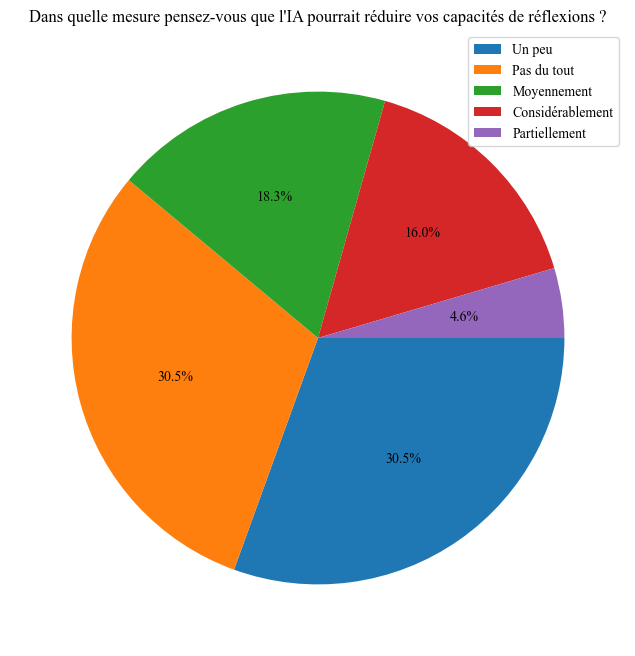

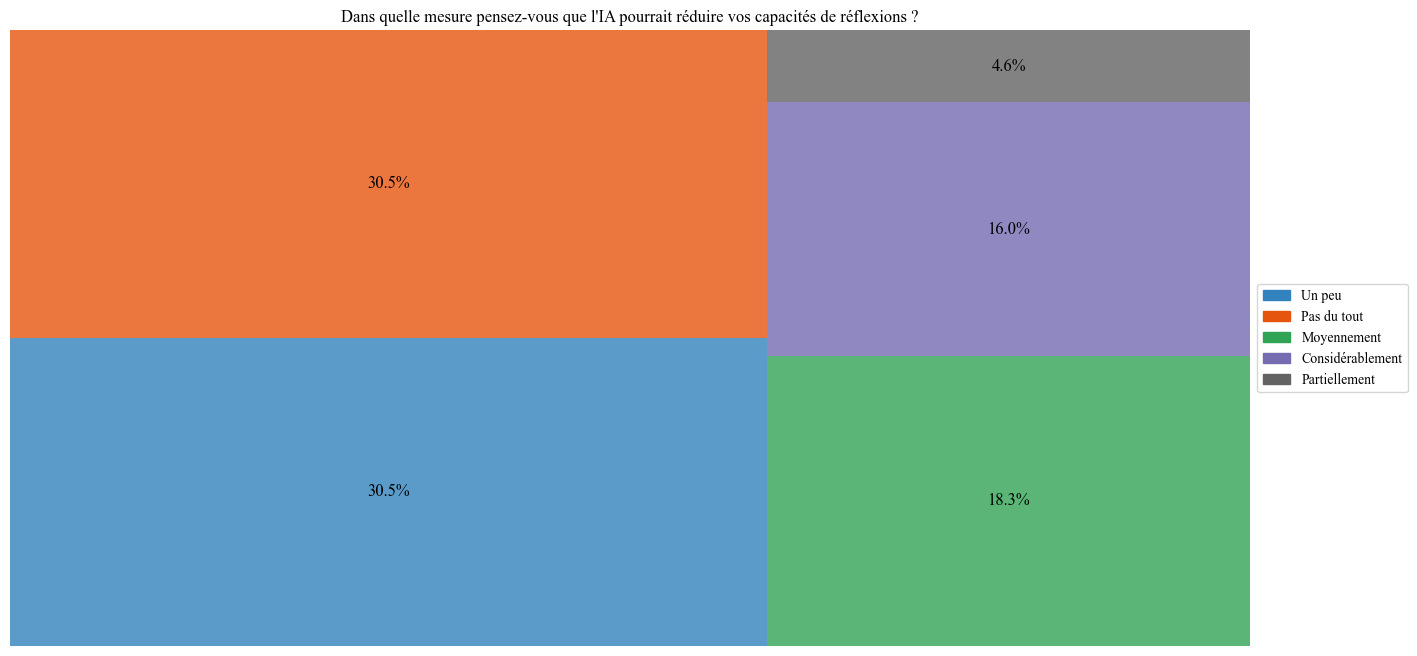

In [68]:
plot_pie('ReducedThinking', 'Dans quelle mesure pensez-vous que l\'IA pourrait réduire vos capacités de réflexions ?')
plot_treemap('ReducedThinking', 'Dans quelle mesure pensez-vous que l\'IA pourrait réduire vos capacités de réflexions ?')

# ❓ 16. Craignez-vous que l'IA ne vous fasse perdre votre emploi ?
- [ ] 16/17 Autres inquiétudes face à l'arrivée de l'IA par crainte de perdre son emploi
- [ ] 16/18 Inclusion dans le développement d'outils basés sur l'IA par crainte de perdre son emploi
- [ ] 16/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par crainte de perdre son emploi
- [ ] 16/20 Inclination à utiliser l'IA après consultation par crainte de perdre son emploi
- [ ] 16/21 Disposition à suivre une formation sur les technologies basées sur l'IA par crainte de perdre son emploi
- [ ] 16/22 Commentaires et suggestions sur l'arrivée de l'IA par crainte de perdre son emploi

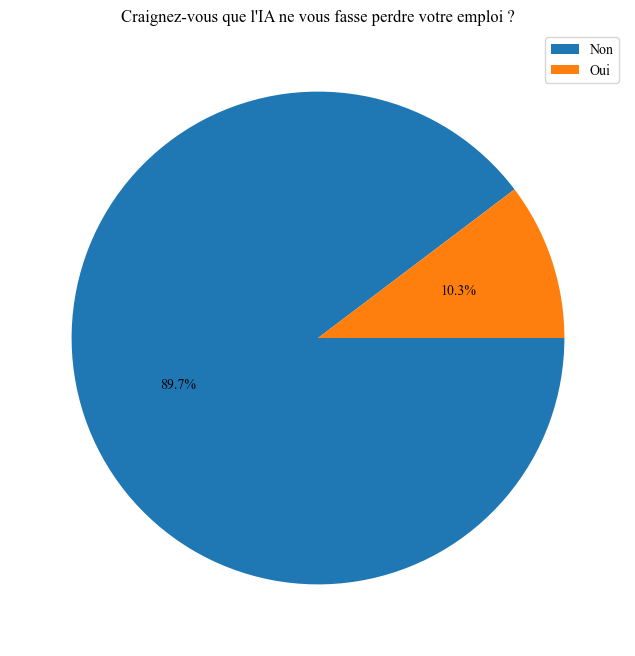

L'IA est encore trop bête pour ça, et je pense que j'ai le temps avant qu'elle devienne suffisamment intelligente pour me voler mon travail.
Métier de contrôle indispensable
L'utilisation de l'IA requiert un utilisateur disposant d'esprit critique et de culture de son métier pour valider la donnée obtenue par IA
L'IA doit être une aide mais la décision et le regard critique reste à ma main
Les taches à plus forte valeur ajoutée resteront à la main des humains
Mon domaine dactivite necessite du travail de terrain que l'IA ne peut pas effectuer et de lanalyse juridique. Tout les aspects de calculs et de dessins arctecturaux pourraient etre affecté, mais pas toute la profession pour autant.
xx
pas de crainte dans le métier de commercial B to C car il faut un contact humain qui peut aider à la prise de décision.
L'IA serait un atout pour augmenter en compétence.
Il y aura toujours besoin de relations humaines dans le cadre de mon métier
C'est un outil et seulement un outil.
La conduite de 

In [69]:
plot_pie('FearOfJobLoss', 'Craignez-vous que l\'IA ne vous fasse perdre votre emploi ?')

for response in df_survey['FearOfJobLossDetails'].dropna():
  print(response)

# ❓ 17. Avez-vous d’autres inquiétudes vis-à-vis de votre travail face à l’arrivée de l’IA ?
- [ ] 17/18 Inclusion dans le développement d'outils basés sur l'IA par autres inquiétudes face à l'arrivée de l'IA
- [ ] 17/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par autres inquiétudes face à l'arrivée de l'IA
- [ ] 17/20 Inclination à utiliser l'IA après consultation par autres inquiétudes face à l'arrivée de l'IA
- [ ] 17/21 Disposition à suivre une formation sur les technologies basées sur l'IA par autres inquiétudes face à l'arrivée de l'IA
- [ ] 17/22 Commentaires et suggestions sur l'arrivée de l'IA par autres inquiétudes face à l'arrivée de l'IA

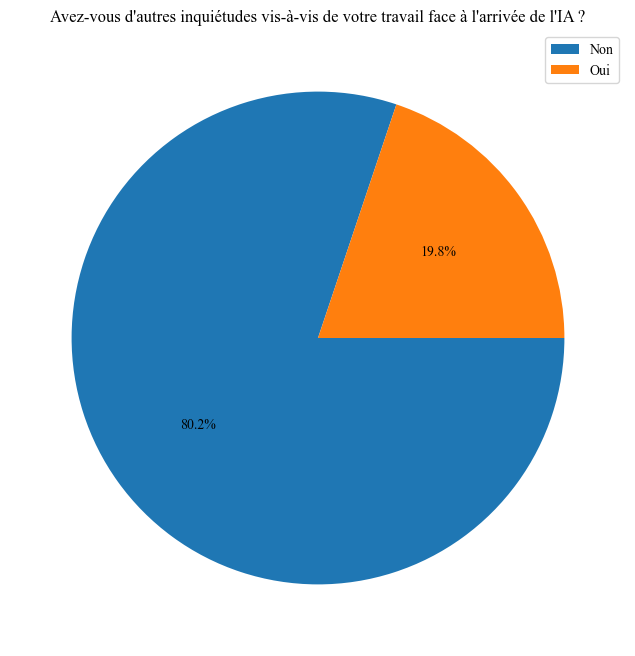

Les services externes d'IA sont une très grosse brèche de sécurité : je ne peux pas demander à ChatGPT d'écrire du code pour moi sans briser les clauses de non-divulgation de mon contrat. Au niveau de la génération d'images, on a également des risques au niveau des droits d'auteur, qui est encore quelque chose d'assez flou.
Ne pas savoir suffisamment bien l'utiliser au quotidien et perdre en productivité par rapport à d'autres qui auraient été mieux formés
Le fonctionnement de l’IA doit être transparent pour les utilisateurs et les algorithmes ouverts à tous afin de contrôler d’éventuels dysfonctionnements
l'accompagnement de l'entreprise et des collaborateurs : tous les embarquer
Un paresse d'esprit, vol de données, perte de la dimension humaine et affective,....
Grosse perte en compétence, du savoir-faire et manque d'humanité dans le travail (je ne suis pas travaillé avec une IA comme collègue). Cela doit rester un outil.
Non plus sur le domaine personnel (santé, organisme financier,

In [70]:
plot_pie('OtherConcerns', 'Avez-vous d\'autres inquiétudes vis-à-vis de votre travail face à l\'arrivée de l\'IA ?')

for response in df_survey['OtherConcernsDetails'].dropna():
  print(response)

# ❓ 18. Avez-vous été inclus dans l’une des phases de développement d’outils basés sur l’IA dans votre entreprise ?
- [ ] 18/19 Désir de consultation pour l'élaboration d'outils basés sur l'IA par inclusion dans le développement d'outils basés sur l'IA
- [ ] 18/20 Inclination à utiliser l'IA après consultation par inclusion dans le développement d'outils basés sur l'IA
- [ ] 18/21 Disposition à suivre une formation sur les technologies basées sur l'IA par inclusion dans le développement d'outils basés sur l'IA
- [ ] 18/22 Commentaires et suggestions sur l'arrivée de l'IA par inclusion dans le développement d'outils basés sur l'IA

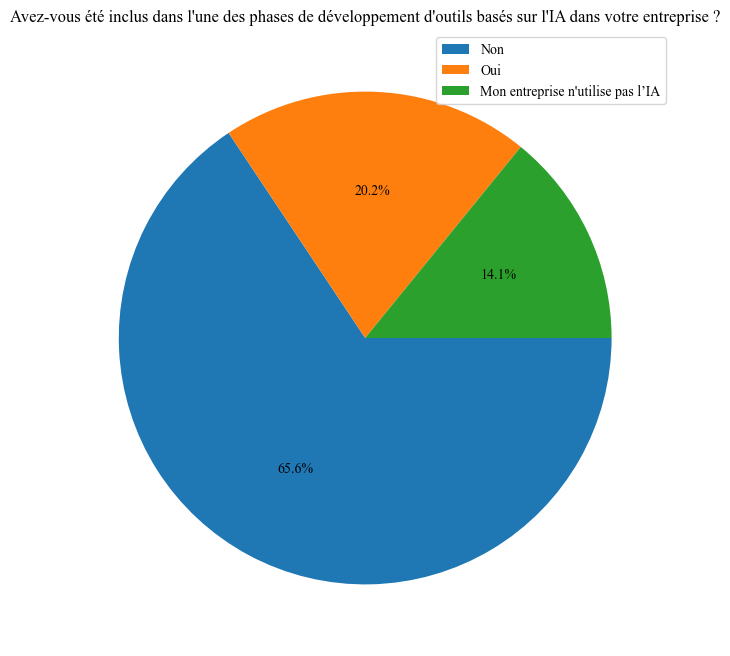

In [71]:
plot_pie('Involved', 'Avez-vous été inclus dans l\'une des phases de développement d\'outils basés sur l\'IA dans votre entreprise ?')

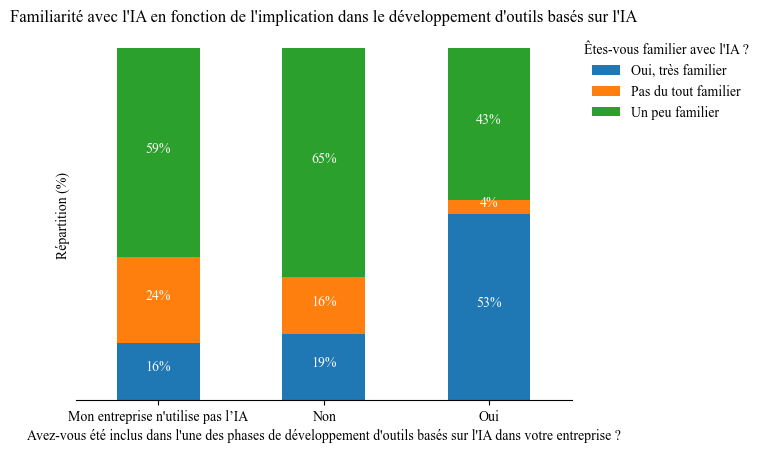

In [72]:
# Familiarité pour ceux inclus dans le développement d'outils basés sur l'IA vs Non vs Mon entreprise n'utilise pas l'IA
familiarity_involvement_bar = df_survey.groupby(['Involved', 'Familiarity']).size().unstack()

# Convert counts to percentages
familiarity_age_percentage = familiarity_involvement_bar.div(familiarity_involvement_bar.sum(axis=1), axis=0) * 100

# Plot the data
ax = familiarity_age_percentage.plot(kind='bar', stacked=True)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('none')
ax.set_yticks([])

plt.title('Familiarité avec l\'IA en fonction de l\'implication dans le développement d\'outils basés sur l\'IA')
plt.xlabel('Avez-vous été inclus dans l\'une des phases de développement d\'outils basés sur l\'IA dans votre entreprise ?')
plt.ylabel('Répartition (%)')
plt.xticks(rotation=0)
plt.legend(title='Êtes-vous familier avec l\'IA ?', bbox_to_anchor=(1, 1), loc='upper left', frameon=False)


# Add percentages on top of each bar
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}%', (x + width/2, y + height*0.5), ha='center', color='white')

plt.show()

In [73]:
# Formation par age


# ❓ 19. Dans le futur, aimeriez-vous être consulté pour l’élaboration d’un outil basé sur l’IA qui sera intégré dans votre entreprise ?
- [ ] 19/20 Inclination à utiliser l'IA après consultation par désir de consultation pour l'élaboration d'outils basés sur l'IA
- [ ] 19/21 Disposition à suivre une formation sur les technologies basées sur l'IA par désir de consultation pour l'élaboration d'outils basés sur l'IA
- [ ] 19/22 Commentaires et suggestions sur l'arrivée de l'IA par désir de consultation pour l'élaboration d'outils basés sur l'IA

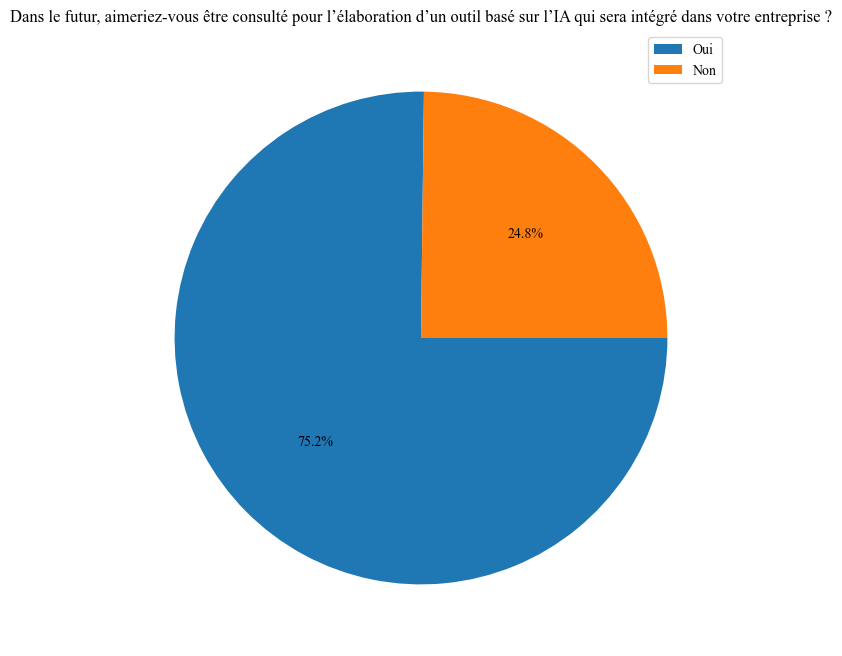

In [74]:
plot_pie('WantToBeInvolved', 'Dans le futur, aimeriez-vous être consulté pour l’élaboration d’un outil basé sur l’IA qui sera intégré dans votre entreprise ?')

# ❓ 20. Si vous étiez consulté, seriez-vous plus enclin à vous servir de l’IA dans votre travail ?
- [ ] 20/21 Disposition à suivre une formation sur les technologies basées sur l'IA par inclination à utiliser l'IA après consultation
- [ ] 20/22 Commentaires et suggestions sur l'arrivée de l'IA par inclination à utiliser l'IA après consultation

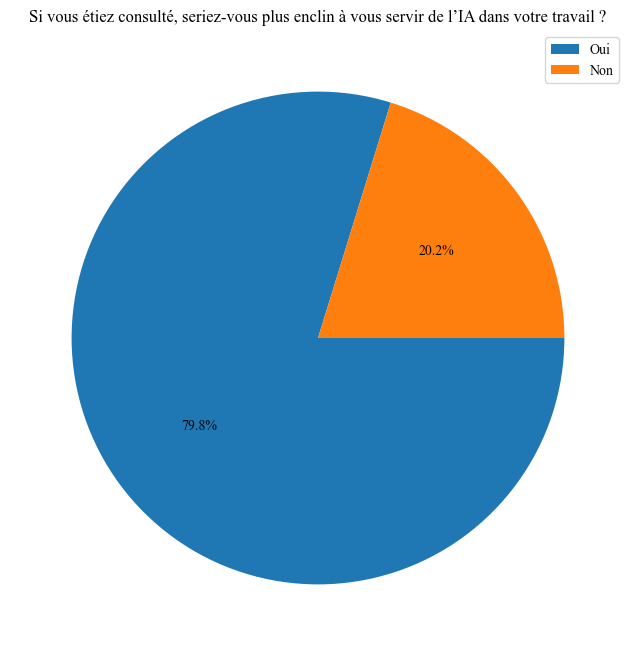

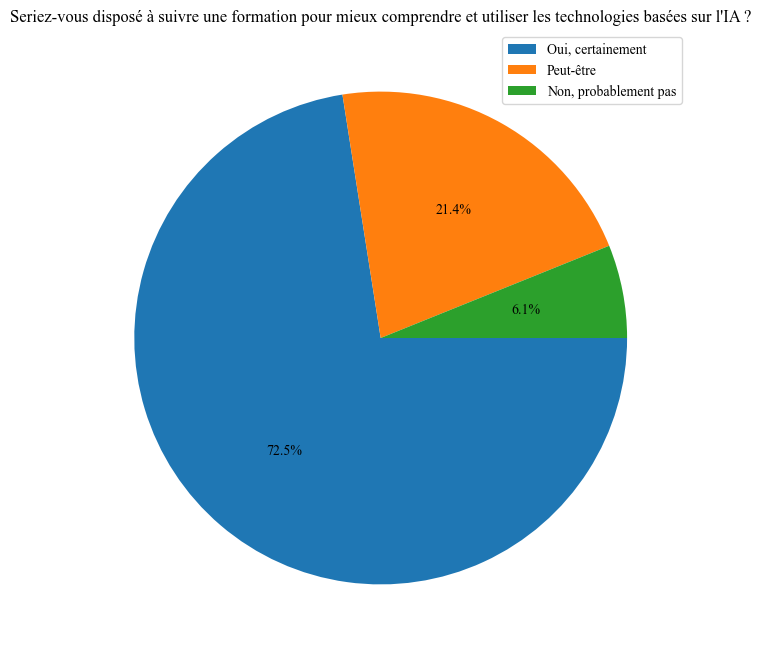

In [75]:
plot_pie('ImpactOfBeingInvolved', 'Si vous étiez consulté, seriez-vous plus enclin à vous servir de l’IA dans votre travail ?')

plot_pie('WillingnessForTraining', 'Seriez-vous disposé à suivre une formation pour mieux comprendre et utiliser les technologies basées sur l\'IA ?')
